In [ ]:
# Notebook from https://medium.com/@thakermadhav/build-your-own-rag-with-mistral-7b-and-langchain-97d0c92fa146
!pip install -q torch datasets
!pip install -q accelerate==0.21.0 \
                peft==0.4.0 \
                bitsandbytes==0.40.2 \
                transformers==4.31.0 \
                trl==0.4.7
!pip install -q scipy langchain transformers playwright html2text sentence_transformers faiss-gpu
!pip install -q --upgrade git+https://github.com/huggingface/transformers

In [ ]:
!playwright install > /dev/null
!playwright install-deps > /dev/null

In [ ]:
!pip install -U tokenizers

In [ ]:
import os
import torch
from transformers import (
  AutoTokenizer, 
  AutoModelForCausalLM, 
  BitsAndBytesConfig,
  pipeline
)

from transformers import BitsAndBytesConfig




from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain


#################################################################
# Tokenizer
#################################################################

model_name="mistralai/Mistral-7B-Instruct-v0.1"
model_name="mistralai/Mixtral-8x7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    cache_dir=".",
)
#load_in_4bits=True)


In [59]:
model.config.pad_token_id = tokenizer.pad_token_id

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
)

mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

In [60]:
import arrow
import pandas as pd
PARQUET_FILE="Accords/echantillon_public_Mathilde.parquet"

In [61]:
df_init=pd.read_parquet(PARQUET_FILE)

In [62]:
prompt_template = """

### [ROLE] Role: Vous êtes un expert juridique des accords d'entreprise sans compétence de programmation informatique, seulement la lecture et la compréhension des textes. Tu ne connais aucun langage de programmation, ni les expressions régulières.


### [INST] Instructions: 

1. Votre travail consiste à peupler et mettre à jour une base des données nécessaires pour réaliser des études économétriques poussées sur le télétravail.
        Pour cela, vous devez prendre le texte d'un accord d'entreprise dans les documents suivants, dans lesquelles figurent les informations à jour que l'on vous fourni, et d'extraire précisément l'information spécifique dont vous avez besoin.
        Vous ne devez extraire que le nombre, et uniquement le nombre. Le nombre peut être écrit en lettres ou en chiffres. (exemple : deux ou 2 )
        Si vous ne trouvez pas la réponse dans le texte vous devez le dire et ne pas chercher à en fournir un autre nombre.
        Avant de répondre, vérifier que la réponse se trouve bien dans le texte indiqué.
        
2. Vous devez respecter les règles suivantes : 
        2.A - Déconnecter les liens entre les périodicités (semaine, mois, trimestre, année)! Faire comme si les semaines, les mois, les trimestres et les années sont des concepts indépendants : dans un mois, il y a donc 0 semaine ; dans un trimestre, 0 mois et 0 semaine; dans une année, 0 trimestre, 0 mois et 0 semaine !
        2.B - Ne faites aucune supposition ni d'hypothèses : déconnectez le module de raisonnement !
        2.C - Ne faites aucun calcul de proratisation : par exemple, s'il y a 10 jours de télétravail autorisés par an, alors on ne peut pas déduire le nombre de jour de télétravail autorisés par semaine.
        2.D - Il n'y a pas de lien entre l'effectif d'un service et le nombre de jour de télétravail, donc ne pas déduire un nombre de jour de télétravail !
        2.E - Si le document mentionne positivement le Télétravail à 100%, ou le full-remote, ET qu'il n'y a pas de jour de présence minimum sur site, alors 5 jours de télétravail est possible par semaine !
        2.F - Si le document mentionne par exemple trois jours de présence sur site et sans autre mention du nombre de jours de télétravail autorisé, alors tu ne peux pas donner de nombre de jour de télétravail par semaine a priori !
        2.G - Il y a cinq jours ouvrés dans une semaine, donc un nombre de jour de télétravail par semaine ne peut pas être strictement supérieur à cinq.
        2.H - Si tu donnes un nombre réel, ne donne pas la fraction mais un arrondi à l'entier inférieur !
        2.I - Si le nombre de jour de télétravail annuel est inférieur à 52, ce nombre de jour de télétravail concerne du télétravail occasionnel. S'il est supérieur ou égal à 52, ce nombre concerne du télétravail régulier.
        2.J - Si le nombre de jour de télétravail trimestriel est inférieur à 13, ce nombre de jour de télétravail concerne du télétravail occasionnel. S'il est supérieur ou égal à 13, ce nombre concerne du télétravail régulier.
        2.K - Si le nombre de jour de télétravail mensuelle est inférieur à 4, ce nombre de jour de télétravail concerne du télétravail occasionnel. S'il est supérieur ou égal à 4, ce nombre concerne du télétravail régulier.

3. Vous devez structurez votre réponse comme suit :
        * Mon extraction de deux paragraphes max pertinents provenant des documents à analyser qui répondent à la question (limité chacun à deux phrases max):
        * Ma réponse après raisonnement ci-dessous :
        * Mon raisonnenement :
        
### Documents à analyser: 
{context}

### QUESTION:
{question} [/INST]
"""

In [63]:
prompt_template2 = """

### [ROLE] Role: Vous êtes un expert juridique des accords d'entreprise sans compétence de programmation informatique, seulement la lecture et la compréhension des textes. Tu ne connais aucun langage de programmation, ni les expressions régulières.


### [INST] Instruction: Votre travail consiste à peupler et mettre à jour une base des données nécessaires pour réaliser des études économétriques poussées sur le télétravail.
        Pour cela, vous devez prendre les textes des accords d'entreprise dans lesquelles figurent les informations à jour que l'on vous fourni, et d'extraire précisément l'information spécifique dont vous avez besoin.
        Vous ne devez extraire que le nombre, et uniquement le nombre. Le nombre peut être écrit en lettres ou en chiffres. (exemple : deux ou 2 )
        Si vous ne trouver pas la réponse dans le texte vous devez le dire et ne pas chercher à en fournir un autre nombre.
        Avant de répondre, vérifier que la réponse se trouve bien dans le texte indiqué.
        Impératif pour votre raisonnement : Déconnecter les liens entre les périodicités (semaine, mois, trimestre, année)! Faire comme si les semaines, les mois, les trimestres et les années sont des concepts indépendants : dans un mois, il y a donc 0 semaine ; dans un trimestre, 0 mois et 0 semaine; dans une année, 0 trimestre, 0 mois et 0 semaine !
{context}

### QUESTION:
{question} [/INST]
"""

# Create prompt from prompt template 
prompt2 = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template2,
)

# Create llm chain 
llm_chain2 = LLMChain(llm=mistral_llm, prompt=prompt2)


In [64]:
# Create prompt from prompt template 
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain 
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

In [65]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
import warnings
warnings.filterwarnings('ignore')
import re
def guess_reponse_booleenne(reponse):
    reponse_booleenne=None
    if reponse["text"].startswith("\nOui") or reponse["text"].startswith("Oui") :
        reponse_booleenne=1
    elif reponse["text"].startswith("\nNon") or reponse["text"].startswith("Non") :
        reponse_booleenne=0
    return reponse_booleenne

def guess_reponse_durée(reponse):
    reponse_booleenne=None
    if "indéterminée" in reponse["text"].lower() :
        reponse_booleenne=0
    elif "déterminée" in reponse["text"].lower():
        reponse_booleenne=1
    return reponse_booleenne

def guess_reponse_nombre(reponse,pattern="nombre"):
    reponse_nombre=None
    REGEX=rf".*{pattern} ?= ?(\d+)"
    numbers=re.findall(REGEX,reponse["text"])
    if numbers:
        reponse_nombre=numbers[0]
    return reponse_nombre

In [66]:
Q_DUREE="S'il est fait mention d'une durée de l'accord, est-ce que l'accord est à durée déterminée ou à durée indéterminée ? déterminée=1 ou indéterminée=0 ou NA?"
Q_REVERS="S'il est fait mention d'une clause et d'un article de réversibilité, est-ce que l'accord a une clause ou un article de réversibilité ? Oui=1 ou non=0 ou NA?"
Q_ADAPT="S'il est fait mention d'une période d'adaptation, est-ce que l'accord comprend une période d'adaptation ? Oui=1 ou non=0 ou NA?"
Q_TTREG="Est-ce qu'au moins un paragraphe mentionne du télétravail régulier ?"
Q_TTOCA="Est-ce qu'au moins un paragraphe mentionne du télétravail occasionnel ?"
Q_TTEXC="Est-ce qu'au moins un paragraphe mentionne du télétravail exceptionnel ?"
Q_DISPOSPERQTHENCEINTE="Est-ce qu'au moins un paragraphe mentionne des dispositifs spéciaux pour les travailleurs en situation de handicap, les femmes enceintes, les séniors ou les personnes présentant des fragilités ou des problèmes de santé ?"
Q_MONTANT_CAVIARDE="Est-ce qu'au moins un paragraphe mentionne un nombre sans le donner exactement, mais sous forme illisible ?"
Q_TELETRAVAIL_FLEX_SANS_LIMITE="Est-ce qu'au moins un paragraphe suggère une liberté totale dans le choix des jours de télétravail, hormis quelques contraintes de présence ?"
Q_TT_REG_NOMBRE_FORMULE=Q_TTREG+"Si oui, combien de formules (exemples de formule : si temps plein et temps partiel = 2, si choix entre 1 à 3 jours de télétravail régulier = 3) sont proposées pour du télétravail régulier ? Retourne à la fin 'nombre=max(tes réponses)'"
PERIODICITE={"MOIS":"mois","TRIM":"trimestre","ANNEE":"année", "SEM":"semaine"}
PERIODICITE2={"JOUR":"jour","MOIS":"mois","TRIM":"trimestre","ANNEE":"année", "SEM":"semaine"}
Q_COMPE="Est-ce qu'au moins un paragraphe mentionne une indemnité spécialement pour l'achat d'équipements ?"
Q_COMPE_NOMBRE=Q_COMPE+"Si oui, sélectionne seulement les paragraphes mentionnant une indemnité spécialement pour l'achat d'équipements et s'il existe donne le montant lié de l'indemnité d'équipement. Si oui, retourne à la fin 'nombre=max(ta réponse)'"
Q_EQUIPEMENT="Est-ce qu'au moins un paragraphe mentionne un équipement de télétravail fourni ?"
Q_COMPS="Est-ce qu'au moins un paragraphe mentionne explicitement une indemnité de sujétion (dans le cas où l'employeur impose le télétravail, ce dernier indemnise l'employé) ?"
Q_COMPS_NOMBRE=Q_COMPS+"Si oui, sélectionne seulement les paragraphes mentionnant une indemnité de sujétion dans le cas où l'employeur impose le télétravail et s'il existe donne le montant lié de l'indemnité de sujétion dans le cas où l'employeur impose le télétravail. Si oui, retourne à la fin 'nombre=max(ta réponse)'"

In [67]:
def process_model(rag_chain,num_dossier):
    dict_reponse=dict()
    dict_reponse["num_dossier"]=num_dossier
    text=""
    reponse= rag_chain.invoke(Q_DISPOSPERQTHENCEINTE)
    text+="Q_DISPOSPERQTHENCEINTE:"+reponse["text"] + "\n"
    dict_reponse["DISPOSPERQTHENCEINTE"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_MONTANT_CAVIARDE)
    text+="Q_MONTANT_CAVIARDE:"+reponse["text"] + "\n"
    dict_reponse["MONTANT_CAVIARDE"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_TELETRAVAIL_FLEX_SANS_LIMITE)
    text+="Q_TELETRAVAIL_FLEX_SANS_LIMITE:"+reponse["text"] + "\n"
    dict_reponse["TELETRAVAIL_FLEX_SANS_LIMITE"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_TT_REG_NOMBRE_FORMULE)
    text+="Q_TT_REG_NOMBRE_FORMULE:"+reponse["text"] + "\n"
    dict_reponse["TT_REG_NOMBRE_FORMULE"]=guess_reponse_nombre(reponse)
    reponse= rag_chain.invoke(Q_DUREE)
    text+="Q_DUREE:"+reponse["text"] + "\n"
    dict_reponse["DUREE"]=guess_reponse_durée(reponse)
    reponse= rag_chain.invoke(Q_REVERS)
    text+="Q_REVERS:"+reponse["text"] + "\n"
    dict_reponse["REVERS"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_ADAPT)
    text+="Q_ADAPT:"+reponse["text"] + "\n"
    dict_reponse["ADAPT"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_TTREG)
    text+="Q_TTREG:"+reponse["text"] + "\n"
    dict_reponse["TTREG"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_TTOCA)
    text+="Q_TTOCA:"+reponse["text"] + "\n"
    dict_reponse["TTOCA"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_TTEXC)
    text+="Q_TTEXC:"+reponse["text"] + "\n"
    dict_reponse["TTEXC"]=guess_reponse_booleenne(reponse)
    for (k,v) in PERIODICITE.items():
        Q_TT=f"Hors jours supplémentaires ou exceptionnels, est-ce qu'au moins un paragraphe mentionne un nombre de jour de télétravail maximum autorisé explicitement exprimé par {v} ?"
        reponse= rag_chain.invoke(Q_TT)
        text+=f"Q_TT{k}:"+reponse["text"] + "\n"
        dict_reponse[f"TT{k}"]=guess_reponse_booleenne(reponse)
        #Q_TT_NOMBRE=f"Extrait le nombre de jour de télétravail maximum autorisé explicitement exprimé par {v} seulement à partir du texte suivant : {text_reponse}"
        Q_TT_NOMBRE=Q_TT+f"Si oui, quel est le nombre de jour de télétravail supplémentaires explicitement exprimé et nécessairement et seulement exprimé par {v} pour des dispositions spéciales. Si oui, retourne à la fin 'nombre=max(tes réponses)'"
        reponse= rag_chain.invoke(Q_TT_NOMBRE)
        text+=f"Q_TT{k}_NOMBRE:"+reponse["text"] + "\n"
        dict_reponse[f"TT{k}_NOMBRE"]=guess_reponse_nombre(reponse)
    for (k,v) in PERIODICITE.items():
        Q_TTOCA_PERIOD=f"Dans le cadre du télétravail occasionnel, est-ce qu'au moins un paragraphe mentionne un nombre de jour de télétravail maximum autorisé explicitement exprimé par {v} ?"
        reponse= rag_chain.invoke(Q_TTOCA_PERIOD)
        text+=f"TTOCA{k}:"+reponse["text"] + "\n"
        dict_reponse[f"TTOCA{k}"]=guess_reponse_booleenne(reponse)
        Q_TTOCA_NOMBRE=Q_TTOCA_PERIOD+f"Si oui, quel est le nombre de jour de télétravail occasionnel explicitement exprimé et nécessairement et seulement exprimé par {v}. Si oui, retourne à la fin 'nombre=max(tes réponses)'"
        reponse= rag_chain.invoke(Q_TTOCA_NOMBRE)
        text+=f"Q_TTOCA_{k}_NOMBRE:"+reponse["text"] + "\n"
        dict_reponse[f"TTOCA_{k}_NOMBRE"]=guess_reponse_nombre(reponse)
    for (k,v) in PERIODICITE.items():
        Q_PRESJOUR=f"Est-ce qu'au moins un paragraphe mentionne un nombre de jour de présence obligatoire sur site minimum explicitement exprimé par {v} ?"
        reponse= rag_chain.invoke(Q_PRESJOUR)
        text+=f"Q_PRESJOUR{k}:"+reponse["text"] + "\n"
        dict_reponse[f"TTPRESJOUR{k}"]=guess_reponse_booleenne(reponse)
        Q_PRESJOUR_NOMBRE=Q_PRESJOUR+f"Si oui, sélectionne seulement les paragraphes mentionnant un nombre de jour de présence obligatoire sur site minimum explicitement exprimé par {v} et s'il existe donne le nombre de jour de présence obligatoire sur site minimum explicitement exprimé par {v}. Si oui, retourne à la fin 'nombre=max(tes réponses)'"
        reponse= rag_chain.invoke(Q_PRESJOUR_NOMBRE)
        text+=f"Q_PRESJOUR{k}_NOMBRE:"+reponse["text"] + "\n"
        dict_reponse[f"PRESJOUR{k}_NOMBRE"]=guess_reponse_nombre(reponse)
    for (k,v) in PERIODICITE2.items():
        Q_COMP=f"Hors indemnité d'équipement, est-ce qu'au moins un paragraphe mentionne une indemnité forfaitaire explicitement exprimée par {v} ?"
        reponse= rag_chain.invoke(Q_COMP)
        text+=f"Q_COMP{k}:"+reponse["text"] + "\n"
        dict_reponse[f"COMP{k}"]=guess_reponse_booleenne(reponse)
        Q_COMP_NOMBRE=Q_COMP+f"Si oui, sélectionne en interne seulement les paragraphes mentionnant une indemnité forfaitaire explicitement exprimé par {v}, puis s'il existe donne le montant explicitement exprimé par {v}. Si oui, retourne à la fin 'nombre=max(ta réponse)'"
        reponse= rag_chain.invoke(Q_COMP_NOMBRE)
        text+=f"Q_COMP{k}_NOMBRE:"+reponse["text"] + "\n"
        dict_reponse[f"COMP{k}_NOMBRE"]=guess_reponse_nombre(reponse)
        if "MOIS" in k:
            Q_COMP_NOMBRE_BASE=Q_COMP+f"Si oui, sélectionne en interne seulement les paragraphes mentionnant une indemnité forfaitaire explicitement exprimé par {v}, puis s'il existe plusieurs montants explicitement exprimé par {v}, par nombre de jour. Si oui, retourne à la fin 'nombre=base_mensuelle_pour_un_jour_de_teletravail(ta réponse)'"
            reponse= rag_chain.invoke(Q_COMP_NOMBRE_BASE)
            text+=f"Q_COMP{k}_BASE_NOMBRE:"+reponse["text"] + "\n"
            dict_reponse[f"COMP{k}_BASE_NOMBRE"]=guess_reponse_nombre(reponse)
    reponse= rag_chain.invoke(Q_COMPE)
    text+="Q_COMPE:"+reponse["text"] + "\n"
    dict_reponse["COMPE"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_COMPE_NOMBRE)
    text+="Q_COMPE_NOMBRE:"+reponse["text"] + "\n"
    dict_reponse["COMPE_NOMBRE"]=guess_reponse_nombre(reponse)
    reponse= rag_chain.invoke(Q_EQUIPEMENT)
    text+="Q_EQUIPEMENT:"+reponse["text"] + "\n"
    dict_reponse["EQUIPEMENT"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_COMPS)
    text+="Q_COMPS:"+reponse["text"] + "\n"
    dict_reponse["COMPS"]=guess_reponse_booleenne(reponse)
    reponse= rag_chain.invoke(Q_COMPS_NOMBRE)
    text+="Q_COMPS_NOMBRE:"+reponse["text"] + "\n"
    dict_reponse["COMPS_NOMBRE"]=guess_reponse_nombre(reponse)
    return dict_reponse,text

In [68]:
PERIODICITE={ "SEM":"semaine"}
EXEMPLES= "Le télétravail pour le salarié à temps complet ou titulaire d’un forfait annuel 218 jours ne pourra être exercé que pour un maximum de 13 jours (soit 26 demi-journées) par trimestre civil dans la limite de 1 jour (soit 2 demi-journées) par semaine de 5 jours travaillés, non reportables, soit une enveloppe de 52 jours (soit 104 demi-journées) par année civile. => 1 jour de télétravail par semaine."
EXEMPLES+= " Un maximum de 2 jours par semaine, et de 2 demi-journées pouvant être cumulées sur une même journée au cours de la même semaine. => 3 jours de télétravail par semaine car 3 = (2+2*0.5)."
EXEMPLES+= " Une limite haute de 10 jours de télétravail, par mois civil, est instituée. => Information à ignorer."
EXEMPLES+= " Les salariés devront être présents au minimum 2 jours par semaine sur leur lieu de travail habituel. => 2 jour sur site par semaine."
EXEMPLES+= " Le télétravail pour le salarié à temps complet ou titulaire d’un forfait annuel 218 jours ne pourra être exercé que pour un maximum de 13 jours (soit 26 demi-journées) par trimestre civil dans la limite de 1 jour (soit 2 demi-journées) par semaine de 5 jours travaillés, non reportables, soit une enveloppe de 52 jours (soit 104 demi-journées) par année civile. => 1 jour de télétravail par semaine."
EXEMPLES+= " Le nombre de jour de télétravail est à discuter avec le manager. => Information à ignorer."
EXEMPLES+= " Les 4 journées de télétravail mensuelles autorisées et 1 jour de télétravail fixe par semaine calendaire => 1 jour de télétravail par semaine."

def process_model(rag_chain,rag_chain2,num_dossier):
    dict_reponse=dict()
    dict_reponse["num_dossier"]=num_dossier
    text=""
    for (k,v) in PERIODICITE.items():
        Q_TT=f"Hors jours supplémentaires ou exceptionnels, est-ce qu'au moins un paragraphe mentionne un nombre de jour de télétravail autorisé, recommandé ou limité, explicitement exprimé par {v} ?"
        reponse= rag_chain2.invoke(Q_TT)
        text+=f"Q_TT{k}:"+reponse["text"] + "\n"
        dict_reponse[f"TT{k}"]=guess_reponse_booleenne(reponse)
        
        Q_TT_NOMBRE=f"Nombre de jour maximum de télétravail par semaine ? En dehors des instructions et hors télétravail occasionnel ou ponctuel, est-ce qu'un paragraphe du document comporte le mot-clé {v} ou une notion de fréquence par {v} et concerne le nombre de jour de télétravail autorisé (ne compte pas les paragraphes qui relatent d'indemnisation par jour de télétravail, ni le télétravail ponctuel ou occasionnel)?"
        Q_TT_NOMBRE+=f" Si oui, depuis les informations du document, jusqu'à combien de jour possible (ou limite) de télétravail un employé/travailleur/salarié/collaborateur peut-il télétravailler régulièrement, jour exprimé seulement par {v} et explicitement dans un des paragraphes (attention, ne pas confondre avec les jours de présence obligatoire sur site)? "
        Q_TT_NOMBRE+=f" Si tu as plusieurs réponses parmi [ 0 , 0.5 , 1 , 1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5 ], affecte le maximum des jours de télétravail par {v} de ces éventuelles réponses dans une variable 'nombrejourdeteletravailmaxpar{v}'. Si tu ne trouves pas de valeur ou si les informations ne permettent pas de déterminer cette valeur, retourne nombrejourdeteletravailmaxpar{v} à 0"
        Q_TT_NOMBRE+=f" Si le télétravail à 100% ou le full-remote est autorisé ou positivement évoqué ET qu'il n'y a pas de jour de présence minimum sur site, alors affecte à la variable nombrejourdeteletravailmaxpar{v} la valeur 5."
        Q_TT_NOMBRE+=f" Ta réponse devra impérativement comporter la chaîne de caractère 'nombrejourdeteletravailmaxpar{v}=' suivi du nombre demandé, en un seul exemplaire, dans la partie 'Ma réponse'."

        reponse= rag_chain.invoke(Q_TT_NOMBRE)
        print(reponse["context"])
        text+=f"Q_TT{k}_NOMBRE:"+reponse["text"] + "\n"
        dict_reponse[f"TT{k}_NOMBRE"]=guess_reponse_nombre(reponse,pattern=f"nombrejourdeteletravailmaxpar{v}")
    return dict_reponse,text

In [69]:
VAR_TRANSLATION={'DISPOSPERQTHENCEINTE': "dispositif_special_rqth_maternite_senior",
 'MONTANT_CAVIARDE': "montant_caviarde",
 'TELETRAVAIL_FLEX_SANS_LIMITE': "teletravail_regulier_flexible_sans_limite",
 'TT_REG_NOMBRE_FORMULE': "nombre_formules_teletravail_regulier",
 'DUREE': "duree_application",
 'REVERS': "presence_clause_reversibilite",
 'ADAPT': "periode_adaptation",
 'TTREG': "teletravail_regulier",
 'TTOCA': "teletravail_occasionnel",
 'TTEXC': "teletravail_exceptionnel",
 'TTMOIS': "mention_teletravail_par_mois",
 'TTMOIS_NOMBRE': "nombre_jours_teletravail_mois",
 'TTTRIM': "mention_teletravail_par_trimestre",
 'TTTRIM_NOMBRE': "nombre_jours_teletravail_trimestre",
 'TTANNEE': "mention_teletravail_par_annuel",
 'TTANNEE_NOMBRE': "nombre_jours_teletravail_annuel",
 'TTSEM': "mention_teletravail_par_semaine",
 'TTSEM_NOMBRE': "nombre_jours_teletravail_semaine",
 'TTOCAMOIS': "occas_mention_teletravail_par_mois",
 'TTOCA_MOIS_NOMBRE': "occas_nombre_jours_teletravail_mois",
 'TTOCATRIM': "occas_mention_teletravail_par_trimestre",
 'TTOCA_TRIM_NOMBRE': "occas_nombre_jours_teletravail_trimestre",
 'TTOCAANNEE': "occas_mention_teletravail_par_annuel",
 'TTOCA_ANNEE_NOMBRE': "occas_nombre_jours_teletravail_annuel",
 'TTOCASEM': "occas_mention_teletravail_par_semaine",
 'TTOCA_SEM_NOMBRE': "occas_nombre_jours_teletravail_semaine",
 'TTPRESJOURMOIS': "mention_jour_presence_par_mois",
 'PRESJOURMOIS_NOMBRE': "nombre_jour_presence_par_mois",
 'TTPRESJOURTRIM': "mention_jour_presence_par_trimestre",
 'PRESJOURTRIM_NOMBRE': "nombre_jour_presence_par_trimestre",
 'TTPRESJOURANNEE': "mention_jour_presence_par_annuel",
 'PRESJOURANNEE_NOMBRE': "nombre_jour_presence_par_annuel",
 'TTPRESJOURSEM': "mention_jour_presence_par_semaine",
 'PRESJOURSEM_NOMBRE': "nombre_jour_presence_par_semaine",
 'COMPJOUR': "mention_indemnisation_journaliere",
 'COMPJOUR_NOMBRE': "indemnisation_journaliere",
 'COMPMOIS': "mention_indemnisation_mensuelle",
 'COMPMOIS_NOMBRE': "indemnisation_mensuelle",
 'COMPMOIS_BASE_NOMBRE': "indemnisation_base_mensuelle_pour_un_jour_par_semaine",
 'COMPTRIM': "mention_indemnisation_trimestrielle",
 'COMPTRIM_NOMBRE': "indemnisation_trimestrielle",
 'COMPANNEE': "mention_indemnisation_annuelle",
 'COMPANNEE_NOMBRE': "indemnisation_annuelle",
 'COMPSEM': "mention_indemnisation_semaine",
 'COMPSEM_NOMBRE': "indemnisation_semaine",
 'COMPE': "mention_indemnisation_equipement",
 'COMPE_NOMBRE': "indemnisation_equipement",
 'COMPS': "mention_indemnite_sujetion",
 'COMPS_NOMBRE': "montant_indemnite_sujetion",
 'EQUIPEMENT': "equipement_fourni"}

# Boucle

In [70]:
import glob
PARQUET_FILE_COMPARE="Accords/Donnees_Mathilde_Pesenti_TT_Pour_DEE_v2_def.parquet"
for (index,(num_dossier,accord)) in df_init.iterrows():
    print(index,num_dossier)
    with open(f"{num_dossier}.txt","w", encoding="utf-8") as file:
        file.write(accord)

    loader = TextLoader(f"{num_dossier}.txt", encoding='utf8')
    docs=loader.load()
    
    # Chunk text
    text_splitter = CharacterTextSplitter(chunk_size=1000)
    chunked_documents = text_splitter.split_documents(docs)
    
    # Load chunked documents into the FAISS index
    db = FAISS.from_documents(chunked_documents, 
                              HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"))


    text_splitter2 = CharacterTextSplitter(chunk_size=1000, 
                                          chunk_overlap=100)
    chunked_documents2 = text_splitter.split_documents(docs)
    
    # Load chunked documents into the FAISS index
    db2 = FAISS.from_documents(chunked_documents2, 
                              HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))
    
    retriever2 = db2.as_retriever(search_kwargs={"k": 10})
    
    retriever = db.as_retriever(search_kwargs={"k": 10})
    
    rag_chain = ( 
     {"context": retriever, "question": RunnablePassthrough()}
        | llm_chain
    )
    rag_chain2 = ( 
     {"context": retriever2, "question": RunnablePassthrough()}
        | llm_chain2
    )
    dict_reponse,text=process_model(rag_chain,rag_chain2,num_dossier)
    with open(f"{num_dossier}_response.txt","w", encoding="utf-8") as file:
        file.write(text)
        print(text)
    df2=pd.DataFrame.from_dict(dict_reponse,orient="index")
    df2=df2.transpose().rename(columns=VAR_TRANSLATION)
    df2.to_csv(f"{num_dossier}.csv")
    df2.to_parquet(f"{num_dossier}.parquet")

0 T09221025781


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1296, which is longer than the specified 1000
Created a chunk of size 1398, which is longer than the specified 1000
Created a chunk of size 2902, which is longer than the specified 1000


[Document(page_content='Il ne pourra être exercé que pour un maximum de 10 jours par an. La répartition du temps de travail s’opère par journée ou demi-journée. \n\n\nLes jours de télétravail ne peuvent avoir lieu\xa0:\n\nAvant ou après un WE, des congés, ou des jours fériés \nPendant la période de congés scolaires\xa0: dont les mois d’été (juillet et août), \n\n\n7- Organisation du travail et temps de travail\n\nEn matière de gestion du temps de travail, le télétravailleur gère l’organisation de son temps de travail à domicile dans le cadre de la législation et des règles applicables chez Xelians Archivage. Il demeure soumis aux limites légales ou conventionnelles concernant la durée maximale du travail et à la durée minimale des repos (durée minimale du repos quotidien, durée minimale du repos hebdomadaire).', metadata={'source': 'T09221025781.txt'}), Document(page_content='Définition des situations permettant d’effectuer du télétravail occasionnel à domicile\n\nLe télétravail occasi

Created a chunk of size 1296, which is longer than the specified 1000
Created a chunk of size 1398, which is longer than the specified 1000
Created a chunk of size 2902, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2224, which is longer than the specified 1000
Created a chunk of size 1194, which is longer than the specified 1000
Created a chunk of size 3079, which is longer than the specified 1000
Created a chunk of size 1544, which is longer than the specified 1000
Created a chunk of size 1080, which is longer than the specified 1000


[Document(page_content='PREAMBULE\xa0:\nLes parties ont conclu, le 20 octobre 2016 un accord d’entreprise à durée indéterminée portant sur le télétravail à domicile au sein de la société ARAYMOND France SAS.\nEn raison de la crise sanitaire de 2020 et de ses conséquences en matière économique et d’activité, la société ARaymond France a été contrainte de recourir au dispositif d’activité partielle.\nDurant le premier confinement général, et en application des dispositions légales applicables en cas d’épidémie ou de pandémie, le recours au télétravail a été généralisé pour tous les salariés en activité dont le poste et/ou leur mission permettait ledit télétravail. Depuis, le télétravail est resté la règle et la présence sur site l’exception pour tous les salariés pouvant avoir recours à ce mode d’organisation du travail.\nUn projet de révision de l’accord de 2016 est en cours d’élaboration, notamment pour assouplir les conditions d’accès au télétravail en dehors de l’application des disp

Created a chunk of size 2224, which is longer than the specified 1000
Created a chunk of size 1194, which is longer than the specified 1000
Created a chunk of size 3079, which is longer than the specified 1000
Created a chunk of size 1544, which is longer than the specified 1000
Created a chunk of size 1080, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1051, which is longer than the specified 1000


[Document(page_content='Article 6 \t\tNombre de jours de télétravail\n6-1 Nombre de jours de télétravail par semaine\nLe nombre de jours de télétravail par semaine est de 2  soit à hauteur de 40% par semaine pour les salariés à temps plein. Il est prévu à l’article 6.4 une exception à la durée minimale de 2 jours de télétravail par semaine pour le cas des salariés en temps partiel à 60 %.\nUltérieurement, il pourra être décidé d’augmenter le télétravail à hauteur de 60%, soit 3 jours de télétravail par semaine pour les salariés travaillant à temps plein.\n\n6-2 - \tJours de télétravail entiers \nLe télétravail prend la forme de jours entiers à positionner par semaine.\nPour les salariés à temps choisi à 90% (4,5 jours par semaine), la demi-journée de télétravail sera décomptée comme une journée entière de télétravail.\nEx.\xa0: Dans le cadre de la formule de temps de travail à 90%, M. ou Mme X ne travaille pas le mercredi après-midi\xa0; il/elle pourra télétravailler le mercredi matin 

Created a chunk of size 1051, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Les jours de télétravail sont pris par journée complète, à date fixe, consécutifs ou non et modifiables en accord ou à la demande du responsable hiérarchique pour des raisons d’organisation de service.\n\nLe télétravail s’organise selon deux modalités distinctes\xa0:\n\nPersonnel au décompte annuel en heures\xa0: \nLe télétravail s’effectue sur la base de 2 journées maximum par semaine civile. Les heures télétravaillées sont décomptées sur la même base que lorsque le travail est réalisé dans les locaux de la Société.\n\nPersonnel au forfait annuel en jours\xa0: \nLe télétravail s’effectue sur la base de 2 journées complètes de travail au maximum par semaine civile moyennant le respect d’un repos de 11H consécutives entre 2 journées de travail.\n\nCe plafond de 2 jours est calculé au prorata temporis pour les salariés à temps partiel et ceux dont les postes ne sont pas à 100% télétravaillables.\n\nLes jours de télétravail sont perdus s’ils tombent sur un jour fér

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1385, which is longer than the specified 1000
Created a chunk of size 1314, which is longer than the specified 1000
Created a chunk of size 4652, which is longer than the specified 1000
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1244, which is longer than the specified 1000
Created a chunk of size 3109, which is longer than the specified 1000
Created a chunk of size 1525, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000
Created a chunk of size 1074, which is longer than the specified 1000
Created a chunk of size 1763, which is longer than the specified 1000


[Document(page_content='Un rythme de trois jours en télétravail et deux jours en présentiel peut être envisagé. Ce rythme n’est ni un droit, ni une obligation pour le salarié. \n\nAinsi, avec l’accord du responsable hiérarchique, un salarié pourra être amené ponctuellement à télétravailler une semaine complète si son activité et l’organisation le permettent, et inversement, il pourra être amené à travailler en présentiel une semaine complète pour les besoins du service, de l’activité ou de l’organisation. \n\nAfin de garantir une certaine harmonie dans les modalités d’exécution du télétravail, les salariés devront déclarer les journées de télétravail envisagées conjointement avec le responsable hiérarchique.', metadata={'source': 'T07521030130.txt'}), Document(page_content='La charte sur les bonnes pratiques du télétravail portera une attention particulière sur l’articulation entre la vie professionnelle et la vie privée des salariés qui télétravaillent. \n\n\nIl est rappelé que les di

Created a chunk of size 1385, which is longer than the specified 1000
Created a chunk of size 1314, which is longer than the specified 1000
Created a chunk of size 4652, which is longer than the specified 1000
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1244, which is longer than the specified 1000
Created a chunk of size 3109, which is longer than the specified 1000
Created a chunk of size 1525, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000
Created a chunk of size 1074, which is longer than the specified 1000
Created a chunk of size 1763, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 6 – Proportion du télétravail dans le temps de travail des salariés\nCadrage des modalités individuelles du télétravail : \nLe télétravail s’organise par journée, voire demi-journée de travail\xa0;\nIl ne pourra pas être pris en compte d’heures isolées de télétravail\xa0;\nLe total des jours télétravaillés dans un mois ne peut pas excéder 1/3 du temps de travail d’un salarié, hors prises de congés. \nChaque salarié doit être présent dans les locaux de l’association, a minima 2 fois par semaine pour des plages d’au moins une demi-journée, ce temps de présence incluant tous les motifs de missions professionnelles en dehors du lieu de travail (formation professionnelle, missions et rendez-vous professionnels).\nLe nombre de journées ou demi-journées autorisées en télétravail, ne représentent pas un droit de tirage pour le salarié bénéficiaire de l’autorisation, mais un nombre maximal de journées ou demi-journées de télétravail autorisées par semaine.\nLes j

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Article 4 : Durée de l'avenant et date d’entrée en vigueur\n\nLe présent avenant est conclu au niveau de l’établissement conformément aux dispositions de l’article L 2232-12 du Code du travail.\n\nCet avenant a une durée indéterminée entre en vigueur dès la mise en œuvre de la solution technique de badgeage au poste de travail informatique et au plus tard le 1er septembre 2021. \n\nArticle 5\xa0: Révision et dénonciation\n\nLe présent avenant peut faire l’objet d’une dénonciation ou d’une révision dans les conditions prévues par le Code du travail. \n\n\nOrléans, le 23 avril 2021\n\n\nPour la Direction\t\t\t\t\tPour les organisations syndicales  \n\n\t\t\t\t\t\t\tCFDT\n\n\nCFE-CGC\n\n\nCGT\n\n\nFO", metadata={'source': 'T04521003482.txt'}), Document(page_content='Avenant portant révision de l’accord du 06 janvier 2011 relatif à l’organisation et à l’aménagement du temps de travail \nau sein de Pôle emploi Centre\n\n\t\nLes parties s’entendent pour tenir compte d

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1292, which is longer than the specified 1000
Created a chunk of size 1176, which is longer than the specified 1000


[Document(page_content="Le télétravail régulier\n\nAfin de maintenir le lien social avec la communauté de travail qui joue un rôle cardinal pour chacun des salariés, et de préserver le bon fonctionnement des activités, le nombre maximum de jours en télétravail par semaine est de deux pour les collaborateurs à temps complet, d’un jour et demi pour ceux à 90% et d’un jour pour les collaborateurs à 80%. \n\nDans ce cadre, les managers fixeront avec chaque collaborateur concerné les jours qui seront télétravaillés de telle sorte que soit assurée la présence simultanée dans les locaux d'un nombre suffisant de collaborateurs chaque jour et une présence de \n\nl’ensemble du département/service ou mission deux fois par semaine. \n\nL'échange avec le manager doit se faire au plus tard une semaine (5 jours ouvrés) avant la prise des jours télétravaillés sur l'outil RH. Ce dernier pourra cependant faire le choix d’organiser de manière anticipée et plus pérenne les jours dédiés au télétravail au s

Created a chunk of size 1292, which is longer than the specified 1000
Created a chunk of size 1176, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Le salarié propose s’il souhaite travailler un jour ou deux jours par semaine à son domicile sachant que la répartition du temps de travail s’opère par journée entière.\n\nIl est demandé par la Direction, que le manager et le salarié se concertent afin que la ou les journées de télétravail varient d’une semaine à l’autre afin de permettre de conserver une mixité sociale dans les établissements de l’entreprise.\n\n4.3 Modalité de contrôle du temps de travail ou de régulation de la charge de travail\nLa charge de travail à domicile doit être comparable au volume de travail effectif effectué lorsque le salarié travaille dans les locaux de l'entreprise.", metadata={'source': 'T09221024441.txt'}), Document(page_content='Pour le salarié cette période permet de vérifier si l’activité en télétravail lui convient. Au cours de cette période, l’employeur ou le salarié peuvent décider, unilatéralement, de mettre fin à la situation de télétravail, moyennant un délai de préve

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1818, which is longer than the specified 1000
Created a chunk of size 1250, which is longer than the specified 1000
Created a chunk of size 2933, which is longer than the specified 1000
Created a chunk of size 3395, which is longer than the specified 1000
Created a chunk of size 1519, which is longer than the specified 1000
Created a chunk of size 1528, which is longer than the specified 1000
Created a chunk of size 1186, which is longer than the specified 1000
Created a chunk of size 1548, which is longer than the specified 1000
Created a chunk of size 1743, which is longer than the specified 1000
Created a chunk of size 1043, which is longer than the specified 1000
Created a chunk of size 1258, which is longer than the specified 1000


[Document(page_content="L’ensemble de ces mesures seront inscrites au document unique d’évaluation des risques\nprofessionnels. Elles seront actualisées périodiquement. Le CSE en sera informé.\n\n\nARTICLE 3 | Modalités de prise des jours de repos et de congés\nArticle 3.1 | Jours de congés payés déjà posés\nLes congés payés posés et validés par la Direction sont maintenus.\nIls ne pourront être modifiés ou annulés par les salariés sans accord préalable de leur supérieur hiérarchique.\n\nArticle 3.2 | Jours de récupération\nLa direction de l'entreprise a pris la décision de ne pas modifier les règles d'acquisition et d'utilisation des jours de récupérations pour les salariés qui y ont droit.\n\n\nARTICLE 4 | Recours à l’activité partielle\nCompte tenu de l’impact très important de la crise sanitaire liée au Covid-19 sur l’activité de l’entreprise, la Direction entend recourir à l’activité partielle à compter du 10 Mars 2021.", metadata={'source': 'T04421009882.txt'}), Document(page_con

Created a chunk of size 1818, which is longer than the specified 1000
Created a chunk of size 1250, which is longer than the specified 1000
Created a chunk of size 2933, which is longer than the specified 1000
Created a chunk of size 3395, which is longer than the specified 1000
Created a chunk of size 1519, which is longer than the specified 1000
Created a chunk of size 1528, which is longer than the specified 1000
Created a chunk of size 1186, which is longer than the specified 1000
Created a chunk of size 1548, which is longer than the specified 1000
Created a chunk of size 1743, which is longer than the specified 1000
Created a chunk of size 1043, which is longer than the specified 1000
Created a chunk of size 1258, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1008, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content="ARTICLE 9 – Fréquence et nombre de jours télétravailles\nDans le cadre d’une situation de télétravail récurrente, non justifiée par des circonstances exceptionnelles ou cas de force majeure, les jours de télétravail seront fixés dans un avenant au contrat du télétravailleur, lequel intègrera la possibilité de les modifier par commun accord des parties moyennant un délai de prévenance de 1 (une) semaine.\nA la demande du Salarié télétravailleur ou à la demande de la Direction, une journée de télétravail peut être décalée à un autre jour de la même semaine ou annulée, sous réserve\xa0:\n-\xa0\xa0 de respecter la règle de présence minimum de 3 (trois) jours dans les locaux de l'entreprise, laquelle sera adaptée, par avenant, selon les circonstances justifiant la mise en œuvre du télétravail\xa0;\n-\xa0\xa0de respecter un délai de prévenance raisonnable (à savoir un délai de 7 (sept) jours calendaires minimum dans la mesure du possible)\xa0;\n-\xa0\xa0de justifier d

Created a chunk of size 1008, which is longer than the specified 1000
Created a chunk of size 1191, which is longer than the specified 1000
Created a chunk of size 1298, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Le salarié en astreinte veille, en autonomie, au respect des durées de repos entre 2 prestations de travail, et, en cas d’activité pendant une astreinte, il décale au besoin (après information de son responsable) ses horaires d’arrivée et de départ du lendemain; et par conséquent ses horaires de départ de fin de journée.\n\nRappel de la répartition hebdomadaire des temps de travail des services d’exploitation, et effet sur les astreintes\n\nIl est rappelé que les temps de travail peuvent se répartir sur 5 jours, du lundi au samedi inclus (et de façon très exceptionnelle le dimanche).\nUn service travaillant le samedi (ou le dimanche) permettra donc d’exclure ou de limiter les sollicitations des astreintes le samedi.\n\nArticle 4\xa0: Télétravail\n\n4.1 Définition', metadata={'source': 'T09221023292.txt'}), Document(page_content="Information, planning d’astreinte\n\nLes salariés concernés par des périodes d'astreinte sont informés de leur programmation individuel

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2010, which is longer than the specified 1000
Created a chunk of size 1496, which is longer than the specified 1000
Created a chunk of size 1367, which is longer than the specified 1000
Created a chunk of size 1363, which is longer than the specified 1000
Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 1557, which is longer than the specified 1000


[Document(page_content='La direction s’engage à renégocier l’accord de télétravail.\nDans cette attente, la direction propose la mise en place d’une journée de télétravail sans conditions de temps de trajet, nombre de kilomètres ou encore conditions particulières liées au temps de travail pour l’ensemble des salariés hormis les stagiaires, apprentis et salariés en période d’essai.\nBudget Bien-être\n\nLa direction renouvelle pour l’année 2021 le budget pour un montant de 3000€.\n\nHeure d’absence payée pour la rentrée scolaire', metadata={'source': 'T09221024752.txt'}), Document(page_content="La direction renouvelle pour l’année 2021 le budget pour un montant de 3000€.\n\nHeure d’absence payée pour la rentrée scolaire\n\nAfin de permettre aux parents d’accompagner leurs jeunes enfants scolarisés en maternelle, primaire et sixième le jour de la rentrée des classes,  il est accordé une heure d’absence payée aux salariés en CDI.\nCette heure d’absence payée pourra être plus longue si le s

Created a chunk of size 2010, which is longer than the specified 1000
Created a chunk of size 1496, which is longer than the specified 1000
Created a chunk of size 1367, which is longer than the specified 1000
Created a chunk of size 1363, which is longer than the specified 1000
Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 1557, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='1 jour fixe de télétravail par semaine.\nEt 2 jours de télétravail supplémentaires annuels dits «\xa0modulables\xa0» pour gérer notamment des situations exceptionnelles.  \n\nLa répartition de l’ensemble des jours de télétravail est définie en concertation entre le collaborateur et son manager. Les jours fixes seront précisés dans l’avenant au contrat de travail.\nLes journées de télétravail sont prises par journée entière.\nCependant, les salariés en situation de télétravail, peuvent s’ils le souhaitent et en accord avec leur responsable hiérarchique, poser une demi-journée d’absence (congé, RTT, récupération…), le jour télétravaillé, dans les mêmes conditions qu’un salarié travaillant dans les locaux de l’entreprise.', metadata={'source': 'T07521028203.txt'}), Document(page_content='Tenant compte de ces éléments, la Direction propose les principes suivants : \n\nPour un collaborateur exerçant son activité à temps complet :\n\nUn à deux jours fixes par semaine 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1134, which is longer than the specified 1000
Created a chunk of size 1246, which is longer than the specified 1000
Created a chunk of size 1881, which is longer than the specified 1000
Created a chunk of size 1018, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000
Created a chunk of size 1679, which is longer than the specified 1000
Created a chunk of size 1098, which is longer than the specified 1000
Created a chunk of size 1532, which is longer than the specified 1000
Created a chunk of size 1072, which is longer than the specified 1000
Created a chunk of size 1648, which is longer than the specified 1000
Created a chunk of size 1035, which is longer than the specified 1000
Created a chunk of size 1909, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content="Le jour télétravaillé peut être fixé, dans la limite d’un jour par semaine\xa0: \n\nDe manière fixe (par exemple tous les lundis, tous les mercredis ou un lundi sur deux)\xa0; ou\nDe manière variable, moyennant le respect d’un délai de prévenance de 48 heures.\n\nEn tout état de cause, le télétravailleur reste tenu de se rendre dans les locaux de l'entreprise à la demande de son responsable hiérarchique, sous réserve du respect d’un délai raisonnable sauf urgence ou circonstances exceptionnelles, pour participer aux réunions nécessaires à la bonne exécution des missions et qui interviendraient un jour normalement télétravaillé. \n\nIl dispose alors du droit de reporter ce jour télétravaillé sous quinzaine, moyennant le respect d’un délai de prévenance de 48 heures.\n\nArticle 40\xa0: Lieu du télétravail \n\nLe télétravail s’effectue\xa0:\n\nSoit au domicile du/de la salarié(e)", metadata={'source': 'T03321006775.txt'}), Document(page_content='CHAPITRE 1\xa0: DIS

Created a chunk of size 1134, which is longer than the specified 1000
Created a chunk of size 1246, which is longer than the specified 1000
Created a chunk of size 1881, which is longer than the specified 1000
Created a chunk of size 1018, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000
Created a chunk of size 1679, which is longer than the specified 1000
Created a chunk of size 1098, which is longer than the specified 1000
Created a chunk of size 1532, which is longer than the specified 1000
Created a chunk of size 1072, which is longer than the specified 1000
Created a chunk of size 1648, which is longer than the specified 1000
Created a chunk of size 1035, which is longer than the specified 1000
Created a chunk of size 1909, which is longer than the specified 1000
Created a chunk of size 1060, which is longer than the specified 1000
Created a chunk of size 3440, which is longer than the specified 1000
Created a chunk of s

[Document(page_content='Diffusion large d’une plaquette indiquant les bonnes pratiques et dispositifs SI permettant de maitriser la connexion/déconnexion (envoi différé de mails, indisponibilité sur Lync ou Outlook etc.).\n\nRemise d’un courrier par le manager lors de la mise à disposition à un salarié d’un smartphone et/ou un kit mobilité. Ce courrier signé par le manager et le salarié précise les règles et bonnes pratiques que chacun doit respecter pour permettre l’exercice du droit à la déconnexion dans les meilleures conditions (annexe 2).\n\nPartage d’expériences entre managers.\nEnfin il est rappelé que l’entreprise s’inscrit dans la démarche de sensibilisation du Groupe qui a déployé une charte sur le bon usage de la messagerie professionnelle (annexe 3). Celle-ci sera largement diffusée dans l’entreprise.', metadata={'source': 'T06421003671.txt'}), Document(page_content='Ces jours de repos doivent être acquis.  \n\nLe don de jours pourra être réalisé entre salariés des différen

Created a chunk of size 2955, which is longer than the specified 1000
Created a chunk of size 1672, which is longer than the specified 1000
Created a chunk of size 1107, which is longer than the specified 1000
Created a chunk of size 3651, which is longer than the specified 1000
Created a chunk of size 1792, which is longer than the specified 1000
Created a chunk of size 2850, which is longer than the specified 1000
Created a chunk of size 9118, which is longer than the specified 1000
Created a chunk of size 6263, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2113, which is longer than the specified 1000


[Document(page_content='Les collaborateurs qui demandent le télétravail régulier ont 3 choix dans la limite de 2 jours de présence au siège en fonction de leur temps contractuel\xa0: \n1 jour\n2 jours\n3 jours \nLes vœux ne concernent que le nombre de jours. Ceux-ci seront fixés par l’encadrement en concertation avec la Direction afin de maintenir une présence au siège équilibrée en tenant compte notamment des temps partiels et des nécessités liées au maintien de bonnes conditions de fonctionnement pour la Caf. Cette répartition sera valable sur la durée de référence. Elle est amenée chaque année à être révisée pour permettre une rotation sur les jours de télétravail dans un même service.', metadata={'source': 'T04121001510.txt'}), Document(page_content='Le télétravail est fondé sur le volontariat du salarié.\nLes demandes seront examinées collégialement par le Comité de Direction, après avis de l’encadrement, et la décision de l’employeur fait l’objet d’une notification au salarié dan

Created a chunk of size 2113, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Le télétravail régulier. Il constitue le cadre général du télétravail organisé dans l’UES Viveris et vise les situations dans lesquelles le salarié et l’employeur fixent à l’avance le nombre de jours maximums par semaine avec signature d’un avenant au contrat de travail. Ce nombre de jours peut être d’une à deux journées par semaine.\n\nLe présent accord a pour objet d’encadrer le télétravail régulier au sein de l’UES Viveris. \n\nLes spécificités du télétravail exceptionnel ou flexible sont abordées à l’article 6 de ce présent accord.\n\nARTICLE 3\xa0: CONDITIONS DE MISE EN PLACE\n\n\t3.1. Principe du double volontariat\n\nLe télétravail doit avoir un caractère volontaire à la fois pour le salarié et l’employeur.', metadata={'source': 'T09221023395.txt'}), Document(page_content='Le salarié pourra également solliciter par écrit l’annulation ou la modification de son jour ou ses jours de télétravail, de façon exceptionnelle, dans les mêmes délais.\n\nLa période d

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1959, which is longer than the specified 1000
Created a chunk of size 2488, which is longer than the specified 1000
Created a chunk of size 11294, which is longer than the specified 1000
Created a chunk of size 10618, which is longer than the specified 1000
Created a chunk of size 1460, which is longer than the specified 1000
Created a chunk of size 1750, which is longer than the specified 1000


[Document(page_content='ANNEXE 1\nLISTE DES POSTES ELIGIBLES\n\tFait en 4 exemplaires\n\tA EPINAL, le 17 juin 2021\n\n\tLe délégué syndical,\t\tLe Directeur Général,\n\tC.F.D.T\n\n\n\txxx\txxx\n\n\tFait en 4 exemplaires\n\n\tA EPINAL, le 17 juin 2021\n\n\tLe délégué syndical,\t\tLe Directeur Général,\n\tC.F.D.T\n\n\txxx\t\txxx', metadata={'source': 'T08821002452.txt'})]
Q_TTSEM:Non, aucun paragraphe ne mentionne un nombre de jours de télétravail autorisé, recommandé ou limité explicitement exprimé par semaine. Les seuls nombres présents dans le texte sont ceux concernant les exemplaires faits en 4 exemplaires, qui ne sont pas pertinents pour votre question.
Q_TTSEM_NOMBRE:
Mon extraction de deux paragraphes max pertinents provenant des documents à analyser qui répondent à la question :

* "ANNEXE 1 LISTE DES POSTES ELIGIBLES"
* "Fait en 4 exemplaires A EPINAL, le 17 juin 2021 Le délégué syndical, Le Directeur Général, C.F.D.T"

Ma réponse après raisonnement ci-dessous :

nombrejourdete

Created a chunk of size 1959, which is longer than the specified 1000
Created a chunk of size 2488, which is longer than the specified 1000
Created a chunk of size 11294, which is longer than the specified 1000
Created a chunk of size 10618, which is longer than the specified 1000
Created a chunk of size 1460, which is longer than the specified 1000
Created a chunk of size 1750, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='……………………… (NOM Prénom) s’étant engagé(e) à respecter ces règles, à compter du ….. (date), ……………………… (NOM Prénom)  a été admis(e) à exercer ses fonctions en télétravail à son domicile sur une partie de son temps selon les conditions d’organisation de son responsable de service. \nLe présent avenant s’appliquera pour toute la période d’effet de l’accord relatif au télétravail.\nFait à Liffré, le XX mois 20XX\nEn deux exemplaires originaux', metadata={'source': 'T03521008349.txt'}), Document(page_content='PRÉAMBULE \nCanon Bretagne a mis en place le télétravail durant la période d’urgence sanitaire liée à la Covid-19. \nAfin d’accompagner au mieux la généralisation du recours à ce mode de travail à distance, l’entreprise a souhaité encadrer le dispositif par un accord collectif conformément à l’article 1222-9 du code du travail. \nCe mode d’organisation doit permettre d’assurer la continuité d’activité de l’entreprise en répondant à des préoccupations environnement

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1679, which is longer than the specified 1000
Created a chunk of size 1154, which is longer than the specified 1000
Created a chunk of size 1514, which is longer than the specified 1000
Created a chunk of size 2205, which is longer than the specified 1000
Created a chunk of size 1121, which is longer than the specified 1000
Created a chunk of size 1052, which is longer than the specified 1000
Created a chunk of size 1746, which is longer than the specified 1000
Created a chunk of size 4307, which is longer than the specified 1000
Created a chunk of size 2217, which is longer than the specified 1000
Created a chunk of size 1095, which is longer than the specified 1000


[Document(page_content='Le temps de travail d’un télétravailleur est évalué au regard du temps de présence au sein de l’Association et de celui réalisé en situation de télétravail. \n\nLa Direction rappelle que le télétravail ne doit pas avoir pour effet d’entraîner un dépassement des durées maximales de temps de travail ou le non-respect des durées minimales de temps de repos. Il appartient conjointement à la Direction et au télétravailleur, en raison de la spécificité de sa situation de travail, de veiller au respect des dispositions légales ou conventionnelles relatives au temps de travail et de repos.\n\nCes règles s’appliquent indifféremment selon que le salarié est présent dans l’Association ou exerce sous forme de télétravail. \n\nLe contenu du télétravail sera organisé en amont par le chef de service en concertation avec le salarié, validé par le directeur de pôle. Le salarié doit en rendre compte au chef de service.\n\n\nArticle 6 – Droit à la déconnexion', metadata={'source':

Created a chunk of size 1679, which is longer than the specified 1000
Created a chunk of size 1154, which is longer than the specified 1000
Created a chunk of size 1514, which is longer than the specified 1000
Created a chunk of size 2205, which is longer than the specified 1000
Created a chunk of size 1121, which is longer than the specified 1000
Created a chunk of size 1052, which is longer than the specified 1000
Created a chunk of size 1746, which is longer than the specified 1000
Created a chunk of size 4307, which is longer than the specified 1000
Created a chunk of size 2217, which is longer than the specified 1000
Created a chunk of size 1095, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 4.1 – DUREE MAXIMALE DE TELETRAVAIL ACCORDEE\nLes parties conviennent que le nombre de journée maximale de télétravail par semaine est fixé à une (1). \nDans un tel cas et si nécessaire, le salarié fournit chaque mois un planning de présence sur site et de télétravail à son hiérarchique, qui le valide. \nLe jour de télétravail n’est pas obligatoirement fixe dans la semaine. Si la journée de télétravail hebdomadaire n’est pas effectuée pour quelque motif que ce soit (refus du manager, congés payés…), aucun report de cette journée ne pourra être sollicitée par le salarié. \nLe télétravail peut être organisé également, à raison de 3 ou 4 jours par mois, non fixes. Les règles appliquées sont également les mêmes.\nLes journées de télétravail sont prises par journée complète sauf demande justifiée par des motifs exceptionnels, laissés à l’appréciation du manager.\nLe formulaire d’acceptation du télétravail délivré par le manager fixe la durée, obligatoirement 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Chaque journée de télétravail sera comptabilisée en fonction de la durée journalière théorique de travail.\n\nIl est rappelé que le télétravail ne doit pas avoir pour effet d’entraîner un dépassement des durées maximales de temps de travail ou le non-respect des durées minimales de temps de repos. Il appartient conjointement à l’entreprise et au télétravailleur, en raison de la spécificité de sa situation de travail, de veiller au respect des dispositions légales ou conventionnelles relatives au temps de travail et de repos.\n\nIl est aussi rappelé qu’ont le caractère d’heures supplémentaires, et sont rémunérées en tant que telles, les seules heures effectuées à la demande de la hiérarchie. Par conséquent, aucune heure supplémentaire ne saurait être accordée pendant le télétravail.', metadata={'source': 'T05221001044.txt'}), Document(page_content='Depuis 2016, le télétravail est possible pour le personnel cadre, sur la base d’un jour par semaine pour les membres

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1644, which is longer than the specified 1000
Created a chunk of size 1230, which is longer than the specified 1000
Created a chunk of size 3746, which is longer than the specified 1000


[Document(page_content='AVENANT N°1 A L’ACCORD D’ENTREPRISE \nQUALITE DE VIE AU TRAVAIL VOLET 2\n\nTELETRAVAIL\n\n\nL’accord d’entreprise Qualité de Vie au travail Volet 2 portant sur le télétravail signé le 19 décembre 2019, a été conclu pour une durée déterminée d’une année, à compter de sa date d’entrée en vigueur, soit le 1er mars 2020.\n\nLa crise sanitaire liée à la Covid-19 n’ayant pas permis, pendant cette phase expérimentale d’un an, d’appliquer les modalités du télétravail telles que prévues par ledit accord, et à l’issue des différents échanges ayant eu lieu, il a été convenu ce qui suit entre\xa0:\n\n\nL’Unité Economique et Sociale constituée\xa0des sociétés\xa0:\n\nMESOLIA HABITAT, dont le siège social se trouve 16 à 20 rue Henri Expert à BORDEAUX et représentée par Monsieur XXXX en sa qualité de Directeur Général\n\net \n\nLE TOIT GIRONDIN, dont le siège social se trouve 16 à 20 rue Henri Expert à BORDEAUX et représentée par Monsieur XXXX en sa qualité de Président Direct

Created a chunk of size 1644, which is longer than the specified 1000
Created a chunk of size 1230, which is longer than the specified 1000
Created a chunk of size 3746, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1578, which is longer than the specified 1000
Created a chunk of size 1120, which is longer than the specified 1000
Created a chunk of size 2928, which is longer than the specified 1000
Created a chunk of size 1584, which is longer than the specified 1000
Created a chunk of size 2771, which is longer than the specified 1000
Created a chunk of size 1346, which is longer than the specified 1000
Created a chunk of size 2053, which is longer than the specified 1000
Created a chunk of size 3782, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='ARTICLE 4 - MISE EN PLACE DU TELETRAVAIL A TITRE EXCEPTIONNEL\n\nPour mémoire, en application de l’article L. 1222-9 du Code du Travail, le télétravail occasionnel peut être organisé sous réserve de l’accord de l’employeur. Aussi, il a été également décidé de mettre en place le télétravail auprès des collaborateurs équipés de moyens informatiques appropriés, de façon exceptionnelle notamment lors de crise sanitaire, occasionnelle été sur une durée limitée, sous réserve d’un double volontariat et de l’accord de l’employeur. Compte tenu des missions poursuivies par l’Association, le télétravail ne peut être utilisé comme un mode d’organisation du travail classique. Il est précisé que le télétravail occasionnel ne constitue pas en soi un élément essentiel du contrat.', metadata={'source': 'T05721004466.txt'}), Document(page_content='IL A ETE CONVENU CE QUI SUIT\xa0:\n\n\nARTICLE PRELIMINAIRE\xa0: RAPPEL DE LA REGLEMENTATION\nLe présent accord est conclu en applicat

Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1578, which is longer than the specified 1000
Created a chunk of size 1120, which is longer than the specified 1000
Created a chunk of size 2928, which is longer than the specified 1000
Created a chunk of size 1584, which is longer than the specified 1000
Created a chunk of size 2771, which is longer than the specified 1000
Created a chunk of size 1346, which is longer than the specified 1000
Created a chunk of size 2053, which is longer than the specified 1000
Created a chunk of size 3782, which is longer than the specified 1000
Created a chunk of size 1377, which is longer than the specified 1000
Created a chunk of size 2739, which is longer than the specified 1000
Created a chunk of size 1131, which is longer than the specified 1000
Created a chunk of size 2188, which is longer than the specified 1000
Created a chunk of size 1173, which is longer than the specified 1000
Created a chunk of s

[Document(page_content='Ces jours hebdomadaires de télétravail constituent la référence du télétravail régulier au titre du présent accord.\n\nL’instauration du télétravail régulier sur la base du nombre de jours précités ne peut cependant être un principe absolu, notamment au sein de certaines Directions ou Département dont les caractéristiques d’activités pourraient les amener à en réduire le volume individuel pour certains métiers tout en respectant les principes généraux fixés au sein du présent accord. \nAu sein des Directions ou Département concernés, le télétravail régulier pourra être limité à un jour par semaine, sans qu’aucun collaborateur ou emploi, ne soit exclu, par principe, de cette organisation du travail.\nTélétravail flexible ou occasionnel\nLe nombre de jours de télétravail en mode flexible ou occasionnel est fixé au maximum à 2 jours par mois civil.', metadata={'source': 'T09221026193.txt'}), Document(page_content='Organisation du télétravail régulier et flexible\nN

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 3252, which is longer than the specified 1000
Created a chunk of size 2717, which is longer than the specified 1000
Created a chunk of size 1047, which is longer than the specified 1000
Created a chunk of size 3013, which is longer than the specified 1000
Created a chunk of size 3440, which is longer than the specified 1000
Created a chunk of size 1992, which is longer than the specified 1000
Created a chunk of size 1104, which is longer than the specified 1000
Created a chunk of size 2688, which is longer than the specified 1000
Created a chunk of size 3120, which is longer than the specified 1000
Created a chunk of size 1224, which is longer than the specified 1000
Created a chunk of size 1502, which is longer than the specified 1000
Created a chunk of size 2891, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='Les dispositions de l’accord relatif au télétravail alterné à domicile du 13 décembre 2017 restent en vigueur jusqu’au 31 mars 2021.\n\nArticle 2 – Prise d’effet, durée\n\nCet avenant est conclu pour une durée déterminée prenant effet le 1er janvier 2021 et ayant pour terme le 31 mars 2021.\n\n\nArticle 3 – Dépôt\n\nL’avenant sera notifié à l’ensemble des organisations syndicales représentatives en application de l’article L2231-5 du code du travail.\n\nPuis, conformément à ce dernier article ainsi qu’aux articles L2231-6 et D2231-4 du même code, il sera déposé sur la plateforme de téléprocédure du ministère du travail et remis en un exemplaire auprès du secrétariat-greffe du Conseil des Prud’hommes du lieu de conclusion de l’accord.\n\nFait à Rennes, le 19 janvier 2021', metadata={'source': 'T03521007469.txt'}), Document(page_content='Avenant à l’accord relatif au télétravail alterné à domicile\n\n\nEntre d’une part\n\n\nLa Caisse Régionale d’Assurances Mutuell

Created a chunk of size 3252, which is longer than the specified 1000
Created a chunk of size 2717, which is longer than the specified 1000
Created a chunk of size 1047, which is longer than the specified 1000
Created a chunk of size 3013, which is longer than the specified 1000
Created a chunk of size 3440, which is longer than the specified 1000
Created a chunk of size 1992, which is longer than the specified 1000
Created a chunk of size 1104, which is longer than the specified 1000
Created a chunk of size 2688, which is longer than the specified 1000
Created a chunk of size 3120, which is longer than the specified 1000
Created a chunk of size 1224, which is longer than the specified 1000
Created a chunk of size 1502, which is longer than the specified 1000
Created a chunk of size 2891, which is longer than the specified 1000
Created a chunk of size 1667, which is longer than the specified 1000
Created a chunk of size 1142, which is longer than the specified 1000
Created a chunk of s

[Document(page_content='Article 1. 2. 1. Formule de télétravail standard\n2 ou 3 jours de télétravail par semaine\nTout salarié éligible peut bénéficier, selon ses souhaits, de 2 ou 3 jours de télétravail par semaine (sans cumul d’une semaine sur l’autre) tout en sachant que les 2 jours sont de droit et les 3 jours peuvent dépendre de l’organisation du service.\nCes jours peuvent être pris en journée entière ou demi-journée, en fonction des roulements de télétravail individuel à organiser collectivement au sein de l’équipe.', metadata={'source': 'T09221026409.txt'}), Document(page_content='Ce faisant, les salariés, qui se trouvent dans l’une des situations précitées, peuvent convenir avec leur manager de pouvoir faire varier d’une semaine à l’autre le positionnement de leurs jours ou demi-journées de télétravail prédéterminés tout en continuant à respecter le nombre de jours de télétravail pour lequel ils s’étaient mis d’accord lors du renseignement du workflow. \nBénéfice de jours var

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1921, which is longer than the specified 1000
Created a chunk of size 3880, which is longer than the specified 1000
Created a chunk of size 1021, which is longer than the specified 1000
Created a chunk of size 1640, which is longer than the specified 1000
Created a chunk of size 1653, which is longer than the specified 1000
Created a chunk of size 1593, which is longer than the specified 1000
Created a chunk of size 1542, which is longer than the specified 1000
Created a chunk of size 1110, which is longer than the specified 1000
Created a chunk of size 1857, which is longer than the specified 1000
Created a chunk of size 2411, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 2188, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content="La fin du télétravail prendra effet deux semaines à compter de la réception par le salarié de la décision de l’employeur.\n\nArticle 5 - Lieu du télétravail\n\nLe télétravail sera effectué au domicile habituel du salarié. Il pourra de même s’exercer, après information de l’employeur, dans un tiers-lieu différent des locaux de l’association, de façon régulière, occasionnelle, ou en cas de circonstances exceptionnelles ou de force majeure. Ce lieu devra être adapté au télétravail dans des conditions satisfaisantes.\n\nLe télétravailleur devra affecter un espace de son domicile à l'exercice du télétravail où il aura l'équipement nécessaire à l'activité professionnelle à distance\xa0: à savoir qu’il doit être doté d'équipements permettant des échanges téléphoniques et la transmission et la réception de données numériques compatibles avec l'activité professionnelle.", metadata={'source': 'T07521029021.txt'}), Document(page_content='D’éventuelles heures supplémentaire

Created a chunk of size 1921, which is longer than the specified 1000
Created a chunk of size 3880, which is longer than the specified 1000
Created a chunk of size 1021, which is longer than the specified 1000
Created a chunk of size 1640, which is longer than the specified 1000
Created a chunk of size 1653, which is longer than the specified 1000
Created a chunk of size 1593, which is longer than the specified 1000
Created a chunk of size 1542, which is longer than the specified 1000
Created a chunk of size 1110, which is longer than the specified 1000
Created a chunk of size 1857, which is longer than the specified 1000
Created a chunk of size 2411, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 2188, which is longer than the specified 1000
Created a chunk of size 1354, which is longer than the specified 1000
Created a chunk of size 1312, which is longer than the specified 1000
Created a chunk of s

[Document(page_content='Modalités d’organisation du télétravail \n\nTélétravail récurrent\n\nRythme du télétravail \nLe télétravail récurrent s’organise par journée complète dans la limite de deux (2) jours par semaine, fixé avec l’accord du supérieur hiérarchique, en vue de garantir trois (3) jours par semaine au sein des locaux.\nPour le personnel ayant des rythmes de travail particuliers, le télétravail est organisé à hauteur de\xa0:\nun jour par semaine, fixé avec l’accord du supérieur hiérarchique, pour les alternants (apprentissage et contrat de professionnalisation) et stagiaires de six (6) mois et plus, à condition d’être présents à minima quatre (4) jours en entreprise sur la semaine, ainsi que pour les salariés à temps partiel à 80%\xa0;', metadata={'source': 'T04221004283.txt'}), Document(page_content='Méthode de télétravail \nIl est prévu de mettre en place deux méthodes d’organisation du télétravail. Le choix de la méthode d’organisation est laissé à l’appréciation du resp

Created a chunk of size 1076, which is longer than the specified 1000
Created a chunk of size 1321, which is longer than the specified 1000
Created a chunk of size 3259, which is longer than the specified 1000
Created a chunk of size 1541, which is longer than the specified 1000
Created a chunk of size 2383, which is longer than the specified 1000
Created a chunk of size 2810, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='L’accès au télétravail est subordonné à l’accord du manager. Quelle que soit la position prise, une réponse écrite explicitant les motifs de la décision sera faite au salarié dans les meilleurs délais suivant sa demande par écrit. \n3.2. Formalisation du télétravail \nLa mise en œuvre du télétravail fera l’objet d’un avenant au contrat de travail conclu entre le manager et le salarié.  \nCet avenant précisera :\nLa date de démarrage du télétravail,\nLe lieu d’exercice du télétravail, \nL’intitulé de la fonction occupée,\nLes activités qui seront exercées en télétravail,\nLe nombre de jours convenus par semaine, \nLes plages horaires pendant lesquelles le salarié pourra être contacté,\nLes règles de sécurité tant physique que matérielles\xa0;\nLa prise de connaissance du présent accord au préalable de la signature du contrat individuel avec son manager.', metadata={'source': 'T07821008667.txt'}), Document(page_content='Article 4 - Organisation du télétravail régu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1056, which is longer than the specified 1000
Created a chunk of size 1418, which is longer than the specified 1000
Created a chunk of size 1284, which is longer than the specified 1000
Created a chunk of size 1777, which is longer than the specified 1000
Created a chunk of size 1185, which is longer than the specified 1000
Created a chunk of size 1076, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1024, which is longer than the specified 1000
Created a chunk of size 2379, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000
Created a chunk of size 1532, which is longer than the specified 1000


[Document(page_content='Compte tenu des négociations en cours relatives au télétravail au niveau de la branche et de la volonté des partenaires sociaux locaux de poursuivre l’extension du télétravail, il est proposé de proroger les dispositions de l’accord relatif au télétravail signé le 20 novembre 2018 ainsi que celles issues de l’avenant n°1 signé le 22 octobre 2020.\n\n\nArticle 1\xa0– Prorogation de l’accord\n\nLes parties signataires décident de proroger jusqu’au 31 mars 2022 les dispositions de l’accord relatif à la mise en place du télétravail conclu en date du 20 novembre 2018 et de son avenant n°1 signé le 22 octobre 2020.\n\n\nArticle 2 – Application de l’accord\n\nCet accord est conclu pour une durée déterminée, il prend effet au 1er septembre 2021 jusqu’au 31 mars 2022.', metadata={'source': 'T02421001369.txt'}), Document(page_content='Accord de prorogation de l’accord collectif d’entreprise relatif à la mise en œuvre du télétravail au sein de la MSA Dordogne, Lot et Garon

Created a chunk of size 1056, which is longer than the specified 1000
Created a chunk of size 1418, which is longer than the specified 1000
Created a chunk of size 1284, which is longer than the specified 1000
Created a chunk of size 1777, which is longer than the specified 1000
Created a chunk of size 1185, which is longer than the specified 1000
Created a chunk of size 1076, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1024, which is longer than the specified 1000
Created a chunk of size 2379, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000
Created a chunk of size 1532, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1131, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='Article 4.1 – DUREE MAXIMALE DE TELETRAVAIL ACCORDEE\nLes parties conviennent que le nombre de journée maximale de télétravail est fixé à une (1) par semaine, de sorte à éviter le risque de distanciation avec l’entreprise et l’ensemble de la collectivité de travail. \nDans un tel cas, le salarié informe mensuellement son hiérarchique de son planning prévisionnel de jours de Télétravail, qui le valide. \nLe jour de télétravail n’est pas obligatoirement fixe dans la semaine. Si la journée de télétravail n’est pas effectuée pour quelque motif que ce soit (refus du manager, congés payés…), aucun report de cette journée ne pourra être sollicitée par le salarié. \nLes journées de télétravail sont prises par journée complète sauf demande exceptionnelle justifiée par des motifs exceptionnels, laissés à l’appréciation du manager.\nLe formulaire d’acceptation du télétravail délivré par le manager fixe la durée, obligatoirement déterminée, pendant laquelle le télétravail e

Created a chunk of size 1131, which is longer than the specified 1000
Created a chunk of size 1007, which is longer than the specified 1000
Created a chunk of size 1075, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1216, which is longer than the specified 1000
Created a chunk of size 3448, which is longer than the specified 1000
Created a chunk of size 1034, which is longer than the specified 1000
Created a chunk of size 1163, which is longer than the specified 1000
Created a chunk of size 1090, which is longer than the specified 1000
Created a chunk of size 1011, which is longer than the specified 1000
Created a chunk of size 3251, which is longer than the specified 1000
Created a chunk of size 1444, which is longer than the specified 1000
Created a chunk of size 2063, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='3.3.2 Planification des jours de télétravail\nSi son activité le permet, le salarié en télétravail définit dans la semaine quels seront les jours en télétravail, en accord avec son responsable hiérarchique. \n\nDans le cas où les jours en télétravail ne peuvent être fixes, le salarié en accord avec son responsable hiérarchique, informe régulièrement ce dernier (au moins 48 heures à l’avance) des jours prévus en télétravail dans la semaine qui vient. \n\nSauf circonstances exceptionnelles, un délai de prévenance de 48 heures doit être respecté par la Société pour modifier un jour planifié en télétravail.', metadata={'source': 'T04421009471.txt'}), Document(page_content='ARTICLE 1 : DURÉE ET FRÉQUENCE  \n\nA compter du x, suite à la demande du salarié, il a été défini que le salarié pourra exercer son activité professionnelle en télétravail par journée ou demi-journée, à raison d’un volume pouvant atteindre X journées par semaine. Les autres journées seront réalis

Created a chunk of size 1216, which is longer than the specified 1000
Created a chunk of size 3448, which is longer than the specified 1000
Created a chunk of size 1034, which is longer than the specified 1000
Created a chunk of size 1163, which is longer than the specified 1000
Created a chunk of size 1090, which is longer than the specified 1000
Created a chunk of size 1011, which is longer than the specified 1000
Created a chunk of size 3251, which is longer than the specified 1000
Created a chunk of size 1444, which is longer than the specified 1000
Created a chunk of size 2063, which is longer than the specified 1000
Created a chunk of size 1260, which is longer than the specified 1000
Created a chunk of size 1702, which is longer than the specified 1000
Created a chunk of size 1196, which is longer than the specified 1000
Created a chunk of size 1779, which is longer than the specified 1000
Created a chunk of size 1845, which is longer than the specified 1000
Created a chunk of s

[Document(page_content='5.1 \tLe rythme du télétravail\nLe nombre de jours télétravaillables est fixé par journée entière à 2 jours par semaine au maximum, ceux-ci sont déterminés d’un commun accord entre le manager et le salarié.\nIl est limité à 1 journée par semaine pour les salariés qui, en application de l’article 4 de l’accord sur l’aménagement du temps de travail du 28 juin 2010, organisent leur temps de travail de manière à effectuer leurs heures sur 4,5 jours.\nLes parties signataires conviennent par ailleurs que tout salarié s’inscrivant dans le dispositif de télétravail régulier devra exercer son activité à minima 3 jours par semaine sur son lieu de travail de référence afin de préserver le collectif de travail.\nLes jours de présence sur site peuvent être fixés par le manager pour toute son équipe ou pour chaque salarié en télétravail pour des raisons d’organisation du service mais aussi pour maintenir le lien social entre le salarié et le collectif.\nLorsque la présence mi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 5 – Télétravail – (article L 1222-9 du Code du Travail)\n\xa0\nLes salariés seront en télétravail au minimum,\nSoit deux ½ journées par semaine\nSoit une journée complète par semaine\nDans un souci d’intégration, l’organisation du télétravail pour les nouveaux embauchés sera examinée au cas par cas par la Direction.\n\nPour les salariés à temps partiel\xa0: \n\nIl sera fait référence à leur contrat de travail concernant les jours travaillés\nune modulation du temps de travail sera envisageable en fonction de leur organisation.\n\nLes horaires en télétravail devront être renseignés sur l’agenda\xa0partagé des salariés.\n\nToutefois, en accord avec la Direction, les salariés pourront bénéficier d’une amplitude horaire plus importante pour raisons de service.\n\nIV – DISPOSITIONS FINALES\n\n\nArticle 1 - Durée', metadata={'source': 'T05721004568.txt'}), Document(page_content='Personnel Cadre de Direction et Educatif\xa0: six jours consécutifs non compris le

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2532, which is longer than the specified 1000
Created a chunk of size 1157, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 2563, which is longer than the specified 1000
Created a chunk of size 1472, which is longer than the specified 1000
Created a chunk of size 1126, which is longer than the specified 1000
Created a chunk of size 1313, which is longer than the specified 1000
Created a chunk of size 2162, which is longer than the specified 1000
Created a chunk of size 2312, which is longer than the specified 1000


[Document(page_content='Enfin le télétravail ne doit pas conduire à ce que l’employeur s’immisce dans la vie personnelle du salarié ou dans l’organisation de celle-ci.\n\n2.3.5\xa0: Choix des jours de télétravail\n\nLe choix des jours de télétravail résulte d’un accord entre les deux parties qui doit permettre d’assurer le maintien du bon fonctionnement du service d’affectation du salarié.\nLes jours de télétravail figurent dans l’avenant au contrat de travail du télétravailleur, qui fixe les modalités de mise en œuvre de cette organisation.\n\nDans le cadre de l’organisation du télétravail sous forme d’enveloppe jours, l’utilisation de ces jours font l’objet d’un accord préalable entre le télétravailleur et son responsable hiérarchique.\n\n\n2.3.6\xa0: Suspension provisoire du télétravail\n\nLe salarié peut être confronté à des circonstances qui sont de nature à l’empêcher, de manière temporaire, de réaliser ses missions en télétravail (par exemple incendie, inondation du lieu de télé

Created a chunk of size 2532, which is longer than the specified 1000
Created a chunk of size 1157, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 2563, which is longer than the specified 1000
Created a chunk of size 1472, which is longer than the specified 1000
Created a chunk of size 1126, which is longer than the specified 1000
Created a chunk of size 1313, which is longer than the specified 1000
Created a chunk of size 2162, which is longer than the specified 1000
Created a chunk of size 2312, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 3414, which is longer than the specified 1000


[Document(page_content='Si le client impose plus de 2 jours par semaine de télétravail, le salarié pourra télétravailler depuis son domicile ou travailler et réaliser sa mission dans les locaux de son Agence de rattachement s’il ne souhaite pas télétravailler. \n\n8.2 - Détermination des plages horaires de travail\nPendant les jours de télétravail, le salarié doit être joignable par tout moyen durant ses heures de travail qui sont habituellement pratiquées lorsqu’il travaille dans les locaux de l’entreprise ou du client sauf si spécifiées différemment dans l’annexe du présent avenant à l’accord sur le télétravail II.', metadata={'source': 'T07821007410.txt'}), Document(page_content='En cas d’accord entre le responsable hiérarchique et le salarié, ces derniers fixeront par écrit dans le formulaire de demande de télétravail régulier, joint en annexe du présent avenant à l’accord sur le télétravail II, les éléments suivants :\nla date de début du télétravail,   \nle nombre et les jours de

Created a chunk of size 3414, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1090, which is longer than the specified 1000
Created a chunk of size 1613, which is longer than the specified 1000


[Document(page_content="Article 3-1- Nombre de journées travaillées\n\nLe télétravail ne devra pas dépasser 0,20  ETP\xa0 par mois soit au plus une journée par semaine.\n \nArticle 3-2- Plages horaires et charge de travail\n\nLe télétravail s’exercera dans le respect des dispositions légales et conventionnelles applicables en matière de temps de travail.\nLe passage au télétravail n'aura aucune incidence sur la durée de travail du salarié, en particulier sur le nombre d'heures qui continueront de s'inscrire dans le cadre de l'organisation du temps de travail en vigueur au sein de l’établissement et de ses  services.\n\nAucune heure complémentaire et supplémentaire ne sera décomptée dans le cadre du télétravail.", metadata={'source': 'T09121006385.txt'}), Document(page_content="Par ailleurs, la direction générale, s'engage à ce que la charge de travail et les délais d'exécution soient évalués suivant les mêmes méthodes que celles utilisées pour les travaux exécutés dans les locaux de l’

Created a chunk of size 1090, which is longer than the specified 1000
Created a chunk of size 1613, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1878, which is longer than the specified 1000
Created a chunk of size 1090, which is longer than the specified 1000


[Document(page_content='doit être obligatoirement présent dans les locaux de l’entreprise le lundi\xa0;\naura un rythme de télétravail sur une base hebdomadaire tel que défini dans son avenant au contrat de travail.\n\nPar exemple un salarié sera en télétravail les mercredi et vendredi pendant la semaine paire, puis les mardi et jeudi en semaine impaire.\n\nLe changement de rythme de télétravail nécessitera la signature d’un nouvel avenant, conformément aux dispositions de l’article 3.1 de présent accord.\n\nLes jours de travail non réalisés au domicile du salarié ne sont pas reportables sur la semaine suivante. Ils ne sont pas sécables en demi-journées.\n\nLa répartition du temps de travail hebdomadaire est faite à l’identique entre le télétravail et l’activité dans les locaux de l’entreprise.\nL’horaire journalier, correspond à l’horaire de la période en cours et se réfère à notre accord d’aménagement de temps de travail du 14/06/2013. Celui-ci est donc défini avec le supérieur hiéra

Created a chunk of size 1878, which is longer than the specified 1000
Created a chunk of size 1090, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1269, which is longer than the specified 1000
Created a chunk of size 1060, which is longer than the specified 1000


[Document(page_content='Article 2-3\xa0–\xa0L’organisation du télétravail régulier \n\nArticle 2-3-1 – Le rythme de télétravail \n\nL’Accord-Cadre de Groupe prévoit deux formules de rythme de télétravail possible. Les parties signataires conviennent de mettre en place la formule 2 (rythme de 1 jour de télétravail par semaine et par salarié).\n\nToutefois, cet Accord-Cadre prévoit la possibilité de fixer un nombre de jours de télétravail supérieur à 1 jour par semaine et par salarié. A cet effet, les parties signataires conviennent d’un rythme de 2 jours maximum de télétravail par semaine et par salarié. \n\nA cet effet, les parties signataires conviennent d’un rythme de 2 jours maximum de télétravail par semaine et par salarié\xa0: option 1\xa0: 1 jour/semaine/salarié ou option 2\xa0: 2 jours/semaine/salarié.', metadata={'source': 'T06721006938.txt'}), Document(page_content='A cet effet, les parties signataires conviennent d’un rythme de 2 jours maximum de télétravail par semaine et pa

Created a chunk of size 1269, which is longer than the specified 1000
Created a chunk of size 1060, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2115, which is longer than the specified 1000
Created a chunk of size 11621, which is longer than the specified 1000
Created a chunk of size 4711, which is longer than the specified 1000
Created a chunk of size 3137, which is longer than the specified 1000


[Document(page_content='Un prorata sera effectué si le nombre hebdomadaire de jours de télétravail évolue au cours du même mois civil, sur la base -conformément à la réglementation URSSAF- de 2,50 € par jour de télétravail imposé (étant rappelé que les jours de télétravail sont tous décomptés y compris lorsqu’il ne s’agit pas de jours entiers du fait d’une partie chômée dans le cadre de l’activité partielle).\n\nA titre d’exemple, un salarié étant en télétravail 5 jours par semaine du 1er au 16 avril 2021 puis étant en télétravail 3 jours par semaine du 19 au 30 avril 2021 percevra sur son bulletin de paie de mai 2021 une allocation de : 18 x 2,50 € = 45€.\n\nCette Allocation Forfaitaire, qui vise à soutenir les collaborateurs de MEDIAGARE auxquels le télétravail est imposé dans un contexte d’autant plus difficile pour eux que l’activité partielle demeure applicable au sein de l’entreprise, s’applique pendant la période de circonstances exceptionnelles qui est définie comme suit :', me

Created a chunk of size 2115, which is longer than the specified 1000
Created a chunk of size 11621, which is longer than the specified 1000
Created a chunk of size 4711, which is longer than the specified 1000
Created a chunk of size 3137, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1002, which is longer than the specified 1000


[Document(page_content="Entretien annuel\nLe salarié bénéficie d'un entretien annuel au cours duquel seront abordées notamment les conditions d'activité et la charge de travail.\nProtection de la vie privée\nSi un moyen de surveillance est mis en place (contrôle technique, système ayant pour but de lutter contre la cybercriminalité...), le salarié devra en être informé. Ce dispositif devra concerner exclusivement l'utilisation des outils mis à disposition pour l'exercice professionnel.\nFormation\nLe salarié a accès à la formation et aux possibilités de déroulement de carrière dans les mêmes conditions que s’il n’avait pas recours à du télétravail.\nSanté et sécurité\nEn cas de maladie ou d'accident pendant les jours de télétravail, le salarié s'engage à prévenir le supérieur hiérarchique le jour-même et à adresser le cas échéant un certificat médical dans les délais prévus dans notre règlement intérieur.\nDispositions finales\nEntrée en vigueur et durée d'application\nLe présent accor

Created a chunk of size 1002, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1674, which is longer than the specified 1000
Created a chunk of size 1444, which is longer than the specified 1000


[Document(page_content="ARTICLE 5.1. PER/ODE D'ADAPTATION\n\nChaque Salarie passant en situation de teletravail beneficiera d'une periode d'adaptation de 3 mois.\n\nCette periode permettra de verifier, tant pour Salarie que pour la Societe, la bonne adaptation du Salarie au teletravail.\nPendant cette periode, la Societe, tout comme le Salarie, pourront mettre fin librement a la situation de teletravail par lettre recommandee avec accuse de reception, en respectant un delai de prevenance d'1 mois. Le delai de prevenance d'1 mois pourra etre supprime ou diminue d'un commun accord entre l'entreprise et le Salarie.\n\nS'il est mis fin a la situationde teletravail, le Salarie retrouvera son paste dans les locaux de l'entreprise et devra restituer !'ensemble du materiel mis a sa disposition par la Societe pour\nles besoins du teletravail.\n\nARTICLE 5.2. REVERS/BIL/TE", metadata={'source': 'T09221022859.txt'}), Document(page_content='les durees minimales de repos, soit 11 heures / jour et 3

Created a chunk of size 1674, which is longer than the specified 1000
Created a chunk of size 1444, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 3\xa0: Typologie de télétravail \nLe présent accord a pour but de réglementer un télétravail lié à la gestion de la crise sanitaire.\nIl ne s’agit en aucun cas de créer une réglementation permettant un télétravail permanent qu’il soit total ou partiel.\nPour répondre à l’état d’urgence et à la nécessité de faire perdurer le télétravail au sein des entreprises pour les emplois qui le permettent, le nombre de jours en télétravail pourra au maximum être de 4 par semaine. \nLe nombre de jours en télétravail sera ajusté au fil de l’eau au sein des équipes et en fonction des besoins.', metadata={'source': 'T03021003019.txt'}), Document(page_content="Article 4\xa0: Organisation du temps de télétravail \nUne certaine autonomie de gestion des horaires de travail est reconnue aux télétravailleurs soumis à un décompte horaire, qu’ils soient en 35 heures hebdomadaires ou moins. Néanmoins, ils sont impérativement tenus de respecter les mêmes horaires que ceux qu’ils 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1433, which is longer than the specified 1000


[Document(page_content='Les jours de télétravail doivent par principe être pris par journée entière et ne peuvent conduire le salarié à s’absenter en télétravail plus de deux journées pour une semaine de cinq jours. \n\nLe salarié est tenu de participer aux réunions, formations ou déplacements nécessaires à l’exercice de ses fonctions quand bien même ceux-ci interviendraient une journée initialement programmée en télétravail.\n\nA l’échelle d’un service, il est possible de définir des journées comme non accessibles au télétravail afin de préserver le lien social, les rituels d’équipes et le travail collectif. Les réunions seront prioritairement organisées sur ces journées.\n\nLes journées de télétravail sont définies dès la demande du salarié, validées par son responsable hiérarchique, sans pouvoir dépasser deux journées par semaine. Elles seront mentionnées dans l’avenant  au contrat de travail.', metadata={'source': 'T09121006120.txt'}), Document(page_content="Le responsable hiérarch

Created a chunk of size 1433, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2294, which is longer than the specified 1000
Created a chunk of size 1078, which is longer than the specified 1000
Created a chunk of size 1002, which is longer than the specified 1000
Created a chunk of size 2046, which is longer than the specified 1000
Created a chunk of size 1170, which is longer than the specified 1000
Created a chunk of size 1080, which is longer than the specified 1000
Created a chunk of size 1209, which is longer than the specified 1000
Created a chunk of size 1287, which is longer than the specified 1000
Created a chunk of size 2501, which is longer than the specified 1000


[Document(page_content="AVENANT A L'ACCORD LOCAL SUR LE TELETRAVAIL PENDULAIRE DU 7 JANVIER 2021\n_____\n\nEntre d'une part :\n\nla Caisse d'allocations familiales de la Sarthe, représentée, Directrice,\n\net d'autre part :\n\nles organisations syndicales, représentées par :\n-, déléguée syndicale CFDT,\n-, délégué syndical UNSA,\n\nd'un commun accord entre les parties, il a été convenu que :", metadata={'source': 'T07221003271.txt'}), Document(page_content="Le présent avenant fera l'objet d'une diffusion identique au protocole d'accord initial.\n\nFait au Mans, le 18 février 2021", metadata={'source': 'T07221003271.txt'}), Document(page_content='L\'article 10.3 relatif à l\'attribution de titres restaurant est supprimé ;\nL\'article 14.4 relatif à la procédure d\'agrément et de communication de l\'accord est modifié comme suit :\n"L’accord collectif sera transmis à la Direction de la Sécurité sociale dans le cadre de la procédure d’agrément des accords locaux, conformément à l’article

Created a chunk of size 2294, which is longer than the specified 1000
Created a chunk of size 1078, which is longer than the specified 1000
Created a chunk of size 1002, which is longer than the specified 1000
Created a chunk of size 2046, which is longer than the specified 1000
Created a chunk of size 1170, which is longer than the specified 1000
Created a chunk of size 1080, which is longer than the specified 1000
Created a chunk of size 1209, which is longer than the specified 1000
Created a chunk of size 1287, which is longer than the specified 1000
Created a chunk of size 2501, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 3003, which is longer than the specified 1000
Created a chunk of size 1179, which is longer than the specified 1000
Created a chunk of size 10412, which is longer than the specified 1000
Created a chunk of size

[Document(page_content='Article 2.3 Rythme du télétravail\xa0\n\nArticle 2.3.1. Rythme général du télétravail\n\nLe télétravail pourra être mis en œuvre, par journée entière de travail, dans la limite de 1 journée par semaine.\nDans tous les cas, pour des raisons d’organisation de service et de maintien de rituels d’équipe en présentiel, le télétravail n’est autorisé que sur les journées du mardi et du jeudi.\nIl est rappelé que le choix du jour de télétravail est un jour fixe de la semaine, établit sur proposition du salarié et décision du manager. A cet égard, le manager pourra retenir des modalités de télétravail adaptées à la configuration et à l’organisation de son équipe (exemple\xa0: choix du même jour pour tous les télétravailleurs).\xa0\nL’avenant au contrat de travail déterminera la journée télétravaillée dans la semaine. \n\nArticle 2.3.2. Modification du jour de télétravail', metadata={'source': 'T00621004760.txt'}), Document(page_content='Par exception au télétravail régul

Created a chunk of size 3003, which is longer than the specified 1000
Created a chunk of size 1179, which is longer than the specified 1000
Created a chunk of size 10412, which is longer than the specified 1000
Created a chunk of size 1709, which is longer than the specified 1000
Created a chunk of size 1041, which is longer than the specified 1000
Created a chunk of size 1079, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1490, which is longer than the specified 1000
Created a chunk of size 2115, which is longer than the specified 1000
Created a chunk of size 1002, which is longer than the specified 1000
Created a chunk of size 2105, which is longer than the specified 1000
Created a chunk of size 1606, which is longer than the specified 1000


[Document(page_content='Les salariés n’ont pas d’obligation d’utiliser chaque semaine tous les jours de télétravail dont ils disposent. Par ailleurs, les salariés ne peuvent reporter les journées non télétravaillées au cours d’une semaine sur la semaine suivante afin de cumuler plus de jours de télétravail sur une autre semaine. \n\n\nModalités de régulation de la charge de travail et de contrôle du temps de travail\n\nLa charge de travail à domicile doit correspondre au volume de travail effectué lorsque le salarié travaille dans les locaux du CNM, de sorte que le télétravail doit être sans incidence sur la durée du travail du collaborateur. \n\nAinsi, le télétravailleur, quelle que soit la durée de travail (aménagement du temps de travail ou convention individuelle de forfait jours) fixée par son contrat de travail, respectera ses dispositions contractuelles notamment en ce qui concerne le repos hebdomadaire et quotidien.', metadata={'source': 'T07521029992.txt'}), Document(page_cont

Created a chunk of size 1490, which is longer than the specified 1000
Created a chunk of size 2115, which is longer than the specified 1000
Created a chunk of size 1002, which is longer than the specified 1000
Created a chunk of size 2105, which is longer than the specified 1000
Created a chunk of size 1606, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1811, which is longer than the specified 1000


[Document(page_content='Article 7 : CONGÉS EXCEPTIONNELS POUR DÉMÉNAGEMENT\nA ce jour, avec un minimum de deux ans de présence dans l’entreprise, les collaborateurs peuvent bénéficier d’un jour de congé exceptionnel lorsqu’ils déménagent (changement de résidence principale). Ils peuvent bénéficier de ce dispositif une fois par période de 3 ans.\nA compter du 1er juin 2021, ce congé exceptionnel est porté à 3 jours, toujours sous condition de deux ans d’ancienneté, et activable une fois sur une période de 3 années consécutives. Il concerne uniquement le changement de résidence principale.', metadata={'source': 'T05721004723.txt'}), Document(page_content='Ces jours exceptionnels sont acquis à raison de 1 jour tous les deux mois (hors juillet/août). Ils ne sont ni cumulables ni transférables. Ils peuvent être pris par journée ou par demi-journée. \n Evolution professionnelle\nLes parties signataires confirment leur volonté de s’inscrire dans une démarche de formation tout au long de la vi

Created a chunk of size 1811, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 4 – Règles générales de fonctionnement et organisation du télétravail\n\n4.1 Planification des jours de télétravail sur la semaine (en cas de télétravail régulier)\n\nLe collaborateur et le manager concernés devront déterminer ensemble le ou les jours de la semaine qui seront en principe effectués en télétravail.\n\nLe télétravail régulier suppose à minima une journée en télétravail par semaine, sans pouvoir excéder trois jours de télétravail par semaine. \nIl est tout de même fortement recommandé de ne pas dépasser 2 jours de télétravail par semaine.\n\nA titre exceptionnel et sous réserve de l’existence d’une situation individuelle particulière (à titre d’exemple\xa0: un déménagement pour convenance personnelle dans une autre région que celle où se situe le site de rattachement du collaborateur), le nombre de jours maximal en télétravail pourra être revu à la hausse. Cette situation particulière sera étudiée conjointement par le manager et la Direction

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Lors de l’entretien individuel annuel, les conditions d’exercice du télétravail et sa charge de travail seront évoquées par le salarié et l’entreprise. \n\n\nArticle 8\xa0: Fréquence et nombre de jours télétravaillés\n\nLe nombre de jour de télétravail ne pourra excéder 2 jours par semaine, et 1 jour pour les salariés à temps partiel selon article 2. Etant précisé que sont exclus les lundi et mercredi.\nCes jours de télétravail seront fixés et définis entre le salarié et son manager. \n\nSi l’organisation du travail l’exige, les jours de télétravail définis pourront être modifiés avec un délai de prévenance de 24h00 sauf circonstances exceptionnelles.\nLes jours de formation, de réunion avec tous les membres d’une équipe ne peuvent pas être télétravaillés.\n\n\nArticle 9\xa0: Télétravail pour circonstance exceptionnelle', metadata={'source': 'T03121008941.txt'}), Document(page_content='la durée de l’avenant\xa0;\nle lieu d’exercice de l’activité en télétravail\x

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1045, which is longer than the specified 1000
Created a chunk of size 1227, which is longer than the specified 1000
Created a chunk of size 1466, which is longer than the specified 1000


[Document(page_content='Le nombre maximal de jours de télétravail est fixé annuellement et de façon forfaitaire. \nIl est également pondéré en fonction du temps de travail de chaque salarié\xa0comme suit\xa0: \n\n\nNombre de jours calculé sur la base d’une moyenne de 3 jours de télétravail par mois et par équivalent temps plein, sur 10 mois à l’année (déduction faite des 5 semaines de congés payés, des jours de crédit d’heures, de réunion d’équipe et de formation). \nLes jours de télétravail seront proratisés pour les salariés à temps partiel de la manière suivante\xa0:\n30 / 100 x 60 = 18. Dans notre exemple, 60 représente le pourcentage d’activité du salarié. \n\nLes journées de télétravail pourront être subdivisées en demi-journées.\nUne demi-journée de télétravail est égale à 3 heures 50 de travail effectif. \nUne demi-journée de télétravail ne pourra pas être adossée à une demi-journée de congés payés ou de crédit d’heures.', metadata={'source': 'T06821004734.txt'}), Document(page

Created a chunk of size 1045, which is longer than the specified 1000
Created a chunk of size 1227, which is longer than the specified 1000
Created a chunk of size 1466, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Pour être éligible au télétravail, le salarié doit remplir les conditions cumulatives suivantes\xa0:\n\t- disposer de l'autonomie suffisante pour exercer son travail à distance.\n\t- exercer son activité à temps plein ou à temps partiel avec un taux d'activité au moins égal \tà 50% d'un temps plein.\n\t- avoir une ancienneté continue dans l'entreprise d'au moins 12 mois révolus, afin de garantir \tune bonne intégration préalable du salarié et l'instauration réelle de la relation de travail \tdans l'entreprise,\n\t- ne plus être en période d’essai, afin de garantir une bonne intégration préalable du salarié \tet l'instauration réelle de la relation de travail dans l'entreprise,\n\t- disposer d'un logement compatible avec le télétravail (bénéficier d'une surface réservée au \ttravail, d'une installation électrique conforme, etc.), fournir une certification de conformité \ttechnique et électrique ou attester sur l'honneur qu'il a une installation technique et \téle

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1146, which is longer than the specified 1000
Created a chunk of size 1630, which is longer than the specified 1000
Created a chunk of size 1453, which is longer than the specified 1000
Created a chunk of size 2086, which is longer than the specified 1000
Created a chunk of size 1431, which is longer than the specified 1000
Created a chunk of size 1127, which is longer than the specified 1000
Created a chunk of size 1057, which is longer than the specified 1000
Created a chunk of size 1559, which is longer than the specified 1000
Created a chunk of size 1568, which is longer than the specified 1000
Created a chunk of size 1153, which is longer than the specified 1000
Created a chunk of size 1449, which is longer than the specified 1000
Created a chunk of size 2470, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='En effet, la poursuite de la pandémie de Covid-19 laisse augurer des périodes de télétravail imposé par le protocole national «\xa0pour assurer la santé et la sécurité des salariés en entreprise\xa0».\n\nPar ailleurs, le calendrier 2021 prévoit la poursuite de la négociation sur les thèmes tels que l’organisation du travail en mode hybridé présentiel / télétravail, déconnexion, nombre de jours en télétravail, etc... \n\nA aujourd’hui, l’issue de ces négociations est prévue pour la fin du premier semestre 2021.\n\nC’est ainsi que la direction et les organisations syndicales de Mutex se sont réunies afin de négocier le présent avenant à l’accord cité ci-dessus.\n\n\n\t\n\nArticle 1 : Champ d’application\n\nLes dispositions du présent avenant sont applicables à l’ensemble des collaborateurs de MUTEX. \n\n\nArticle 2 : Objet', metadata={'source': 'T09221023213.txt'}), Document(page_content='Il est explicitement précisé que cette clause ne se cumulera pas intégraleme

Created a chunk of size 1146, which is longer than the specified 1000
Created a chunk of size 1630, which is longer than the specified 1000
Created a chunk of size 1453, which is longer than the specified 1000
Created a chunk of size 2086, which is longer than the specified 1000
Created a chunk of size 1431, which is longer than the specified 1000
Created a chunk of size 1127, which is longer than the specified 1000
Created a chunk of size 1057, which is longer than the specified 1000
Created a chunk of size 1559, which is longer than the specified 1000
Created a chunk of size 1568, which is longer than the specified 1000
Created a chunk of size 1153, which is longer than the specified 1000
Created a chunk of size 1449, which is longer than the specified 1000
Created a chunk of size 2470, which is longer than the specified 1000
Created a chunk of size 1153, which is longer than the specified 1000
Created a chunk of size 1249, which is longer than the specified 1000
Setting `pad_token_i

[Document(page_content='Les parties signataires reconnaissent l’importance d’un dispositif généralisé basé sur le principe de flexibilité.\nArticle 3.1.\tLe principe\xa0: un dispositif flexible basé sur un quota annuel de jours en télétravail\nUn quota annuel de jours de télétravail\xa0:\nLe présent dispositif prévoit une répartition présence sur site / télétravail comme suit\xa0:\nExercice sur site\xa0: environ 60% du temps de travail effectif,\nTélétravail\xa0: environ 40% du temps de travail effectif.\nAfin d’illustrer cette souplesse, et de tenir compte notamment des fluctuations de l’activité, le présent accord prévoit un quota annuel de jours de télétravail fixé à 85 jours pour les collaborateurs en forfait annuel 209 et 213 jours. \nIl est précisé que les collaborateurs au régime horaire à temps plein bénéficieront d’un quota annuel de jours de télétravail fixé à 87 jours afin de tenir compte des spécificités liées à leur temps de travail.\nUn quota proratisé dans certaines situ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1725, which is longer than the specified 1000
Created a chunk of size 1636, which is longer than the specified 1000


[Document(page_content='ARTICLE 9 – FREQUENCE ET NOMBRE DE JOURS TELETRAVAILLES \n\nLes jours de télétravail seront fixés selon les modalités suivantes\xa0: un jour maximum par semaine. \n\nLes Parties s’accordent sur l’importance du maintien du lien social, de la cohésion et du bon fonctionnement des équipes et recommandent pour cela que le salarié télétravailleur dispose d’au moins 4 jours de présence par semaine dans l’entreprise, sauf semaine avec jour férié. \n\nLe jour de télétravail prévu fait l’objet d’un enregistrement préalable par le salarié télétravailleur auprès du service RH au travers du formulaire. \nLorsqu’une situation professionnelle le justifie, le salarié adapte son organisation en annulant sa journée de télétravail. \n\nSi elle n’est pas utilisée, cette journée de télétravail n’est ni cumulable ni reportable sur la semaine suivante et/ou ultérieurement. \n\nCe jour ne pourra être positionné ni le lundi, ni le vendredi.', metadata={'source': 'T03121008136.txt'}), D

Created a chunk of size 1725, which is longer than the specified 1000
Created a chunk of size 1636, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1660, which is longer than the specified 1000


[Document(page_content='Modalités d’information des salariés\nLe présent accord, et le cas échéant toute révision dont il pourrait faire l’objet, fera l’objet d’une information auprès de l’ensemble du personnel \npar courrier électronique en diffusion générale\xa0;\nsur l’intranet, outil d’information privilégié de la Direction vis-à-vis des salariés\xa0;\npar affichage sur le panneau dédié aux communications de la Direction dans chaque établissement.\n\n\n\xa0Dispositions finales\n7.1\xa0: Durée de l’accord\nLe présent accord est conclu pour une durée déterminée d’un an et entrera en vigueur à compter du lendemain du dépôt auprès des organismes compétents.', metadata={'source': 'T09221024009.txt'}), Document(page_content='Participation à l’achat d’un siège/mobilier ergonomique sous la forme d’un remboursement de frais dans le cadre du télétravail exceptionnel lié au contexte pandémique \nCourant 2020 et encore en ce début d’année 2021, le télétravail a été et est la voie privilégiée d

Created a chunk of size 1660, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1738, which is longer than the specified 1000


[Document(page_content='Le ou les jours de télétravail sont choisis en concertation avec le manager et la Direction Générale, au regard des impératifs du service et du flex par équipe. Le manager ou le salarié pourra demander à modifier de façon exceptionnelle le jour télétravaillé sous réserve d’un délai de prévenance minimum de 2 jours ouvrés. Le déplacement du jour télétravaillé dans la semaine nécessite l’accord du manager.\n\nPar exception, les jours de télétravail pourront être variables avec l’autorisation du manager. En tout, état de cause, une planification sera opérée en respectant le même nombre de jours télétravaillés prévus sur une semaine.', metadata={'source': 'T09221025668.txt'}), Document(page_content='Cette situation de télétravail exceptionnel est ouverte sur décision de l’établissement et sous réserve de l’accord des managers concernés.\n\nArticle 21\xa0: les salariés concernés\n\nEn bénéficient tous les salariés éligibles au télétravail régulier qui pourront avec l

Created a chunk of size 1738, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1049, which is longer than the specified 1000
Created a chunk of size 1139, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000


[Document(page_content='Le présent accord concerne 2 formes de télétravail\xa0:\n\nLe télétravail régulier\xa0: le télétravail est dit régulier lorsque le salarié alterne de manière régulière et organisée périodes de travail dans l’entreprise et périodes de travail en dehors de l’entreprise.\n\nLe télétravail ponctuel : il s’agit du télétravail qui intervient ponctuellement au cours de l’année et qui a été anticipé, prévu. Il ne présente pas une récurrence organisée. Il peut s’agir par exemple d’une journée de télétravail pour terminer un dossier important ou un dossier spécifique.\n\nTitre II – Bénéficiaires et critères du télétravail\n\nArticle 3 - Bénéficiaires\n\nLe télétravail est réservé aux salariés en CDD ou CDI ainsi qu’aux agents relevant du statut de la fonction publique territoriale.', metadata={'source': 'T06021003016.txt'}), Document(page_content='Cette demande peut également être à l’initiative de l’employeur, pour des motifs tenant à l’organisation du service ou de l’en

Created a chunk of size 1049, which is longer than the specified 1000
Created a chunk of size 1139, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Il est précisé qu’en cas d’absence du salarié, les journées de télétravail non effectuées par le collaborateur ne pourront pas donner lieu à un report.\n\nLes dispositions du présent article ne remettent pas en cause la situation des salariés en télétravail total à la date des présentes (télétravail à 100 %), mais également la situation des télétravailleurs ayant pu bénéficier de 3 jours de télétravail par semaine de par les règles appliquées dans le précédent accord, étant précisé que cette population constituera une population fermée, le télétravail ne pouvant s’envisager, pour les nouveaux salariés concernés, que sur la base du présent accord et notamment des modalités du présent article quant au volume de télétravail envisageable.\n\n\nARTICLE 5 – AUTRES MODALITÉS D’ORGANISATION DU TÉLÉTRAVAIL', metadata={'source': 'T06821004760.txt'}), Document(page_content='L’entreprise a donc la possibilité de décider unilatéralement la mise en place du télétravail, l’idé

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 4537, which is longer than the specified 1000
Created a chunk of size 4677, which is longer than the specified 1000
Created a chunk of size 3359, which is longer than the specified 1000
Created a chunk of size 1708, which is longer than the specified 1000
Created a chunk of size 1525, which is longer than the specified 1000
Created a chunk of size 4182, which is longer than the specified 1000
Created a chunk of size 2084, which is longer than the specified 1000


[Document(page_content='Si la demande est refusée par le manager, le collaborateur est reçu par celui-ci qui lui expose les raisons de ce refus.\n\nArticle 6. Organisation du télétravail\n\n6.1. repartition des Jours en télétravail\n\nDe manière générale, le télétravail s’exerce à raison de deux journées fixes par semaine maximum. \n\nDès l’embauche, le télétravail peut s’exercer à raison d’une journée entière fixe par semaine, pour une période de 6 mois, à compter de la date d’embauche. A l’issue de cette période de 6 mois, et si aucune des parties n’a exercé son droit à la réversibilité, le collaborateur concerné pourra réaliser une demande de 2 jours de télétravail par semaine, qui courra jusqu’à la prochaine période de demandes.', metadata={'source': 'T07821008551.txt'}), Document(page_content='6.2. Répartition des jours en télétravail de façon mensuelle\n\nPar exception, si l’organisation du service le nécessite de manière ponctuelle ou structurelle (séminaires, réunions nécessita

Created a chunk of size 4537, which is longer than the specified 1000
Created a chunk of size 4677, which is longer than the specified 1000
Created a chunk of size 3359, which is longer than the specified 1000
Created a chunk of size 1708, which is longer than the specified 1000
Created a chunk of size 1525, which is longer than the specified 1000
Created a chunk of size 4182, which is longer than the specified 1000
Created a chunk of size 2084, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1887, which is longer than the specified 1000
Created a chunk of size 1303, which is longer than the specified 1000
Created a chunk of size 1438, which is longer than the specified 1000
Created a chunk of size 1194, which is longer than the specified 1000
Created a chunk of size 2063, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='Typologies de télétravail\nQuel que soit le type de télétravail, le manager peut requérir de son collaborateur qu’il fournisse un compte-rendu des actions menées durant la/les journées de télétravail (sous réserve de prévenir le collaborateur de ce besoin).\nL’employeur/manager demeure décisionnaire quant au type de télétravail.\nArticle 7) Trois types de télétravail\n7.1) Le télétravail hebdomadaire régulier (le ou les mêmes jours de chaque semaine civile)\nLe salarié télétravaille chaque semaine civile, durant le nombre de jour convenu et sur les jours de la semaine qui ont été fixés avec son manager. Le manager conserve le dernier mot, tant sur le nombre de jour de télétravail que sur la répartition sur la semaine civile. \nLe télétravail régulier peut-être de 1 ou de 2 jours par semaine. \nIl peut être porté à un maximum de 3 jours par semaine pour des salariés en forte autonomie de travail (selon l’estimation partagée par le collaborateur et le manager).\n7

Created a chunk of size 1887, which is longer than the specified 1000
Created a chunk of size 1303, which is longer than the specified 1000
Created a chunk of size 1438, which is longer than the specified 1000
Created a chunk of size 1194, which is longer than the specified 1000
Created a chunk of size 2063, which is longer than the specified 1000
Created a chunk of size 1080, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1489, which is longer than the specified 1000
Created a chunk of size 1158, which is longer than the specified 1000
Created a chunk of size 1024, which is longer than the specified 1000


[Document(page_content='Rythme du télétravail \nLe télétravail doit prendre en compte l’intégration des salariés au sein d’une équipe, permettre de développer leurs compétences, améliorer les performances globales en évitant l’isolement du salarié et tenir compte de l’activité de l’entreprise. \nAinsi l’activité exercée en télétravail à domicile, ne pourra excéder une journée (fixée préalablement avec le manager) par semaine\xa0pour les salariés éligibles au télétravail. De plus, si une autre absence est prévue cette même semaine (citées dans le paragraphe Article I.a), tous les jours de cette semaine devront être réalisés en présentiel. \nIl est cependant convenu, conformément à l’Article III, que pour certains travailleurs en situation de handicap ce rythme pourra être revu et adapté.\nEn outre, le salarié devra être présent en entreprise chaque fois qu’il le lui sera demandé pour des raisons professionnelles (notamment formation, réunions d’équipes, visite médicale, entretien indivi

Created a chunk of size 1489, which is longer than the specified 1000
Created a chunk of size 1158, which is longer than the specified 1000
Created a chunk of size 1024, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2099, which is longer than the specified 1000
Created a chunk of size 1042, which is longer than the specified 1000


[Document(page_content='Le télétravail est organisé sur la base de jours fixes (régularité des jours de télétravail pour chaque collaborateur et non jours «\xa0volants\xa0» dans la semaine) établis dans le cadre d’un planning hebdomadaire.\n\nCe planning définissant les jours télétravaillés pour l’ensemble des membres d’une équipe est figé pour une période annuelle et remis à chaque collaborateur avant le début de la période concernée. Sauf circonstances particulières, il est révisé chaque année par le manager, après entretien avec son équipe.\n\n6-3 Report\nEn cas d’absence, quel qu’en soit le motif, ou de jour férié coïncidant avec une journée habituellement télétravaillée, le collaborateur ne pourra exiger le report du jour de télétravail.', metadata={'source': 'T08821002242.txt'}), Document(page_content='6-3 Report\nEn cas d’absence, quel qu’en soit le motif, ou de jour férié coïncidant avec une journée habituellement télétravaillée, le collaborateur ne pourra exiger le report du j

Created a chunk of size 2099, which is longer than the specified 1000
Created a chunk of size 1042, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 11 -Modification de l’article 4.1 – Choix des jours de télétravail\nA la suite du 1er paragraphe est ajoutée un 2ème paragraphe\xa0: \n\nLe télétravail doit être exercé par jour entier. Cependant, il est possible de déroger à ce principe pour les salariés ayant un temps de travail amenant à la réalisation de demi-journées de travail. Il sera possible dans ce cas d’accorder le télétravail par demi-journée sous réserve que l’agent respecte le temps minimum de présence de 3 jours sur site le reste de la semaine. \n\nAjout d’un 4ème paragraphe\xa0:\n\nAfin de garantir la pérennité du collectif de travail, le manager est invité pour la bonne organisation de son service à décider d’un jour de présence sur site commun à l’ensemble de ses collaborateurs (par exemple\xa0: tenue de réunions indispensables au bon fonctionnement du service), excluant de fait la possibilité de télétravailler le jour concerné pour l’ensemble des collaborateurs.', metadata={'source': '

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1204, which is longer than the specified 1000


[Document(page_content="Il est toutefois à distinguer du nomadisme qui implique un usage ponctuel dans des lieux publics ou partagés, lors de déplacements professionnels par exemple.\n\nTélétravailleur\nEst qualifié de télétravailleur au sens de la présente section tout salarié de l'entreprise qui effectue du télétravail tel que défini au premier alinéa du présent article.\n\nChamp d’application \nLe présent accord entre en vigueur le lendemain de son dépôt. \n\nIl est applicable à l'ensemble du territoire français et pour l'ensemble des salariés ayant plus d’1 mois de présence effective dans l’entreprise à l'exception du personnel d'Accueil, pour lequel des dispositions spécifiques s’appliquent (article 4.2).\n\nLes fonctions supports (IT, Finance, Ressources Humaines) peuvent bénéficier du télétravail sous condition de respect d'une présence physique minimale pour la bonne marche du service, qui sera mise en place par le management (article 4.2).", metadata={'source': 'T09221023345.t

Created a chunk of size 1204, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2163, which is longer than the specified 1000


[Document(page_content='Un prorata sera effectué si le nombre hebdomadaire de jours de télétravail évolue au cours du même mois civil, sur la base -conformément à la réglementation URSSAF- de 2,50 € par jour de télétravail imposé (étant rappelé que les jours de télétravail sont tous décomptés y compris lorsqu’il ne s’agit pas de jours entiers du fait d’une partie chômée dans le cadre de l’activité partielle). \n\nA titre d’exemple, un salarié étant en télétravail 5 jours par semaine du 1er au 16 avril 2021 puis étant en télétravail 3 jours par semaine du 19 au 30 avril 2021 percevra sur son bulletin de paie de juillet 2021 une allocation de\xa0: 18 x 2,50 € = 45€. \n\nCette Allocation Forfaitaire, qui vise à soutenir les collaborateurs de SMPA auxquels le télétravail est imposé dans un contexte d’autant plus difficile pour eux que l’activité partielle demeure applicable au sein de l’entreprise, s’applique pendant la période de circonstances exceptionnelles qui est définie comme suit\xa

Created a chunk of size 2163, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1071, which is longer than the specified 1000


[Document(page_content="Les plafonds annuels, mensuels et hebdomadaires ainsi fixés ne peuvent pas être dépassés et le salarié devra veiller à les respecter.\n\nLe nombre de jours de télétravail par mois sera crédité dans un compteur figurant dans la base GTA, duquel seront déduits les jours de télétravail pris par le salarié. \n\nLes journées de télétravail occasionnel non utilisées par le salarié ne pourront, en aucun cas, donner lieu à un report sur la semaine, le mois ou l'année suivant(e).\n\nEn cas de dépassement (non-respect) de ces plafonds hebdomadaires et/ou mensuel et/ou annuel, les jours seront considérés comme des absences non autorisées non payées exposant le salarié à des sanctions disciplinaires. \n\nLe choix du jour de télétravail est à l’initiative du salarié, sous réserve de l’accord du supérieur hiérarchique. Ce dernier a la faculté de refuser certaines demandes de télétravail pour des raisons d’organisation du travail.", metadata={'source': 'T07821008583.txt'}), Do

Created a chunk of size 1071, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='4.2 L’organisation du télétravail\xa0:\n\n4.2.1 Fixation du nombre de jour en télétravail\xa0:\n\nCette forme d’organisation du travail doit permettre de garantir la pleine intégration du collaborateur au sein de l’entreprise et des équipes tout en conciliant vie professionnelle et vie personnelle.\n\nLe rythme de télétravail accordé devra permettre minimum 3 jours de présentiel sur site par semaine pour les salariés à temps plein et à temps partiel.\n\nLe nombre de jours de télétravail est plafonné à 6 jours par mois.\n\nPour les salariés concernés par un temps partiel thérapeutique, leur situation fera l’objet d’une étude sur mesure en fonction des préconisations médicales.\n\nIl sera possible de télétravailler par demi-journée\xa0: Exemple\xa0: réunion le matin inter site retour possible au domicile ou en télétravail nomade.\n\nLa définition de ce seuil ne concerne pas le personnel dont l’activité s’effectue principalement de manière itinérante (commerciaux, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1839, which is longer than the specified 1000
Created a chunk of size 1638, which is longer than the specified 1000
Created a chunk of size 1365, which is longer than the specified 1000
Created a chunk of size 1079, which is longer than the specified 1000
Created a chunk of size 1043, which is longer than the specified 1000


[Document(page_content='Article 3 – Règles de maintien du télétravail\nL’employeur accorde un jour de télétravail par semaine sur la base du volontariat. Les autres jours devront être travaillés sur site. Les autres conditions relatifs au télétravail en situation d’urgence sanitaire demeurent (les salariés qui télétravaillent doivent pouvoir le faire à distance en se connectant avec leur ordinateur interne portable ou avec leur poste personnel via VPN, les salariés bénéficient d’une connexion leur permettant de travailler correctement, …).\nLa journée de télétravail sera fixée de manière fixe et en accord avec le management.\n\n\nArticle 4 – Durée et entrée en vigueur de l’accord\nLe présent accord est conclu pour une durée déterminée.\nIl entre en vigueur le 14/06/2021 et cesse de produire ses effets à l’échéance de son terme, soit le 31 août 2021.', metadata={'source': 'T00321001449.txt'}), Document(page_content='Les conditions de validité de l’avenant de révision obéissent aux condi

Created a chunk of size 1839, which is longer than the specified 1000
Created a chunk of size 1638, which is longer than the specified 1000
Created a chunk of size 1365, which is longer than the specified 1000
Created a chunk of size 1079, which is longer than the specified 1000
Created a chunk of size 1043, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1752, which is longer than the specified 1000
Created a chunk of size 1995, which is longer than the specified 1000
Created a chunk of size 1153, which is longer than the specified 1000
Created a chunk of size 1100, which is longer than the specified 1000
Created a chunk of size 1302, which is longer than the specified 1000
Created a chunk of size 1781, which is longer than the specified 1000
Created a chunk of size 1312, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='Pour les salariés à temps partiel, les 4 jours de télétravail mensuels autorisés seront proratisés en fonction du temps de travail, le nombre de jours étant arrondi à la valeur la plus proche du résultat.\nPar exemple, une personne à temps partiel à 80% bénéficiera si elle le souhaite, si elle répond aux critères d’éligibilité et si son manager donne son accord, de 3 jours de télétravail autorisés par mois (4 x 80% = 3,2 jours, arrondis à la valeur la plus proche).  \n\nLes journées de télétravail seront à prendre par journées entières exclusivement.\n\nA la demande de sa hiérarchie ou avec l’accord de celle-ci, à titre exceptionnel et uniquement en raison de motivations professionnelles, le jour de télétravail d’un salarié pourra être déplacé sur un autre jour de la semaine calendaire, dans un délai raisonnable, mais ne pourra pas faire l’objet d’un report sur une autre semaine.', metadata={'source': 'T59V21001419.txt'}), Document(page_content='Durant cette pér

Created a chunk of size 1752, which is longer than the specified 1000
Created a chunk of size 1995, which is longer than the specified 1000
Created a chunk of size 1153, which is longer than the specified 1000
Created a chunk of size 1100, which is longer than the specified 1000
Created a chunk of size 1302, which is longer than the specified 1000
Created a chunk of size 1781, which is longer than the specified 1000
Created a chunk of size 1312, which is longer than the specified 1000
Created a chunk of size 1047, which is longer than the specified 1000
Created a chunk of size 1213, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Organisation du télétravail \nAfin de maintenir le lien social, la cohésion et le bon fonctionnement des équipes, la direction demande que le salarié télétravailleur dispose d'au moins 3 jours de présence par semaine dans l'entreprise.\nA noter qu’il sera demandé que les rendez-vous des salariés (clients, prestataires...), aient lieu tout au long de la semaine, sans distinction du jour.\nDans le respect de ce principe, les salariés peuvent demander à organiser leur rythme de télétravail en déterminant – au maximum – deux journées télétravaillées chaque semaine en moyenne. Pour la mise en œuvre au quotidien, un planning sera élaboré avec les managers selon les besoins du service. En cas d’annulation (pour diverses raisons) des journées de télétravail acceptées, le manager informera le salarié des motifs.\nSi elles ne sont pas utilisées, ces journées de télétravail ne sont pas reportables sur la semaine suivante.\nCes principes d’organisation sont définis d'un com

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2135, which is longer than the specified 1000
Created a chunk of size 2681, which is longer than the specified 1000
Created a chunk of size 1483, which is longer than the specified 1000
Created a chunk of size 1107, which is longer than the specified 1000
Created a chunk of size 1519, which is longer than the specified 1000
Created a chunk of size 1040, which is longer than the specified 1000


[Document(page_content='3.3 - Les jours télé-travaillés ne peuvent être supérieurs à 4 jours par semaine, et à 10 jours par mois. Les jours télé-travaillés ne sont ni cumulables ni reportables d’un mois sur l’autre. \n\n3.4 - L’encadrement peut refuser une planification individuelle de jours prévus en télétravail pour des raisons de nécessité de service au titre de la qualité de l’accueil et de service aux adhérents ou utilisateurs tiers, de la continuité de service, de l’équilibre social de l’équipe, du risque lié à l’isolement  en application des obligations de sécurité  déléguées par l’employeur à l’encadrement. En cas de force majeure, ce refus peut intervenir en cours de mois.', metadata={'source': 'T05121003407.txt'}), Document(page_content='Article 3\xa0: Modalités du télétravail au sein de l’UES.\n\n3.1 - La mise en place du télétravail au sein de l’UES se fait sur la base du volontariat dans la limite des dispositions énumérées ci-dessous et de celles prévues à l’article 5.\n\

Created a chunk of size 2135, which is longer than the specified 1000
Created a chunk of size 2681, which is longer than the specified 1000
Created a chunk of size 1483, which is longer than the specified 1000
Created a chunk of size 1107, which is longer than the specified 1000
Created a chunk of size 1519, which is longer than the specified 1000
Created a chunk of size 1040, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1159, which is longer than the specified 1000


[Document(page_content='3-5 - Changement de fonctions\nLors d’un changement de fonction, le maintien du télétravail n’est pas de droit. \nIl doit être procédé par le responsable hiérarchique à une étude sur le caractère adapté du télétravail aux nouvelles fonctions. \nLe cas échéant, le changement de fonction pourra être subordonné à l’abandon du télétravail par la personne concernée. \n3-6 – Télétravail à titre temporaire \nLes salariés n’ayant pas le statut de télétravailleur, en raison d’un choix personnel ou du fait qu’ils ne répondent pas aux critères fixés par le présent accord, peuvent bénéficier, sur leur demande, à titre exceptionnel et temporaire du statut de télétravailleur lorsque se présente l’une des situations suivantes\xa0: \nmi-temps thérapeutique, pour la durée de ce mi-temps ; \ngarde d’un enfant malade sur justificatif, pour la durée mentionnée au justificatif\xa0; \naccompagnement d’une personne en fin de vie dans la limite de 3 mois\xa0; \nsituation personnelle ex

Created a chunk of size 1159, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1059, which is longer than the specified 1000


[Document(page_content='Le nombre de jours télétravaillables peut donc varier de zéro (0) à trois (3) jours par semaine au maximum, ceux-ci étant déterminés d’un commun accord entre le manager et le salarié\xa0;\n\nIl est précisé que cette règle s’entend, exclusion faite de congés, jours de repos, RTT pris sur une semaine entière. \n\nLes jours de présence sur site obligatoires peuvent être fixés par le manager pour toute son équipe ou pour chaque salarié en télétravail pour des raisons d’organisation du service mais aussi pour maintenir le lien social entre le salarié et le collectif (équipe, service, établissement et entreprise). \n\nLe télétravail est donc ouvert aux salariés en temps partiel, dans le respect du nombre minimal de jours de présence hebdomadaire. \n\nArticle 5.2 : Flexibilité des jours de télétravail \n\nAvec l’accord du manager, le salarié peut faire le choix de bénéficier de zéro (0) à trois (3) jours de télétravail par semaine :', metadata={'source': 'T09221026340.

Created a chunk of size 1059, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='En cas d’absence, quel qu’en soit le motif, ou de jour férié coïncidant avec une journée télétravaillée, le salarié ne pourra exiger le report du jour de télétravail.\n\n5.3 Durée du travail et plages de disponibilité\n\nLes modalités d’organisation et de contrôle du temps de travail applicables sont inchangées dans le cadre du télétravail. \n\nAinsi, le télétravail s’exerce dans le respect des dispositions applicables en matière de temps de travail.\n\nIl est demandé au télétravailleur de poursuivre les horaires habituels de son équipe, au domicile. En tout état de cause, il n’est pas attendu du télétravailleur qu’il soit disponible entre 20h et 7h. \n\n5.4 Charge de travail\n\nLa Société Air Liquide Réunion s’engage à ce que la charge de travail et les délais d’exécution soient évalués suivant les mêmes méthodes que celles utilisées pour les travaux exécutés dans les locaux de l’entreprise.', metadata={'source': 'T97421003113.txt'}), Document(page_content="Dan

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Un avenant au contrat de travail est ensuite établit pour formaliser le fonctionnement du télétravail et le nombre de jours par mois de télétravail\xa0;\n\nLe nombre de journée de travail est de 4 par mois mais non consécutives\xa0;\n\nChaque journée de télétravail doit être effectuée au domicile principal du salarié, c’est-à-dire à l’adresse indiquée sur l’attestation d’assurance multirisque habitation.\n\nUn groupe de travail au sein de Thai Union Europe a été mis en place en début d’année 2021. L’objectif de ce groupe de travail est de mettre en place ou faire évoluer les accords de télétravail des différentes entités en tenant compte du retour d’expérience de l’année 2020. Objectif mise en place d’un nouvel accord de télétravail sur le 1er semestre 2021.\n\n\nChapitre 2 – mesures en faveur de la parentalité – Egalité Hommes / Femmes\n\n\nChez Paul Paulet, le pourcentage d’hommes et de femmes est relativement équilibré: 49% d’hommes pour 51% de femmes, tous s

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1023, which is longer than the specified 1000
Created a chunk of size 1175, which is longer than the specified 1000


[Document(page_content="ARTICLE 2\xa0: ENTREE EN VIGUEUR\n\n\nLe présent accord entre en vigueur le 1er septembre 2021.\n\nIl est conclu jusqu'à :\n\nl’entrée en vigueur d’un nouvel accord d'entreprise encadrant le télétravail,\net au plus tard jusqu'au 31 mars 2022. \n\nIl ne constitue pas un engagement unilatéral de l’employeur mais un accord comportant comme conditions suspensives l’agrément ministériel et le respect des règles de validité relatives à la conclusion des accords collectifs prévues par la loi.\n\nLe présent accord peut faire l’objet de révision par l’employeur et les organisations syndicales de salariés qui en sont signataires ou qui y ont adhéré ultérieurement conformément aux dispositions légales. \n\nIl fera l’objet des formalités de transmission, publicité et dépôt conformément à la règlementation en vigueur.\n\nFait à Narbonne, le 17 juin 2021", metadata={'source': 'T01121001341.txt'}), Document(page_content='Accord de prorogation de l’accord Collectif d’Entrepris

Created a chunk of size 1023, which is longer than the specified 1000
Created a chunk of size 1175, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='La demande précise notamment\xa0:\nJournée(s) de télétravail souhaitée(s) dans la semaine,\nDemande à bénéficier du dispositif de journées de télétravail «\xa0flexibles\xa0»,\nLieu d’exercice du télétravail du salarié,\nAttestation de conformité du lieu de télétravail conformément à l’article 8.1 du présent accord,\nAttestation de conformité électrique conformément à l’article 8.1 du présent accord\nAttestation d’assurance multirisque habitation incluant la garantie responsabilité civile et couvrant la situation de télétravail conformément à l’article 8.2 du présent accord,\n\nLe responsable examine la demande et organise, si nécessaire, un entretien avec le salarié afin de recueillir et apprécier ses motivations.', metadata={'source': 'T09221027244.txt'}), Document(page_content='4.2 - Choix de journées de télétravail flexibles\n\nAfin d’apporter une flexibilité supplémentaire à l’organisation du télétravail, les parties signataires ont souhaité offrir la possib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 4\xa0: Révision\n\nLe présent avenant pourra faire l’objet d’une révision selon les conditions légales en vigueur.\n\nArticle 5\xa0: Information des salariés et communication\n\nLes salariés seront informés des modalités générales du présent avenant par les supports de communication interne à l’entreprise. \n\nLe texte du présent avenant, une fois signé, sera notifié à l’ensemble des Organisations Syndicales représentatives dans l’entreprise.\n\n\nArticle 6\xa0: Dépôt et publicité\n\n\nLe présent avenant sera déposé dans le respect des dispositions légales et réglementaires sous format électronique sur le site en ligne TéléAccords - Service de dépôt des accords collectifs d’entreprise.\nUn exemplaire sera déposé auprès du Greffe du Conseil de Prud’hommes du lieu où il a été conclu.', metadata={'source': 'T07521030172.txt'}), Document(page_content='Avenant de prorogation de l’accord sur le télétravail au domicile au sein de BNP Paribas Securities Services

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='A titre d’exemples\xa0: \nEn 2020\xa0: sur 253 jours ouvrés, 25 jours de CP, 11 de RTT et donc par déduction 47 jours de télétravail maximum.\nEn 2021, 254 jours ouvrés, 25 jours de CP, 11 de RTT et donc 48 jours maximum de télétravail.\n\nLe nombre de jours télétravaillés maximum sera revu annuellement et communiqué au salarié au plus tard le 15 décembre de chaque année.\n\nLa planification des journées de télétravail sera effectuée par le salarié et le manager d’un commun accord de la manière suivante\xa0:   \n\nLa demande de télétravail doit se faire via le logiciel ….avec un délai de prévenance de 5 jours ouvrés\xa0; \n\nLe salarié ne pourra pas prendre plus de 3 jours consécutifs de télétravail et les journées de télétravail devront être prises par journée entière\xa0; \n\nLe manager validera la demande via ce même logiciel dans un délai d’au minima 3 jours ouvrés avant leur prise\xa0;\n\nLe manager pourra cependant modifier unilatéralement ces jours conven

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1347, which is longer than the specified 1000
Created a chunk of size 2261, which is longer than the specified 1000


[Document(page_content="Il cessera de produire définitivement et irrévocablement ses effets à la date du 31 mai 2021.\n\nArticle 2. Autres dispositions\nLes autres dispositions de l’Accord demeurent inchangées. \n\nArticle 3. Publicité\nLe présent avenant prend effet à compter de son dépôt auprès de la Direction Régionale des Entreprises, de la Concurrence, de la Consommation, du Travail et de l'Emploi (DIRECCTE). Il sera communiqué à l'ensemble du personnel de l’Entreprise conformément aux dispositions prévues par l’Accord.\n\nConformément aux dispositions de l’article D. 2231-4 du Code du travail, l’Accord, ainsi que les pièces accompagnant le dépôt prévu aux articles D.2231-6 et D.2231-7 du code du travail, seront déposés, à la diligence de l'Entreprise, sur la plateforme de téléprocédure du Ministère du Travail prévue à cet effet (www.teleaccords.travail-emploi.gouv.fr/PortailTeleprocedures/).\n\nUn exemplaire sera déposé au secrétariat-greffe du conseil des prud’hommes.", metadata

Created a chunk of size 1347, which is longer than the specified 1000
Created a chunk of size 2261, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='5.1.2 Exceptions\n\nDans des situations particulières tenant au salarié ou au poste de travail, l’activité exercée en télétravail pourra être aménagée sur plus d’un jour par semaine, notamment lorsque l’éloignement très important du domicile du Salarié implique qu’il ne puisse se rendre effectivement quotidiennement sur le site de l’Agence.\n\nEn outre, en cas de circonstances exceptionnelles (visées au 4.2.2), le télétravail pourra être imposé sur plus d’une journée par semaine et jusqu’à la totalité du temps de travail. \n\n\n5.2 TEMPS DE TRAVAIL\n\xa0\nLa durée, les horaires de travail et les temps de repos du Salarié en situation de télétravail s’inscrivent dans le cadre de l’organisation du temps de travail en vigueur dans l’entreprise et/ou individuellement applicable à son poste.\n\nL’activité exigée du télétravail sera équivalente à celle des Salariés en situation comparable travaillant dans les locaux de l’entreprise.', metadata={'source': 'T03321006914

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='3-3 RYTHME DE TÉLÉTRAVAIL FLEXIBLE\n\nLe salarié dispose d’un volume de 18 jours de télétravail par an (du 1er janvier au 31 décembre) qu’il pourra mobiliser en journée entière ou demi-journée. Pour les années non complètes, le nombre de jour à disposition sera calculé prorata temporis (soit 1 jour et demi par mois complet entre la date de signature et le 31 décembre).\n\nAfin de maintenir le lien social avec la société et ses collaborateurs, le télétravail flexible est limité de sorte que le salarié soit présent dans la société au moins 4 jours par semaine (du lundi au vendredi).\n\nEn ce qui concerne les personnes à temps partiel, le temps de présence effectué sur le lieu de travail ne doit pas être inférieur à 3 jours.', metadata={'source': 'T05721004854.txt'}), Document(page_content='5-3 CONTRÔLE DE LA DURÉE DE TRAVAIL ET DROIT A LA DECONNEXION\n\nLe télétravail constituant simplement une modalité particulière d’exécution de la prestation de travail, les dur

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1033, which is longer than the specified 1000
Created a chunk of size 1684, which is longer than the specified 1000


[Document(page_content='Article 4 Condition d’exécution du télétravail\nAfin de maintenir le lien social avec la communauté de travail, et de préserver le bon fonctionnement des activités, les parties fixent le nombre de jour de télétravail à deux jours maximum par semaine.\nLes jours de télétravail  non pris ne sont pas cumulables et sont pris par journée entière. Les demi-journées ne sont pas autorisées. Elles sont déterminées par le salarié et le responsable de service en fonction des impératifs professionnels et personnels des deux parties.\nLe choix des jours par le salarié est libre  cependant une rotation devra être assurée afin que chaque salarié puisse bénéficier du jour qu’il souhaite prendre.\nLa demande de télétravail doit être formalisée par courriel un mois à l’avance. Le salarié en fait la demande auprès de son supérieur hiérarchique. Chaque responsable de service transmettra à la  Directrice des Ressources Humaines  un planning mensuel. Ce planning pourra être modifié d

Created a chunk of size 1033, which is longer than the specified 1000
Created a chunk of size 1684, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='L’organisation du télétravail se réalise par demi-journées ou par jours entiers en accord avec …………….. et en référence à l’horaire de travail contractuel du salarié.\n\nDans tous les cas, l’organisation devra respecter deux règles cumulatives\xa0: \nLe total des jours télétravaillés dans un mois calendaire ne peut excéder deux jours,\n(Cas particulier) Le total des jours télétravaillés dans un mois calendaire ne peut excéder un jour pour ………………. \nLe salarié doit être présent à minima quatre jours par semaine sur le lieu de travail incluant tous les motifs de non–présence sur le lieu de travail (absences de toute nature, formation, missions professionnelles, télétravail).\n\nEn cas de contraintes d’organisation, le salarié peut être amené à réaliser son activité dans les locaux de …………….. ou à participer à une réunion, une formation ou une mission extérieure sur un ou plusieurs jours initialement prévus en télétravail. \n\n\n3.3 Organisation des services', metad

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1731, which is longer than the specified 1000
Created a chunk of size 2617, which is longer than the specified 1000
Created a chunk of size 2127, which is longer than the specified 1000
Created a chunk of size 1263, which is longer than the specified 1000
Created a chunk of size 1375, which is longer than the specified 1000
Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1046, which is longer than the specified 1000


[Document(page_content="Le nombre de jours de télétravail et leur répartition sur la semaine pourront évoluer au cours de l'année, en fonction des contraintes de service, et des éventuelles absences constatées sur l'entité de travail. Tout changement pérenne d’organisation doit être notifié au salarié au moins 1 mois avant sa mise en œuvre, en cas de journées fixes de télétravail.\n\nEn cas de modification ponctuelle de l'organisation de ses jours de télétravail, le salarié doit être informé par tout moyen au moins 5 jours ouvrés à l’avance, sauf circonstances exceptionnelles.\n\nPar principe, le télétravail doit être effectué par journée entière. \n\nIl pourra cependant être réalisé par demi-journée : \nlorsqu’il est accolé à une demi-journée d’absence (RTT ou congé);\ndans les points de vente ou caisses locales de 5 Équivalent Temps Plein (ETP) ou moins.\n\nSituation du salarié en télétravail", metadata={'source': 'T02921004527.txt'}), Document(page_content="Article V – Organisation 

Created a chunk of size 1731, which is longer than the specified 1000
Created a chunk of size 2617, which is longer than the specified 1000
Created a chunk of size 2127, which is longer than the specified 1000
Created a chunk of size 1263, which is longer than the specified 1000
Created a chunk of size 1375, which is longer than the specified 1000
Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1046, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1074, which is longer than the specified 1000


[Document(page_content='La journée de télétravail n’est pas fractionnable, sauf dans le cas d’un salarié qui ne travaille qu’une demi-journée.\n\nPour le modèle hebdomadaire, dans le cas où le jour de télétravail habituel est férié, le salarié n’a pas droit à un autre jour de télétravail sur la même semaine.\n\nArticle 5.3 Modalités de passage en situation de télétravail\n\nChoix du modèle et passage en situation de télétravail\nLe choix du modèle de télétravail se fait par la saisie du formulaire transmis par le manager et à retourner à l’adresse gestiondupersonnel@berger-levrault.com, notamment pour faciliter le bénéfice de la législation sur les accidents du travail.\n\nAprès échange et validation avec le responsable hiérarchique sur le modèle choisi et les jours de télétravail souhaités, le responsable hiérarchique transmet le formulaire validé à la Direction des Ressources Humaines afin que les jours de télétravail soient indiqués dans le dossier du salarié.', metadata={'source': 

Created a chunk of size 1074, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1057, which is longer than the specified 1000


[Document(page_content='L’évolution de la situation sanitaire Covid-19 ne permet toujours pas d’envisager un retour de tous les salariés à 100% sur le site. C’est dans ce contexte que la Direction de Knorr-Bremse SPVUF et les organisations syndicales s’accordent pour que l’intégralité des dispositions de l’accord relatif à la mise en place du télétravail en période d’épidémie Covid-19 soient prolongées d’une période de quatre mois.\n\t\n\nCHAPITRE 1 – DUREE ET ENTREE EN VIGUEUR DE L’AVENANT\n\nLe présent avenant prend effet à compter du 1er mars 2021 pour une durée déterminée jusqu’au 30 juin 2021.\n\n\nCHAPITRE 2 – REVISION', metadata={'source': 'T01421004104.txt'}), Document(page_content='Eu égard à la propagation du virus sur le territoire national, l’état d’urgence sanitaire de nouveau déclaré depuis 17 octobre 2020 pourrait être prolongé jusqu’au 1er juin 2021. \n\nLe «\xa0protocole national pour assurer la santé et la sécurité des salariés en entreprise face à l’épidémie de Covid

Created a chunk of size 1057, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 5508, which is longer than the specified 1000
Created a chunk of size 3053, which is longer than the specified 1000
Created a chunk of size 5679, which is longer than the specified 1000
Created a chunk of size 7755, which is longer than the specified 1000


[Document(page_content='Ainsi la mise en place du télétravail pour un salarié ne peut avoir pour conséquence que ce dernier se rende sur site moins de trois fois par semaine.\nLa possibilité de télétravailler pendant les semaines comptant des congés, absences ou repos (hors repos hebdomadaire) sera par conséquent ajustée dans le respect de ce principe de présence minimale.\n\nLe télétravail pourra s’effectuer sur une demi-journée au minimum et au maximum 1 journée par semaine, en fonction du temps de travail et l’organisation du temps de travail. Le télétravail ne peut donc être que partiel. \nCette journée ou demi-journée de télétravail est non sécable, non reportable et non cumulable. \n\nLe salarié télétravailleur et son chef de service définissent ensemble le jour de semaine le plus adapté au télétravail compte tenu de l’organisation du travail du service. En cas de désaccord, c’est au chef de service que revient la décision finale.', metadata={'source': 'T07421004072.txt'}), Docum

Created a chunk of size 5508, which is longer than the specified 1000
Created a chunk of size 3053, which is longer than the specified 1000
Created a chunk of size 5679, which is longer than the specified 1000
Created a chunk of size 7755, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Période d’adaptation\nLe passage au télétravail est soumis à une période d’adaptation de trois mois, à compter de la date de mise en œuvre du télétravail pendant laquelle chacune des parties pourra librement y mettre fin, à condition de respecter un délai de prévenance de deux semaines. \nCette période d’adaptation est effective une seule fois. Elle doit correspondre à une période de travail effectif. Elle sera donc suspendue en cas d’absence du salarié.\nSi la période d’adaptation n’est pas concluante, le salarié retrouve alors son poste de travail dans les locaux de l’association.\nRéversibilité\nLe télétravail a un caractère réversible et il peut y être mis fin, à tout moment, à l’initiative du salarié ou de l’association. \nLa réversibilité à l’initiative de l’association est possible notamment pour les raisons suivantes\xa0: réorganisation du service, absence d’un collègue, condition d’éligibilité qui n’est plus remplie…\nAinsi, à la demande de l’une ou l’a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Modalités de mise en œuvre du télétravail régulier\n\nLe télétravail est mis en œuvre après demande écrite du salarié adressée à son responsable hiérarchique et au service des ressources humaines. (cf Annexes\xa0: formulaire de demande) Un retour sera fait dans le mois qui suit la demande.\n\nEn cas de refus, la décision sera motivée et expliquée par le manager et la direction des ressources humaines. \n\nCompte tenu de l’importance du maintien du lien avec la communauté de travail, les salariés devront être présents a minima 3 jours par semaine dans les locaux au sein desquels les salariés exercent habituellement leur activité, ou en déplacement clientèle, et le télétravail ne pourra se faire que dans la limite d’1 jour par semaine, avec possibilité de télétravail par demi-journée.', metadata={'source': 'T07321002999.txt'}), Document(page_content='Compte tenu de l’importance du maintien du lien avec la communauté de travail, les salariés devront être présents, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1691, which is longer than the specified 1000
Created a chunk of size 1488, which is longer than the specified 1000
Created a chunk of size 1259, which is longer than the specified 1000
Created a chunk of size 1404, which is longer than the specified 1000
Created a chunk of size 1417, which is longer than the specified 1000


[Document(page_content=': Nombre et répartition des jours télétravaillés\n\nPour maintenir le lien social avec la communauté de travail, le présent accord prévoit jusqu’à deux jours de télétravail par semaine pour une semaine de travail «\xa0standard\xa0» (avec cinq jours ouvrés).\n\nDes dérogations\xa0temporaires sont possibles afin de permettre un télétravail jusqu’à 100%. Ces dérogations ne sont possibles que pour les salariés éligibles au télétravail et\xa0:\nsur préconisations du médecin du travail\nou dans le cadre d’ activités spécifiques pour la direction des services informatiques.\nDans ces cas-là, un entretien mensuel doit être formalisé entre le salarié et son manager.\nSelon l’organisation de l’équipe et les besoins de l’activité, les jours de télétravail peuvent être fixes ou flexibles. Dans tous les cas il s’agit de journées entières en télétravail.\nLes journées en télétravail doivent être identifiées dans l’agenda du salarié et dans le planning partagé de l’équipe.', m

Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1691, which is longer than the specified 1000
Created a chunk of size 1488, which is longer than the specified 1000
Created a chunk of size 1259, which is longer than the specified 1000
Created a chunk of size 1404, which is longer than the specified 1000
Created a chunk of size 1417, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="ARTICLE 10 - FRÉQUENCE ET NOMBRE DE JOURS TÉLÉTRAVAILLÉS\nLes jours de télétravail seront fixés selon les modalités suivantes : 1 jour par semaine.\nLe télétravail doit être effectué par journée entière. A titre dérogatoire, il peut être effectué par demi-journée lorsqu’il est accolé à une demi-journée d’absence. \nLe télétravailleur reste tenu, même pendant les jours de télétravail, de se rendre dans les locaux de l'entreprise à la demande de sa hiérarchie pour participer aux réunions organisées et/ou pour le bon fonctionnement du service. Cette demande doit rester exceptionnelle. Le salarié doit être informé par tout moyen au moins 5 jours ouvrés à l’avance, sauf circonstance exceptionnelle. Elle ne justifiera pas l’octroi d’un nouveau jour de télétravail sur la même semaine.", metadata={'source': 'T01321011558.txt'}), Document(page_content="Un planning sera établi chaque mois par le manager, précisant les jours de télétravail de son équipe.\nEn cas de modific

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1245, which is longer than the specified 1000
Created a chunk of size 1356, which is longer than the specified 1000


[Document(page_content='Pour les salariés pratiquant déjà un télétravail régulier ou occasionnel, ces jours de télétravail exceptionnel ne seront pas comptabilisés dans la limite maximale autorisée de 1 jour par semaine.\n\nÉpisode de pollution\xa0: \nDe plus, en cas d’épisode de pollution mentionnée à l’article L113-1 du code de l’environnement, le recours au télétravail sera favorisé. La décision sera prise par la direction. \nSi le travailleur dispose du matériel nécessaire au télétravail alors il pourra avec l’accord du chef d’entreprise faire du télétravail.\n\nAménagement du poste de travail : \nLe télétravail peut être favorisé au cas par cas pour des raisons de santé, de maternité ou de poste aménagé à la suite d’un accident avec l’accord du chef d’entreprise et avis médical.', metadata={'source': 'T03121008748.txt'}), Document(page_content='Journées dédiées au télétravail\n\nIl est convenu les éléments de fonctionnement du télétravail ci-dessous, qui pourront le cas échéant fa

Created a chunk of size 1245, which is longer than the specified 1000
Created a chunk of size 1356, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1726, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 1006, which is longer than the specified 1000
Created a chunk of size 1203, which is longer than the specified 1000


[Document(page_content='7/ Avoir 2 jours payés pour enfant malade\nLa Direction n’est pas favorable\n\n8/ Définition des postes et des règles du télétravail ainsi que la mise en place d’une prime de consommable \nLa Direction propose de mettre en place des règles et une prime au travers d’une politique Groupe. \nLa prime de télétravail est fixée à 10 euros par mois pour les fonctions permettant le télétravail et calculée au prorata du temps de présence si nécessaire.\n\n9/ Mise en place du forfait jour pour les cadres\nLa Direction est favorable pour un forfait de 218 jours ouvrés, cela sera traduit au travers d’un accord d’entreprise pour établir les règles du forfait jour.\n\n10/ Augmenter le nombre de jour de congé pour déménagement à 2 jours\nLa Direction n’est pas favorable\n\n11/ Etendre les 2 jours pour enfants hospitalisés aux personnes reconnues comme aidant de personnes âgées ou en situation de handicap\nLa Direction n’est pas favorable', metadata={'source': 'T59V21001382.txt

Created a chunk of size 1726, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 1006, which is longer than the specified 1000
Created a chunk of size 1203, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1142, which is longer than the specified 1000
Created a chunk of size 2100, which is longer than the specified 1000
Created a chunk of size 1132, which is longer than the specified 1000
Created a chunk of size 1084, which is longer than the specified 1000
Created a chunk of size 1509, which is longer than the specified 1000
Created a chunk of size 1723, which is longer than the specified 1000
Created a chunk of size 1273, which is longer than the specified 1000
Created a chunk of size 1383, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content="ARTICLE 3-2 - Fréquence et nombre de jours de télétravail\nLe télétravail est limité à 2 jours maximum par semaine dans le respect des conditions suivantes\xa0:\nle salarié devra être présent 3 jours par semaine sur le site de l’entreprise,\ndans les services constitués de plusieurs collaborateurs, chaque jour, un membre du service devra être présent afin de préserver les liens entre les différents services.\nLe choix des jours de télétravail est décidé d'un commun accord avec le supérieur hiérarchique dans le cadre du document visé à l’article 3-4-3 du présent accord.\nAucun report d’une semaine sur l’autre n’est admis.\nAfin de préserver une souplesse d’organisation, il pourra être demandé au télétravailleur, si l’activité de l’équipe le justifie, de revenir sur site un jour préalablement prévu comme télétravaillé. Cette demande devra être faite avec un délai de prévenance (au moins 24h à l’avance) qui permette au salarié de s’organiser.", metadata={'source': 

Created a chunk of size 1142, which is longer than the specified 1000
Created a chunk of size 2100, which is longer than the specified 1000
Created a chunk of size 1132, which is longer than the specified 1000
Created a chunk of size 1084, which is longer than the specified 1000
Created a chunk of size 1509, which is longer than the specified 1000
Created a chunk of size 1723, which is longer than the specified 1000
Created a chunk of size 1273, which is longer than the specified 1000
Created a chunk of size 1383, which is longer than the specified 1000
Created a chunk of size 1126, which is longer than the specified 1000
Created a chunk of size 1130, which is longer than the specified 1000
Created a chunk of size 1071, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1877, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='4.4 Planification des journées de télétravail\nTous les jours ouvrés de la semaine sont des jours télétravaillables, SWM n’émet aucune exception a priori. L’organisation du télétravail est décidée et optimisée au sein de chaque service en fonction de la nature et du rythme de l’activité au mieux des intérêts de l’entreprise et de ses salariés. \nLe collaborateur qui souhaite planifier une journée de télétravail envoie sa demande via l’outil de gestion des temps (Horoquartz) à son manager en veillant à respecter un délai de prévenance d’une semaine si possible. Le manager se prononce sur la planification de la journée de télétravail au plus tard la veille. L’absence de réponse ne vaut pas tacite acceptation. En tout état de cause, la planification dans l’outil n’exclut pas la discussion et le dialogue entre télétravailleur et manager.\nPour assurer le bon fonctionnement du service (organisation des réunions en présentiel par exemple), chaque manager peut refuser 

Created a chunk of size 1877, which is longer than the specified 1000
Created a chunk of size 1943, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1689, which is longer than the specified 1000


[Document(page_content='Le motif de cette décision sera présenté au salarié par le manager et notifié par écrit. \n\nLa fin du télétravail prendra effet 15 jours à compter de la notification au salarié de la décision de mettre fin au télétravail. \n\nDans tous les cas, où il est mis un terme au télétravail, l’entreprise est susceptible de reprendre l’ensemble des matériels informatiques et téléphoniques mis à la disposition du salarié. \n\n\nARTICLE 7. MODALITE D’EXECUTION DU TELETRAVAIL REGULIER\n\nLe télétravail n’a pas pour effet de modifier l’activité habituelle, la charge de travail ou l’amplitude de travail applicable habituellement dans les locaux de l’entreprise. Le salarié en télétravail gère l’organisation de son temps de travail selon ses horaires habituels de travail, dans le respect des dispositions légales et conventionnelles en vigueur. Les heures supplémentaires ne sont pas autorisées pendant les périodes de télétravail, sauf demande expresse du manager', metadata={'sou

Created a chunk of size 1689, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1922, which is longer than the specified 1000
Created a chunk of size 1588, which is longer than the specified 1000
Created a chunk of size 2206, which is longer than the specified 1000


[Document(page_content='ARTICLE 3 – Modification de l’article 8.3\n\nL’article 8.3 est remplacé et modifié de la manière suivante\xa0:\n\nLa société versera une allocation forfaitaire des frais liés au travail à distance imposé, d’un montant de 30 euros pour un mois complet de travail à distance. Ce montant sera proratisé en fonction du temps de présence. Ainsi, en cas d’absence (maladie, congés, congé parental, congé maternité, …), il sera utilisé la même base de décompte que celle des tickets restaurant.\n\nCette allocation est exonérée de charges sociales.\n\n\nARTICLE 4 – Durée de l’accord\nLe présent avenant est conclu pour une durée indéterminée.\n\nLes dispositions du présent avenant se substitueront et prévaudront sur celles visées dans l’accord du 31 juillet 2020. Toutes les autres dispositions de l’accord du 31 juillet 2020 relatif au télétravail à distance resteront en vigueur et continueront de s’appliquer.\n\n Le présent avenant entrera en vigueur rétroactivement à compter

Created a chunk of size 1922, which is longer than the specified 1000
Created a chunk of size 1588, which is longer than the specified 1000
Created a chunk of size 2206, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1264, which is longer than the specified 1000
Created a chunk of size 6497, which is longer than the specified 1000
Created a chunk of size 2175, which is longer than the specified 1000
Created a chunk of size 2654, which is longer than the specified 1000
Created a chunk of size 3899, which is longer than the specified 1000
Created a chunk of size 3160, which is longer than the specified 1000
Created a chunk of size 1048, which is longer than the specified 1000
Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 2177, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='2.2. Télétravail hebdomadaire\nLe télétravail peut être mis en œuvre de manière non consécutive, par journée entière ou demi-journée de travail. Le nombre de jours de télétravail doit être limité, il est donc interdit d’être en télétravail à 100% de son temps de travail. \nIl est convenu que les salariés ne pourront télétravailler que 2 jours maximum par semaine\xa0: ce nombre devra permettre d’etre sur site ou en déplacement 3 jours par semaine sauf semaine au cours de laquelle le salarié serait absent pour cause de CP, JNT, AM, …\n\nIl est rappelé que le salarié ne peut en aucun cas se placer en situation de télétravail pendant les périodes de suspension de son contrat de travail pour quelque cause que ce soit (maladie, congés, etc.), ainsi que pendant les périodes de repos obligatoire notamment lors des repos quotidiens et hebdomadaires.', metadata={'source': 'T02221003288.txt'}), Document(page_content='Les demandes de télétravail pourront être refusées si le

Created a chunk of size 1264, which is longer than the specified 1000
Created a chunk of size 6497, which is longer than the specified 1000
Created a chunk of size 2175, which is longer than the specified 1000
Created a chunk of size 2654, which is longer than the specified 1000
Created a chunk of size 3899, which is longer than the specified 1000
Created a chunk of size 3160, which is longer than the specified 1000
Created a chunk of size 1048, which is longer than the specified 1000
Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 2177, which is longer than the specified 1000
Created a chunk of size 1449, which is longer than the specified 1000
Created a chunk of size 2916, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Il est rappelé que le télétravail ne peut constituer un mode récurrent de garde d’enfant(s) ni un moyen pour le salarié de prendre des rendez-vous personnels. \nLe supérieur hiérarchique peut exiger du salarié, en cas de nécessité de service, la modification de la planification du ou des deux jours de télétravail dans la semaine à condition de respecter un délai de 24 heures. \nLe salarié peut demander à modifier la planification du ou des deux jours de télétravail dans la semaine à condition de respecter un délai de prévenance de 2 jours calendaires. Cette demande devra être validée par son supérieur hiérarchique.\nCirconstances exceptionnelles\xa0\nL’entreprise peut considérer que la mise en œuvre du télétravail est nécessaire afin de permettre la continuité de son activité ou de garantir la protection des salariés dans l’hypothèse de circonstances exceptionnelles, telles qu’une menace d’épidémie, un seuil d’alerte de pollution ou toute autre cas de force maje

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Les principaux points de cet accord qui s’appliquera à tous les établissements de l’entreprise sont les suivants\xa0:\nTous les salariés dont le solde de jours de congés acquis au cours des périodes d’acquisition précédentes est supérieur à 20 jours ouvrés, devront prendre ces jours de congé (dans la limite de 5 jours ouvrés) avant le 30 Juin 2021 au plus tard. Les dates de congés seront arrêtées pour le                   31 Mars 2021 au plus tard.\nPar ailleurs aucune annulation de congés déjà posés ne pourra être acceptée, seul un report jusqu’au 30 Juin 2021 sera admis.\n\nLes autres dispositions de l’accord sont similaires à celui conclu le 27 Avril 2020. \n\n2 – Travail à distance\n\nTélétravail \n\nL’employeur confirme que le télétravail comme mode de travail régulier, n’est pas envisagé par Ecoburotic. Ceci pour les raisons régulièrement évoquées\xa0d’organisation et d’animation des équipes.', metadata={'source': 'T59V21001164.txt'}), Document(page_conten

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1109, which is longer than the specified 1000
Created a chunk of size 1179, which is longer than the specified 1000
Created a chunk of size 1467, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 1568, which is longer than the specified 1000
Created a chunk of size 1931, which is longer than the specified 1000
Created a chunk of size 1466, which is longer than the specified 1000
Created a chunk of size 2278, which is longer than the specified 1000
Created a chunk of size 1430, which is longer than the specified 1000


[Document(page_content='Article 11 - Fréquence et nombre de jours en télétravail\n\nLe nombre de jours télétravaillés est limité à deux jours complets par semaine. Il est précisé que ces jours ne peuvent être divisés en demi-journées.\nIl appartient au manager de fixer après l’expression des souhaits des collaborateurs de son équipe les jours de la semaine télétravaillés. \n\nLes jours de télétravail ne sont ni récupérables, ni cumulables. Si pendant une semaine donnée, le collaborateur est dans l’impossibilité de mobiliser une journée de télétravail, ce jour ne peut être ni reporté, ni cumulé.\n\nCes jours fixes pourront être modifiés exceptionnellement\xa0:\nPar commun accord des parties \nUnilatéralement par le manager moyennant un délai de prévenance de deux jours ouvrés afin notamment de tenir compte des impératifs de service ou du taux d’absence physique des autres membres de l’équipe (sans report possible).', metadata={'source': 'T01321011808.txt'}), Document(page_content='12. 2

Created a chunk of size 1109, which is longer than the specified 1000
Created a chunk of size 1179, which is longer than the specified 1000
Created a chunk of size 1467, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 1568, which is longer than the specified 1000
Created a chunk of size 1931, which is longer than the specified 1000
Created a chunk of size 1466, which is longer than the specified 1000
Created a chunk of size 2278, which is longer than the specified 1000
Created a chunk of size 1430, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1472, which is longer than the specified 1000
Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1164, which is longer than the specified 1000


[Document(page_content='6.1 Télétravail pendulaire \n\nPar principe, l’activité est exercée dans le cadre d’un télétravail pendulaire alternant des périodes de travail à domicile et dans les locaux de l’entreprise. \nLe télétravail est possible dans la limite de 3 jours par semaine, à l’exception du lundi.\nCes journées sont fixées en concertation entre le responsable hiérarchique et le collaborateur lors de la mise en place du télétravail au regard des impératifs du service et du bon fonctionnement de l’équipe. L’avenant précisera, à titre indicatif, la répartition prévisionnelle entre les journées de télétravail et les journées travaillées dans les locaux de l’entreprise. \nCe planning indicatif des jours télétravaillés peut être modifié unilatéralement par l’entreprise, sous réserve d’un délai de prévenance minimum de 48h.\n\n6.2 Télétravail occasionnel', metadata={'source': 'T04521003587.txt'}), Document(page_content="Les règles légales et conventionnelles relatives à la durée du t

Created a chunk of size 1472, which is longer than the specified 1000
Created a chunk of size 1022, which is longer than the specified 1000
Created a chunk of size 1164, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1323, which is longer than the specified 1000
Created a chunk of size 1291, which is longer than the specified 1000
Created a chunk of size 1893, which is longer than the specified 1000
Created a chunk of size 1055, which is longer than the specified 1000


[Document(page_content='Ces exclusions sont susceptibles d’évoluer dans le cadre du bilan annuel présenté au CSE.\n\n\nConditions de mise en place\nTélétravail régulier\nLe nombre de jours télétravaillés ne pourra pas être supérieur à 10 par mois de travail effectif pour les salariés à temps plein et à temps partiel. Aucun report ne sera possible d’un mois à l’autre.\nLa fixation du(des) jour(s) télétravaillé, sera (seront) définie(s) par le manager sur une période de 1 à 12 mois. Les jours fixés seront modifiables avec accord du manager.', metadata={'source': 'T02121003194.txt'}), Document(page_content='Il convient de distinguer trois types de télétravail\xa0: \nLe télétravail régulier se définit par une fréquence au moins hebdomadaire. \nLe télétravail occasionnel correspond à un télétravail ponctuel pour faire face à une indisposition physique de courte durée sans gravité et sans arrêt de travail ou à une impossibilité de se déplacer ou à un besoin d’isolement pour se concentrer sur

Created a chunk of size 1323, which is longer than the specified 1000
Created a chunk of size 1291, which is longer than the specified 1000
Created a chunk of size 1893, which is longer than the specified 1000
Created a chunk of size 1055, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1197, which is longer than the specified 1000


[Document(page_content="Le salarié s'engage à respecter le repos minimal quotidien de 11 heures consécutives, les repos hebdomadaires du samedi et du dimanche, ainsi que les durées maximales du travail sur la journée et sur la semaine.\n\nArticle 5 – Indemnité d’occupation et frais de déjeuner \nLa présente convention fait suite à la fermeture du site de ________.\nLe collaborateur bénéficiera d’une indemnité de repas selon le barème URSSAF en vigueur. A la date de la présente l’indemnité de repas s’élève à 6,70 € par jour télétravaillé. Elle est non soumise à impôts ni à cotisations sociales.", metadata={'source': 'T09321006383.txt'}), Document(page_content="Le salarié s'engage à respecter le repos minimal quotidien de 11 heures consécutives, les repos hebdomadaires du samedi et du dimanche, ainsi que les durées maximales du travail sur la journée et sur la semaine.\n\nArticle 5 – Indemnité d’occupation et frais de déjeuner \nLa présente convention fait suite à la fermeture du site de

Created a chunk of size 1197, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2217, which is longer than the specified 1000


[Document(page_content='Dans ce cas de figure, les journées non exercées en télétravail ne seront pas automatiquement reportées - sauf accord exprès du manager - et ne pourront en aucun cas donner lieu à un crédit cumulé de jours de télétravail.\nDe même, les journées de télétravail non exercées du fait notamment de la coïncidence avec un jour férié, des congés payés, des «\xa0jours RTT\xa0» ou un arrêt maladie ne seront pas reportées, sauf accord exprès du manager. \n\n4.3 Les modalités de contrôle du temps de travail ou de régulation de la charge de travail\xa0 \n\nLe télétravail s’exerce dans le cadre des dispositions relatives à la durée et à l’organisation du travail en vigueur au sein du Siège. Le télétravail ne modifie pas l’horaire ni l’amplitude de travail habituels, dans le respect des temps de repos journaliers et hebdomadaires, des durées maximales de travail et plus globalement du droit à la déconnexion.', metadata={'source': 'T07521030183.txt'}), Document(page_content="3.

Created a chunk of size 2217, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Modalités d’application du télétravail occasionnel\n\nLe télétravail occasionnel peut-être effectué par demi-journée ou par journées entières. Sauf circonstances exceptionnelles, il est souhaité qu’il ne soit pas effectué les mercredis, les veilles de jours fériés et de congés.\n\nChaque salarié répondant aux critères d’éligibilité ci-dessus peut télétravailler au maximum 8 jours dans l’année. Il s’agit d’une limite et non d’un droit. De ce fait, la part restante de ces jours n’est ni reportable, ni capitalisable ou transférable sur l’année suivante.\n\nA titre exceptionnel, il pourra être dérogé au plafond fixé ci-dessus. Dans ce cas, l’accord exprès de la Direction des Ressources Humaines est nécessaire.\n\nProcédure de demande télétravail occasionnel\n\nLe salarié qui souhaite bénéficier du télétravail occasionnel et après avoir apprécié son éligibilité au regard des critères définis au présent accord doit faire une demande écrite à son responsable hiérarchiq

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article V – ORGANISATION DU TELETRAVAIL\n\nA – Nombre de jours télétravaillés\n\nLe télétravail ne pourra être exercé que pour les durées et les modalités maximales suivantes\xa0:\n\nLe/les jour(s) ou demi-journée(s) de télétravail peuvent s’entendre le Lundi, le Mercredi, le Jeudi et le vendredi. Le télétravail ne peut pas s’exercer les Mardi.\n\nLe télétravail pour le salarié\xa0à temps complet ou titulaire d’un forfait annuel 218 jours ne pourra être exercé que pour un maximum de 13 jours (soit 26 demi-journées) par trimestre civil dans la limite de 1 jour (soit 2 demi-journées) par semaine de 5 jours travaillés, non reportables, soit une enveloppe de 52 jours (soit 104 demi-journées) par année civile.', metadata={'source': 'T03821006956.txt'}), Document(page_content='Le télétravail pour un salarié travaillant à 50% ne pourra être exercé que pour un maximum de 6,5 jours (soit 13 demi-journées), par trimestre civil dans la limite de 1 jour (soit 2 demi-journée

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1654, which is longer than the specified 1000
Created a chunk of size 1007, which is longer than the specified 1000
Created a chunk of size 1182, which is longer than the specified 1000
Created a chunk of size 1666, which is longer than the specified 1000
Created a chunk of size 1186, which is longer than the specified 1000
Created a chunk of size 2989, which is longer than the specified 1000
Created a chunk of size 4088, which is longer than the specified 1000
Created a chunk of size 3967, which is longer than the specified 1000


[Document(page_content='2.3- Durée minimum et plafond de jours télétravaillés\n\nAfin de préserver le lien social, la cohésion et le bon fonctionnement des équipes, le télétravail volontaire est limité à 20 jours par an.\nAu-delà de 20 jours par an, un accord écrit de la Direction sera nécessaire.\nLe télétravail sera organisé à la journée où à minima à la demi-journée.\n\n\n2.4- Durée et aménagement du télétravail \n\nHoraires \n\nLe télétravail s’exerce dans les mêmes conditions et horaires que le travail au sein des locaux de l’EPCC. Par conséquent, le télétravailleur soumis à l’horaire collectif, doit être joignable sur les plages horaires suivantes, selon les besoins du service\xa0:\n\n9h à 12h30\n14h à 17h30', metadata={'source': 'T05621003461.txt'}), Document(page_content='3.2 – Nombre de jours télétravaillés\n\nL’EPCC détermine le nombre de jours télétravaillés par semaine et la quotité de travail pouvant être exercée en télétravail.\n\nSi les circonstances exceptionnelles moti

Created a chunk of size 1654, which is longer than the specified 1000
Created a chunk of size 1007, which is longer than the specified 1000
Created a chunk of size 1182, which is longer than the specified 1000
Created a chunk of size 1666, which is longer than the specified 1000
Created a chunk of size 1186, which is longer than the specified 1000
Created a chunk of size 2989, which is longer than the specified 1000
Created a chunk of size 4088, which is longer than the specified 1000
Created a chunk of size 3967, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="En tout état de cause, l’exercice du télétravail ne peut conduire à une présence sur site inférieure à trois jours par semaine de présence sur le lieu de travail quel que soit le temps de travail hebdomadaire réalisé.\nPour les métiers éligibles, le nombre de jour fixe et régulier de télétravail est d’un ou deux jours. La liste de ces métiers éligibles et le nombre de jours de télétravail associé sera précisée à l’occasion de la négociation collective engagée au sein de chaque société ou UES du Groupe dans un délai de 3 mois à compter de la signature du présent accord de Groupe.\n\nLe choix des jours de télétravail résulte d'un accord entre les parties.\nB/ ANNULATION OU REPORT OCCASIONNEL DES JOURS DE TELETRAVAIL", metadata={'source': 'T07521029829.txt'}), Document(page_content='Sous réserve de remplir les conditions d’éligibilité prévues aux dispositions du Titre 3 chapitre 1 du présent accord, le salarié dont le métier est éligible au télétravail et qui n’aur

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1255, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1366, which is longer than the specified 1000
Created a chunk of size 3211, which is longer than the specified 1000
Created a chunk of size 2000, which is longer than the specified 1000
Created a chunk of size 2344, which is longer than the specified 1000
Created a chunk of size 2153, which is longer than the specified 1000


[Document(page_content="Il devra également assister aux formations en présentiel, externes ou internes, pour lesquelles il aura été convoqué.\n\nSi pour des raisons professionnelles ou personnelles, le(s) jour(s) prévu(s) télétravaillé(s) ne pourrai(en)t l’être, le salarié peut demander à modifier son jour de télétravail, mais uniquement dans le cadre de la semaine concernée.\n\nDans tous les cas, les jours de télétravail ne sont pas reportables ou cumulables d’une semaine à l’autre.\n\n\nArticle 4 : Conditions d’éligibilité\n\n4-1 Conditions liées au poste\n\nNe sont pas éligibles au télétravail, les salariés dont le poste est incompatible avec la situation de télétravail, c'est-à-dire les salariés dont le poste requiert leur présence physique permanente sur le site de rattachement.\xa0\n\nLe CSE sera consulté sur les décisions qui amèneraient à considérer un poste comme incompatible avec le télétravail. \n\n4-2 Conditions liées au salarié", metadata={'source': 'T06921015778.txt'}), D

Created a chunk of size 1255, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1366, which is longer than the specified 1000
Created a chunk of size 3211, which is longer than the specified 1000
Created a chunk of size 2000, which is longer than the specified 1000
Created a chunk of size 2344, which is longer than the specified 1000
Created a chunk of size 2153, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1381, which is longer than the specified 1000


[Document(page_content="Tout mois commencé de télétravail donnera droit au paiement intégral de l‘indemnité de télétravail mensuelle. Ainsi, en cas de sortie des effectifs au cours du mois, l’indemnité de télétravail sera intégralement versée pour le mois de sortie, sans proratisation. De plus, en cas d’absence (hors congés payés ou RTT), l’indemnité sera maintenue, si le salarié est présent au moins un jour sur le mois concerné\xa0; à l’inverse, les mois entiers d’absence (hors congés ou RTT) ne donneront pas lieu au paiement de ladite indemnité.\nPrise en charge des frais de repas en situation de télétravail\nIl est rappelé à ce paragraphe que la prise en charge, même partielle, des frais de repas répond à une obligation de l’employeur uniquement lorsqu’un salarié ne peut pas se rendre chez lui pendant la pause déjeuner et ce dû à son éloignement travail/domicile\xa0. A ce titre Sibelco répond à cette obligation en prenant en charge une participation au droit d’entrée au Restaurant I

Created a chunk of size 1381, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1076, which is longer than the specified 1000
Created a chunk of size 1630, which is longer than the specified 1000
Created a chunk of size 1496, which is longer than the specified 1000
Created a chunk of size 1017, which is longer than the specified 1000
Created a chunk of size 1207, which is longer than the specified 1000
Created a chunk of size 1125, which is longer than the specified 1000
Created a chunk of size 2742, which is longer than the specified 1000
Created a chunk of size 1389, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 3260, which is longer than the specified 1000
Created a chunk of size 2195, which is longer than the specified 1000


[Document(page_content='Dans ce cadre, et sous réserve d’être précisé dans l’accord d’entreprise ou la charte de télétravail de l’entreprise du Groupe, les salariés de l’entreprise éligibles au télétravail pourront disposer d’un compteur de journées de télétravail «\xa0volantes\xa0» dans la limite de 10 jours par an, prorata temporis. Le cas échéant le calcul de l’arrondi se fera à l’entier inférieur. Ces journées ne constituent pas un droit du salarié.\n\nCe plafond de 10\xa0journées de télétravail «\xa0volantes\xa0» par an constitue un maximum qui ne pourra être dépassé par les accords d’entreprise ou chartes sur le télétravail des entreprises du Groupe. A ce titre, ces dernières, pourront si elles le souhaitent définir un nombre de jours maximum de télétravail inférieur à ce plafond, ce plafond nouvellement défini s’appliquera seul aux salariés de l’entreprise concernée.', metadata={'source': 'T09321006380.txt'}), Document(page_content="Cette demande doit respecter un délai de préve

Created a chunk of size 1076, which is longer than the specified 1000
Created a chunk of size 1630, which is longer than the specified 1000
Created a chunk of size 1496, which is longer than the specified 1000
Created a chunk of size 1017, which is longer than the specified 1000
Created a chunk of size 1207, which is longer than the specified 1000
Created a chunk of size 1125, which is longer than the specified 1000
Created a chunk of size 2742, which is longer than the specified 1000
Created a chunk of size 1389, which is longer than the specified 1000
Created a chunk of size 1016, which is longer than the specified 1000
Created a chunk of size 3260, which is longer than the specified 1000
Created a chunk of size 2195, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1715, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content='Organisation et nombre de jours télétravaillés\nLe télétravailleur ne peut exercer en totalité son contrat de travail en dehors des locaux de l’Entreprise. En conséquence, les jours de télétravail seront fixés selon les modalités suivantes\xa0:\n\nDe 1 à 3 jours fixes par semaine pour tous les collaborateurs de l’entreprise\xa0; \nDe 1 à 3 jours flottants par semaine ;\nOu un forfait mensuel de 6 jours\xa0;\nOu un forfait annuel de 30 jours.\n\nIl est expressément convenu que si le collaborateur choisit la formule d’un forfait mensuel ou annuel de jours télétravaillés, il ne peut pas fixer les jours de télétravail sur une semaine complète.', metadata={'source': 'T09221025943.txt'}), Document(page_content='Il est expressément convenu que si le collaborateur choisit la formule d’un forfait mensuel ou annuel de jours télétravaillés, il ne peut pas fixer les jours de télétravail sur une semaine complète.\n\nDe même, il est expressément entendu que pour les collabora

Created a chunk of size 1715, which is longer than the specified 1000
Created a chunk of size 4218, which is longer than the specified 1000
Created a chunk of size 1841, which is longer than the specified 1000
Created a chunk of size 7288, which is longer than the specified 1000
Created a chunk of size 7924, which is longer than the specified 1000
Created a chunk of size 6525, which is longer than the specified 1000
Created a chunk of size 4864, which is longer than the specified 1000
Created a chunk of size 2285, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Modalités de contrôle du temps de travail et de l’activité\nLe collaborateur en situation de télétravail exercera son activité professionnelle depuis son domicile, dans le cadre des dispositions légales et conventionnelles en vigueur au sein de l’UES COMDATA FRANCE. \nLe fait d’être en télétravail n’a ainsi aucun impact ni sur la durée du travail, ni sur son aménagement. \nLa charge de travail et les délais d’exécution doivent être les mêmes que pour une activité réalisée dans les locaux de l’entreprise. \nLe collaborateur s’engage à respecter la durée du travail prévue à son contrat de travail, ainsi que les durées maximales de travail journalier et hebdomadaire, les temps minima obligatoires de repos quotidien et les temps de pause.\nAussi, le télétravail ne saurait modifier l’amplitude de travail du collaborateur.\nIl pourra être demandé par le Responsable tout reporting utile au contrôle de l’activité du collaborateur\xa0: \n     *pour les fonctions de produ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Article 1\xa0: Type de dispositifs de télétravail\n\nIl sera désormais possible d’effectuer du télétravail à raison de DEUX jours par semaine\xa0: 4 dispositifs seront donc désormais possibles.\n\n\nAfin de préserver le lien social avec l’entreprise, la cohésion et le bon fonctionnement des équipes, le télétravail est organisé de telle sorte que\xa0le salarié à temps plein soit présent dans l’entreprise au moins 3 jours par semaine. \n\nEn ce qui concerne les temps partiels, le dispositif suivant sera appliqué\xa0:\n\nTemps partiel 80 % / 1 journée de télétravail possible, 3 jours sur site\nTemps partiel 60 % / 1 journée de télétravail possible, 2 jours sur site\nTemps partiel 40 % / pas de télétravail possible, 2 jours sur site\n\n\nPar ailleurs, il est rappelé les points suivants\xa0sur lesquelles l’entreprise attache une grande importance\xa0:', metadata={'source': 'T09121006130.txt'}), Document(page_content='Par ailleurs, il est rappelé les points suivants\x

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2332, which is longer than the specified 1000


[Document(page_content='Le télétravail régulier s’effectue à raison de deux  jours par semaine maximum (sauf circonstance exceptionnelle visée au §V 3)\xa0: \nDu lundi au vendredi, \nétant entendu que le mercredi est télétravaillable dans la limite de deux fois dans le mois,\net qu’au sein de chaque équipe un jour est considéré comme fermé au télétravail ceci afin de permettre aux membres d’une équipe de se réunir (réunions d’équipe, échanges informels…),. Chaque manager d’équipe déterminera ce ou ces jours après concertation avec son équipe. \n\n\nLe salarié en télétravail devra également être présent physiquement dans les locaux de l’entreprise 3 jours minimum par semaine. Ainsi, lorsque sur une semaine donnée, le salarié se trouve, pour au moins deux jours, absent des locaux de l’entreprise (en raison par exemple d’une formation, de congés de toute nature, d’un séminaire, d’un arrêt de travail, travail à temps partiel, …), il ne pourra pas mobiliser de journée de télétravail sur cet

Created a chunk of size 2332, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 8959, which is longer than the specified 1000
Created a chunk of size 2732, which is longer than the specified 1000


[Document(page_content='Fréquence et nombre de jours travaillés\nPersonnel non-cadre\xa0:\nLe temps de présence dans les locaux devra être au minimum de 4 jours ouvrés par semaine afin de prévenir tout risque d’isolement. Le nombre de jours de télétravail est donc limité à un jour par semaine.\nCette journée de travail pourra être modulée en deux demi-journées. En cas de jour férié tombant un jour ouvré, la journée de télétravail est de fait supprimée.\nLa journée de télétravail ne pourra être prise le lundi.\nIl appartient au manager de fixer avec le collaborateur, après l’expression du souhait de ce dernier le jour de la semaine télé travaillé. Dans l’hypothèse ou une majorité des demandes concerneraient le même jour de la semaine, le manager dispose de la possibilité d’organiser un système de roulement sous réserve de la compatibilité de cette organisation avec les impératifs de service.\nCe jour est fixe d’une semaine sur l’autre et ne peut être modifié\xa0que:\nPar commun accord d

Created a chunk of size 8959, which is longer than the specified 1000
Created a chunk of size 2732, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Préambule\nLe télétravail constitue une forme d’organisation du travail que la diffusion à grande échelle des nouvelles technologies et l’essor du numérique autorise dans la mesure où ces outils participent au développement de l’autonomie au travail.\nLe télétravail a fait son entrée dans le code du travail à la suite de la loi 2012-347 du 12/03/12 dite de «\xa0simplification du droit\xa0» et a été consolidé dans le cadre de la loi 2018-217 du 29/03/18 prise dans le prolongement de l’ordonnance 2017-1386 du 22/09/17 pour le renforcement du dialogue social et crée un droit au télétravail pour le salarié.\nLe télétravail répond à une demande à la fois sociale, économique et environnementale. Il offre la possibilité aux entreprises de s’organiser en interne et permet au salarié d’accéder au télétravail dès lors que ses fonctions peuvent être exercées dans ce cadre. \nLe présent accord organise le télétravail conformément aux articles L.1222-9 à L.1222-11 du code du

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Néanmoins, le sujet du télétravail a été abordé au cours des Négociations Annuelles Obligatoires, et des mesures ont d’ores et déjà été actées\xa0: \n\nPour prendre en charge une partie des frais engendrés par le télétravail (électricité, chauffage, etc..), une prime mensuelle sera versée sur 11 mois, aux salariés-es concerné-es dont le montant est fonction du nombre de jours de télétravail par semaine. \n\nAinsi, les salarié-es qui auront recours au télétravail 1 à 2 fois par semaine bénéficieront d’une prime de 10 (dix) €uros bruts mensuels.\n\nAinsi, les salarié-es qui auront recours au télétravail 3 fois et plus par semaine bénéficieront d’une prime de 15 (quinze) €uros bruts mensuels.', metadata={'source': 'T09321007118.txt'}), Document(page_content='Ainsi, les salarié-es qui auront recours au télétravail 3 fois et plus par semaine bénéficieront d’une prime de 15 (quinze) €uros bruts mensuels.\n\nLes frais d’aménagement du poste de travail à domicile seront

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='La modification des conditions d’exercice du télétravail est formalisée par un nouveau formulaire de demande de télétravail d’une durée d’un an reconductible tacitement. Ces modifications prennent effet au 1er jour du mois civil suivant.\n\n\nArticle 6. Organisation du télétravail régulier \n\n6.1 Nombre, répartition et fréquence des journées télétravailées\n\n\nLe nombre de jours télétravaillés prévus par le formulaire de demande de télétravail est d’un ou deux jours entier(s) maximum par semaine.\n\nLe télétravailleur opte pour des journées entières télétravaillées, il n’est pas possible de fractionner en demi-journées.\n\nCette/ces journée(s) de télétravail doit/doivent être positionnée(s) du lundi au vendredi.\n\n6.2 Repositionnement des journées de télétravail non prise\n\nSi l’organisation du travail l’exige, la ou les journées de télétravail peut/peuvent, de manière exceptionnelle, être travaillée(s) dans l’entreprise.', metadata={'source': 'T06421003693.

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="ARTICLE 5 - RYTHME DU TELETRAVAIL \n\nLe télétravail sera effectué par journée, selon les modalités retenues dans l'avenant au contrat de travail. \n\n5.1. Catégorie 1\xa0: Pour les collaborateurs du siège et des fonctions supports \n\nLe rythme de télétravail sera au minimum de 1 jour toutes les 2 semaines et ne pourra excéder 1 jour par semaine pour les collaborateurs concernés.\n\nLe temps de présence physique du collaborateur dans les locaux de l'entreprise devra donc être au minimum de 3 jours par semaine, afin de prévenir tout phénomène d'isolement, sans préjudice de la prise de jours de RTT, jours de repos ou de congés payés et des cas de report ou d'anticipation prévus à l'article 6.5. du présent accord. \n\nLe manager peut être amené, pour raison d’organisation du service, à demander à son collaborateur de modifier son aménagement de temps de travail afin de pouvoir bénéficier d’un jour de télétravail. \n\n5.2. Catégorie 2\xa0: Pour les Directeurs et Ch

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='Mesure 3\xa0: Amélioration des conditions de travail, élargissement du télétravail\n\nUn accord relatif à la mise en place du télétravail a été signé au sein de la société le 17 janvier 2020. Cet accord a ouvert la possibilité aux salariés éligibles d’effectuer un jour par semaine de télétravail formalisé par un avenant au contrat de travail.\n\nLes parties entendent modifier l’accord initial en supprimant le pré requis d’avoir un téléphone professionnel, nécessaire pour être éligible au télétravail. Cette suppression permet d’élargir la liste des salariés éligibles au télétravail.\n\nPar conséquent, les parties s’engagent à signer un avenant à l’accord sur le télétravail courant juin pour une mise en place à partir du 1er juillet 2021. \n\nA Lognes, le 4 juin 2021\n\nPour la Société BURTON S.A.S.\n\n\nPour le syndicat CFTC\n\nPour le syndicat CFE-CGC', metadata={'source': 'T07721005504.txt'}), Document(page_content='En amont de la seconde réunion fixée au 18 ma

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1981, which is longer than the specified 1000
Created a chunk of size 1168, which is longer than the specified 1000


[Document(page_content='Article 4. Télétravail\xa0: nombre de jours autorisés et dotation de matériel \n\nLe nombre de jour de télétravail autorisés passe de 4 jours par mois à 2 jours par semaine, pour tous les collaborateurs DFA, selon les mêmes conditions que celles prévues dans l’accord télétravail signé le 17 septembre 2020 (hors période de type pandémie). \n\nDe nouvelles mesures d’accompagnement sont également prévues pour aider les collaborateurs qui le souhaitent. Ainsi un kit télétravail peut être demandé, sur validation du manager et des RH. Ce kit comprend (au choix cumulatif ou non) la possibilité de prêt d’un second écran informatique, un casque jabra, et un fauteuil. Ce kit est prêté au collaborateur qui devra le restituer à la demande de son manager, ou en cas de départ de l’entreprise.', metadata={'source': 'T09221024480.txt'}), Document(page_content='En outre, pour faciliter le suivi du télétravail, les jours doivent continuer à être saisis dans Zadig. \nIl est rappel

Created a chunk of size 1981, which is longer than the specified 1000
Created a chunk of size 1168, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1364, which is longer than the specified 1000
Created a chunk of size 3183, which is longer than the specified 1000
Created a chunk of size 1779, which is longer than the specified 1000
Created a chunk of size 3729, which is longer than the specified 1000


[Document(page_content='Article 2 : Durée annuelle du travail \n\nLes activités de l’établissement (cinéma et spectacle vivant) sont sujettes à des variations importantes du fait des activités et missions exercées, ce qui justifie un aménagement des horaires de travail afin de faire face à ces fluctuations.\nLa durée du travail pour le personnel à temps complet est la durée légale du travail, soit 35 heures hebdomadaires pour 45 semaines = 1575 h /an ou 225 jours.\nIl est précisé ici que l’employeur dispense les salariés d’effectuer la journée de solidarité. \n\nCe nombre de jours s’établi comme suit\xa0:\n\t\t365 jours\n104 jours (repos hebdomadaire)\n25 jours (congés payés)\n11 jours fériés\n\nLes parties conviennent de retenir la définition de la semaine civile prévue par l’article L. 3122-1 du CdT, soit du lundi 0 heure au dimanche 24 heures.\n\n\nArticle 3 : Repos hebdomadaire et travail les dimanches et jours fériés', metadata={'source': 'T02621002990.txt'}), Document(page_conten

Created a chunk of size 1364, which is longer than the specified 1000
Created a chunk of size 3183, which is longer than the specified 1000
Created a chunk of size 1779, which is longer than the specified 1000
Created a chunk of size 3729, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1338, which is longer than the specified 1000
Created a chunk of size 1203, which is longer than the specified 1000
Created a chunk of size 1961, which is longer than the specified 1000
Created a chunk of size 1253, which is longer than the specified 1000
Created a chunk of size 1988, which is longer than the specified 1000
Created a chunk of size 1874, which is longer than the specified 1000
Created a chunk of size 1690, which is longer than the specified 1000
Created a chunk of size 1957, which is longer than the specified 1000
Created a chunk of size 

[Document(page_content="Article\xa0: Organisation du télétravail\n5.1. Nombre de jours travaillés\n\nAfin de maintenir le lien social, la cohésion et le bon fonctionnement des équipes, le salarié télétravailleur à temps plein devra disposer d'au moins 12 jours de présence par an dans les locaux de l’entreprise à Reims ou dans tout autre endroit où peut être organisée une réunion, une manifestation auxquelles participent d’autres salariés et le salarié télétravailleur à temps partiel de 7 jours de présence minimum.\n\nPlages horaires et charge de travail", metadata={'source': 'T05121003268.txt'}), Document(page_content='Le salarié en télétravail perçoit une indemnité de 50 € dite «\xa0indemnité de télétravail\xa0», non soumise à charges sociales, évolutive en fonction de l’évolution de l’indice des prix à la consommation et de facto révisable au 1ier janvier de chaque année. \nArticle\xa0: Réversibilité du télétravail\nLe télétravail étant basé sur le principe du volontariat, il est acq

Created a chunk of size 1338, which is longer than the specified 1000
Created a chunk of size 1203, which is longer than the specified 1000
Created a chunk of size 1961, which is longer than the specified 1000
Created a chunk of size 1253, which is longer than the specified 1000
Created a chunk of size 1988, which is longer than the specified 1000
Created a chunk of size 1874, which is longer than the specified 1000
Created a chunk of size 1690, which is longer than the specified 1000
Created a chunk of size 1957, which is longer than the specified 1000
Created a chunk of size 1055, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2334, which is longer than the specified 1000
Created a chunk of size 1038, which is longer than the specified 1000


[Document(page_content='5.1.2 Télétravail occasionnel \nLe télétravail occasionnel s’exerce lorsque l’exercice d’une tâche ou d’une mission particulière le justifie, ou afin de répondre à des situations de besoin pour convenance personnelle. Le salarié devant expliciter sa demande.\nLe télétravail occasionnel, est limité à un maximum de 10 jours par année civile. \nCe plafond de jours sera réduit à due proportion arrondie à l’entier supérieur, en cas d’entrée ou de sortie en cours d’année, ou en cas d’absence prolongée d’au moins 30 jours consécutifs pour quelque motif que ce soit. \nDans le cadre de la présente mise en place ce plafond est également proratisé. Ainsi, pour 2020 ce plafond sera de 3 jours.', metadata={'source': 'T00821001063.txt'}), Document(page_content='Configuration B\xa0\nLe télétravail est limité à un maximum de 24 jours par année civile sans report possible d’une année sur l’autre. \nDans l’hypothèse où un salarié éligible au télétravail habituel est à temps parti

Created a chunk of size 2334, which is longer than the specified 1000
Created a chunk of size 1038, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2493, which is longer than the specified 1000


[Document(page_content='Sauf cas particulier (cf paragraphe suivant), le télétravail régulier sera pratiqué selon les modalités suivantes :\nUn minimum de 3 jours par semaine calendaire au bureau sera observé. Ainsi, entre un et deux jours par semaine de télétravail pourront être mis en place pour un salarié à temps plein. Ce par demi-journées ou journées. Les jours de la semaine concernés par le télétravail seront fixes, et choisis conjointement entre collaborateur et responsable hiérarchique. Ils pourront être exceptionnellement modifiés, sur accord du responsable hiérarchique. \nPar ailleurs, les 3 jours de présence au bureau s’entendent pour les salariés sédentaires. Les jours de terrain, de chantier, de réunions extérieures ne réduiront pas automatiquement le nombre de jours de télétravail sur la semaine. La situation sera examinée au cas par cas pour ces salariés-là. \nDans certaines situations, une certaine souplesse pourra être accordée pendant la période allant jusqu’à fin aoû

Created a chunk of size 2493, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1125, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000


[Document(page_content='Article 5.\xa0\xa0Principe de l’égalité de traitement\nPour le bénéfice et l’exercice des droits individuels (rémunération, gestion des carrières, formation, etc.) et des droits collectifs (statut et avantages collectifs, épargne salariale, élections, représentation du personnel, etc.), les salariés en télétravail bénéficient des mêmes garanties et traitement que les autres collaborateurs de l’entreprise.\n\nArticle 6.\xa0\xa0Matériel informatique et de communication\nL’entreprise fournit aux télétravailleurs l’ensemble du matériel informatique et de communication permettant l’exercice de leur activité.\nLes salariés télétravailleurs sont tenus de respecter la charte Systèmes informatique et communication.\nArticle 7.\xa0Accident du travail\nEn cas de survenue d’un accident du travail pendant ses heures habituelles de travail, les salariés informent sans délai l’entreprise.\n\nLe 3 juin 2021\nDirection Général\t\t\t\t\t\tDéléguée Syndicale\nXXXXXXXX\t\t\t\t\t\t 

Created a chunk of size 1125, which is longer than the specified 1000
Created a chunk of size 1001, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1310, which is longer than the specified 1000


[Document(page_content='En cas d’annulation d’un jour de télétravail, celui-ci est reporté de préférence dans la même semaine ou au plus tard au cours des quatre (4) semaines suivant le jour annulé et ce, sous réserve que ce report soit compatible avec l’organisation, la continuité du service et les conditions fixées ci-dessus. Dans ce cadre, les parties au présent accord d’entreprise conviennent qu’en tout état de cause le salarié ne pourra pas exercer\xa0:\nplus de 2 journées de télétravail par semaine, pour le personnel bénéficiant d’un avenant entérinant un rythme d’une journée maximum de télétravail\nPlus de 3 journées de télétravail par semaine, pour le personnel bénéficiant d’un avenant entérinant un rythme de deux journées maximum de télétravail', metadata={'source': 'T09221026760.txt'}), Document(page_content='Il est précisé que le télétravail s’organise à la journée. Toutefois, le salarié et le manager peuvent, d’un commun accord, convenir que le télétravail soit organisé dan

Created a chunk of size 1310, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2600, which is longer than the specified 1000
Created a chunk of size 1135, which is longer than the specified 1000


[Document(page_content='Une présence minimale hebdomadaire au sein de l’entreprise, pouvant varier entre un (1) et quatre (4) jours sera requise pour chaque salarié en situation de télétravail, afin de permettre des rencontres avec des collègues et sa hiérarchie et d’éviter toute sensation d’isolement.\n\nTout salarié en télétravail reste tenu, même pendant les jours de télétravail, de se rendre dans les locaux de l’entreprise pour participer aux réunions organisées par l’employeur.\nIndemnisation et prêt de matériel', metadata={'source': 'T03321007161.txt'}), Document(page_content="Le télétravail régulier qui correspond à une situation de travail stable (un ou plusieurs jours par semaine durant une période indéterminée). \n\nLe télétravail occasionnel qui a pour unique objectif de répondre à des besoins ponctuels et souvent imprévus de salariés ayant des difficultés à se présenter sur leur lieu de travail habituel en présentiel. Ce dispositif peut concerner les salariés en télétravail

Created a chunk of size 2600, which is longer than the specified 1000
Created a chunk of size 1135, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2064, which is longer than the specified 1000
Created a chunk of size 1539, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1240, which is longer than the specified 1000


[Document(page_content='Les jours de télétravail ne pourront par ailleurs pas être pris par demi-journée et devront correspondre à une journée entière de travail. \n\nPar exception, il est possible de cumuler, sur une même semaine, les jours de télétravail au titre du télétravail régulier et un ou plusieurs jours de télétravail occasionnel (voir Titre 4 du présent accord), ce qui pourra avoir pour effet de réduire le nombre de jours de présence au sein des locaux de la Société sur une même semaine (pouvant aller jusqu’à 0 jour). \n\nArticle 10 – Mise en place du télétravail régulier \n\nLe télétravail est soumis à un principe de double volontariat et de double réversibilité, de sorte que le salarié comme la Société puissent toujours accepter ou refuser de le mettre en place et, ultérieurement, revenir sur cette décision en respectant un délai de prévenance.', metadata={'source': 'T07521031493.txt'}), Document(page_content='Par exception, il est possible de cumuler, sur une même semaine

Created a chunk of size 2064, which is longer than the specified 1000
Created a chunk of size 1539, which is longer than the specified 1000
Created a chunk of size 1067, which is longer than the specified 1000
Created a chunk of size 1240, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1416, which is longer than the specified 1000


[Document(page_content='Si L’APUR refuse la demande de télétravail, le refus devra être motivé par écrit puis transmis au demandeur dans un délai maximum de deux jours ouvrés.\n\n3.2\xa0: Rythme du télétravail\nComme convenu à l’article 1, le salarié disposera de (48) jours de télétravail possibles par année civile, qu’il pourra mobiliser en journée entière. Si le salarié est embauché en cours d’année, les jours de télétravail sont proratisés.\nLes jours de télétravail comme les jours de travail dans les locaux de L’APUR peuvent entre autres inclure des rendez-vous ou des réunions à l’extérieur prévus sur l’agenda électronique.\n\nAfin de maintenir le lien social du salarié et de le prévenir de l’isolement, le recours au télétravail flexible est limité, de sorte qu’il devra être présent dans les locaux de l’entreprise au moins trois jours par semaine.', metadata={'source': 'T07521028915.txt'}), Document(page_content='le tÉlÉtravail fixe\n\nCette forme de télétravail est définie par l’i

Created a chunk of size 1416, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1052, which is longer than the specified 1000


[Document(page_content='Les modalités concrètes de fixation des jours et d’utilisation de l’outil seront spécifiées ultérieurement lors de la mise en œuvre de l’accord.\n\n2.2.3 - Souplesse de l’organisation du télétravail\n\nBien qu’il s’agisse d’une facilité organisationnelle, les parties rappellent que les journées de télétravail sont exclusivement réservées au travail. \n\nLe collaborateur et son manager fixent les jours de télétravail. Ces jours sont par principe fixes. Par dérogation, ces jours peuvent être mobiles.\n\nLe responsable hiérarchique doit veiller à assurer un contact régulier avec le salarié en télétravail et être attentif, dans la mesure du possible, à ce que l’organisation des réunions permette la présence du salarié.\n\nA la demande du supérieur hiérarchique, certaines journées initialement prévues en télétravail peuvent être effectuées sur site, à condition de respecter un délai de prévenance de 48 heures.', metadata={'source': 'T09221025128.txt'}), Document(page

Created a chunk of size 1052, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1244, which is longer than the specified 1000


[Document(page_content='Les demandes se feront par l’intermédiaire d’ADP. Le télétravail reste à la discrétion du management qui se laisse la possibilité de refuser une demande, et vice-versa. \n\n2.5 – Journée d’Entreprise\n\nLa journée d’entreprise est fixée au 25 juin 2021. L’ensemble des salariés est invité à y participer. Elle aura lieu si la situation sanitaire le permet.\n\n2.6 – CET & Suppléance de fin de semaine\n\nSuppléances fin de semaine\nIl est convenu de ne pas apporter de modification à l’accord en place.\n\n    2- CET\nIl est convenu de ne pas apporter de modifications à l’accord en place.', metadata={'source': 'T03821007078.txt'}), Document(page_content="Compte-tenu de la situation économique de RAYDIALL, certains postes peuvent être recrutés sur la seconde partie de l’année.\n\n2.2 – Horaires et Aménagement du temps de travail\n\nComme l’année passée, la Direction intègre dans les NOE 2021 les modalités d’organisation du temps de travail en vigueur dans notre entrepr

Created a chunk of size 1244, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1197, which is longer than the specified 1000
Created a chunk of size 1051, which is longer than the specified 1000


[Document(page_content='Les règles de fonctionnement du télétravail ci-après définies ont pour finalité de répondre à ce point de vigilance.\n\n\nArticle 15 – Organisation du télétravail régulier\n\n\nLe nombre de jours hebdomadaire de télétravail devra respecter la règle suivante :\n\nLes collaborateurs (hormis les commerciaux) devront être présents sur site au minimum 2 jours/plages de travail par semaine, sauf cas dérogatoires validés en amont par le manager. \nLes commerciaux devront être présents sur site au minimum 1 jour par semaine, sauf cas dérogatoires validés en amont par le manager.\nLes médecins et les infirmiers, du fait de leur durée de travail, de leur planification jours-nuit-week end, bénéficieront d’une organisation spécifique avec une présence mensuelle minimale sur site.\nPour les temps de travail < 50%, présence minimale dans le mois de 4 plages de jour de semaine (hors WE et nuit)\nPour les temps de travail entre 50 et 80% , présence minimale dans le mois de 6 pl

Created a chunk of size 1197, which is longer than the specified 1000
Created a chunk of size 1051, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1143, which is longer than the specified 1000
Created a chunk of size 1118, which is longer than the specified 1000
Created a chunk of size 1005, which is longer than the specified 1000
Created a chunk of size 1120, which is longer than the specified 1000


[Document(page_content='Pour les collaborateurs en forfait jours, le système de contrôle et de décompte du temps de travail en vigueur reste applicable.\n\n\n3.6 – Prise en charge des frais \n\nDepuis le 1er janvier 2021, une indemnité forfaitaire est versée au salarié par jour de télétravail. \n\nARTICLE 4 – LE TEMPS DE TRAVAIL \n\nLa déclaration des temps de travail pour les collaborateurs en suivi horaires présents sur site peut être opérée de la manière suivante, en parallèle du processus de badgeage classique\xa0:\n\nBadgeage à l’arrivée dans les locaux,\nDéclaration des horaires sur le poste de travail en quittant son poste.', metadata={'source': 'T04121001532.txt'}), Document(page_content='Le télétravail et la présence sur site doivent être déterminés avec objectivité, en proximité avec les équipes. La Direction s’assurera d’une application justifiée et équitable de ces principes. En cas de circonstance(s) exceptionnelle(s), tout retour sur site non planifié doit être soumis pré

Created a chunk of size 1143, which is longer than the specified 1000
Created a chunk of size 1118, which is longer than the specified 1000
Created a chunk of size 1005, which is longer than the specified 1000
Created a chunk of size 1120, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 2222, which is longer than the specified 1000
Created a chunk of size 11350, which is longer than the specified 1000
Created a chunk of size 2461, which is longer than the specified 1000
Created a chunk of size 1734, which is longer than the specified 1000
Created a chunk of size 6156, which is longer than the specified 1000
Created a chunk of size 14794, which is longer than the specified 1000


[Document(page_content='Le jour de télétravail régulier non effectué ne pourra pas être reporté d’une semaine sur l’autre.\n\nLe jour de télétravail occasionnel peut être fixé sur n’importe quel jour ouvré de la semaine.\n\nArticle 12\xa0: Modalités de décompte du temps de travail\nLa journée de télétravail régulier ou occasionnel est saisie par l’Administration, et ce, pour toute la durée de passage en télétravail quand il s’agit du télétravail régulier, dans le logiciel de gestion des temps, en utilisant un motif spécifique et explicite quant à la situation du télétravail.\n\nArticle 13\xa0: Horaires de travail-Charge de travail\nLa journée de télétravail sera considérée comme une journée de travail standard ne pouvant donner lieu ni à des heures supplémentaires, ni à des heures complémentaires. \nLes horaires sont ceux fixés collectivement pour l’entreprise ou individuellement pour les personnels à temps partiel.', metadata={'source': 'T03121008885.txt'}), Document(page_content='CHA

Created a chunk of size 2222, which is longer than the specified 1000
Created a chunk of size 11350, which is longer than the specified 1000
Created a chunk of size 2461, which is longer than the specified 1000
Created a chunk of size 1734, which is longer than the specified 1000
Created a chunk of size 6156, which is longer than the specified 1000
Created a chunk of size 14794, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="Le télétravail pourra être ponctuellement suspendu. Cette suspension pourra intervenir notamment (mais non exclusivement)\xa0: en cas de déplacement nécessaire à l'accomplissement d'une activité projet, ou toute autre mission liée à l'activité professionnelle\xa0; en cas de formation, atelier, réunion,\xa0etc. nécessitant la présence physique du salarié, en France ou à l'étranger.\nArticle 5 - Lieu du télétravail \nLe télétravail sera impérativement effectué sur le territoire français, au domicile indiqué par le salarié dans la lettre d’adhésion signée entre le salarié et son Manager. Le télétravail pourra être effectué dans une résidence secondaire que le salarié aura signalée à la Direction des ressources humaines, et à la condition que d’une part, cette seconde résidence réponde aux mêmes conditions que la première en ce qui concerne les conditions permettant au salarié de travailler et, d’autre part, que le salarié ait informé préalablement son manager que l

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1704, which is longer than the specified 1000
Created a chunk of size 1241, which is longer than the specified 1000
Created a chunk of size 1137, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 1368, which is longer than the specified 1000
Created a chunk of size 1357, which is longer than the specified 1000
Created a chunk of size 2046, which is longer than the specified 1000
Created a chunk of size 1145, which is longer than the specified 1000
Created a chunk of size 1083, which is longer than the specified 1000
Created a chunk of size 3509, which is longer than the specified 1000
Created a chunk of size 1058, which is longer than the specified 1000


[Document(page_content='Il a été conclu jusqu’au 28 février 2021.\n\nFin janvier 2021, l’épidémie de la COVID 19 est toujours d’actualité. Une troisième vague se dessine au regard des dernières données statistiques. \n\nAprès échanges, les parties ont décidé ce qui suit\xa0:\n\t\t\nObjet de l’avenant : \n\nLe présent texte a pour objet d’étendre la durée de la validité de l’accord d’entreprise du 12 novembre 2020 au regard de la poursuite de la crise sanitaire et de maintenir les règles qu’il a fixées concernant le télétravail.\n\n\nArticle 1\xa0: Extension de la validité de l’accord d’entreprise\n\nL’article 7 de l’accord d’entreprise relatif au télétravail pendant l’état d’urgence réinstauré le 17 octobre 2020, stipule\xa0: \n\n«\xa0L’accord est conclu jusqu’au 28 février 2021 à raison du risque épidémique. Il entre en vigueur au 17 octobre 2020 de manière rétroactive.\xa0»\n\nIl est complété par les mentions suivantes\xa0:', metadata={'source': 'T59L21012627.txt'}), Document(page_co

Created a chunk of size 1704, which is longer than the specified 1000
Created a chunk of size 1241, which is longer than the specified 1000
Created a chunk of size 1137, which is longer than the specified 1000
Created a chunk of size 1037, which is longer than the specified 1000
Created a chunk of size 1368, which is longer than the specified 1000
Created a chunk of size 1357, which is longer than the specified 1000
Created a chunk of size 2046, which is longer than the specified 1000
Created a chunk of size 1145, which is longer than the specified 1000
Created a chunk of size 1083, which is longer than the specified 1000
Created a chunk of size 3509, which is longer than the specified 1000
Created a chunk of size 1058, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1694, which is longer than the specified 1000


[Document(page_content='Article 7 - Conditions de mise en œuvre du télétravail occasionnel\nLes dispositions prévues au présent accord concernant le télétravail régulier n’excluent pas la mise en œuvre ponctuelle de télétravail occasionnel en cas de circonstances particulières.\nDans cette hypothèse, le salarié notifie sa demande par mail à son responsable hiérarchique. \nLa demande précise\xa0:\nla date souhaitée pour la mise en œuvre de télétravail\nle motif de la demande de télétravail occasionnel.\nLe responsable hiérarchique dispose d’un délai de 2\xa0jours calendaires pour notifier sa réponse par mail.\nPar défaut et sauf stipulation particulière, les plages horaires durant lesquelles le salarié en situation de télétravail occasionnel doit être impérativement joignable sont définies conformément aux dispositions de l’article 12, soit 9h30-12h et 14h-17h.', metadata={'source': 'T02121003243.txt'}), Document(page_content='Article 3 – Fréquence du télétravail régulier\nLe télétravai

Created a chunk of size 1694, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 1852, which is longer than the specified 1000
Created a chunk of size 1486, which is longer than the specified 1000
Created a chunk of size 2648, which is longer than the specified 1000
Created a chunk of size 1759, which is longer than the specified 1000


[Document(page_content='Les intérimaires, alternants et stagiaires ne peuvent pas bénéficier du télétravail régulier. \n\n\nArticle 6 - Le rythme du télétravail\n\nLe rythme régulier du télétravail ne peut pas dépasser 2 jours maximum flottants par semaine.\n\nLe télétravail régulier doit être pris par journée. \n\nUn planning prévisionnel annuel est élaboré et validé par les deux parties (employeur et télétravailleur). Chaque partie peut modifier le jour de télétravail planifié en respectant un délai de prévenance de sept jours.\n\nIl est convenu qu’aucun report de jour de télétravail d’une semaine sur l’autre, ou d’un mois sur l’autre, ne sera possible.\n\nPour les salariés travaillant sur 4 jours, le nombre de jour de télétravail maximum par semaine sera de 1 jour.\n\n\nArticle 7 - Le lieu du télétravail\n\n7.1 Le domicile du télétravailleur\n\nLe télétravail sera effectué depuis le domicile habituel du salarié. Ce lieu sera précisé dans le document individuel de demande de passage 

Created a chunk of size 1147, which is longer than the specified 1000
Created a chunk of size 1852, which is longer than the specified 1000
Created a chunk of size 1486, which is longer than the specified 1000
Created a chunk of size 2648, which is longer than the specified 1000
Created a chunk of size 1759, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content='c. Conditions de retour à une situation sans télétravail\nLes parties peuvent mettre fin de manière unilatérale à une situation de télétravail et s’engagent à respecter un délai de prévenance minimum d’1 jour ouvré avant le jour de télétravail envisagé. Le délai peut-être de moins d’1 jour ouvré en cas d’accord entre les parties ou de circonstances exceptionnelles.\nEn effet, la situation de télétravail est résiliable à tout moment par l’une ou l’autre des parties, en cas d’urgence liée à l’activité, réunion non prévue, besoin spécifique d’un client, partenaire, prestataire.., ou tout autre motif rendant le télétravail incompatible avec l’activité. Le salarié ne pourra pas s’opposer à cette décision.', metadata={'source': 'T09121006533.txt'}), Document(page_content="2. Périmètre du présent accord\nLe présent accord s'applique aux salariés qui justifient d’une ancienneté minimale de 6 mois dans leur poste et dont la fonction est compatible avec le télétravail au 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1556, which is longer than the specified 1000
Created a chunk of size 1792, which is longer than the specified 1000
Created a chunk of size 1239, which is longer than the specified 1000
Created a chunk of size 1820, which is longer than the specified 1000
Created a chunk of size 1769, which is longer than the specified 1000
Created a chunk of size 1136, which is longer than the specified 1000


[Document(page_content='En cas de passage en télétravail, la durée du travail du salarié demeurera identique à celle de son travail sur site. \n\nLe collaborateur du back office, en télétravail, en dehors des permanences, pourra organiser sa journée sur le créneau 7H45-18h30, en respectant la réglementation sur le temps de travail (pas plus de 6h de travail consécutif sans pause, une pause obligatoire de 45mn pour une journée à temps plein et pas plus de 10h de travail par jour) et les règles de l’accord OATT en vigueur avec notamment le respect des plages fixes (9h00-11h30 et 14h00-16h30). \nLes collaborateurs du Service Relations Clients devront respecter leurs horaires fixes.\n\nLors de leur retour sur site, les personnes en télétravail ne bénéficient pas de poste attitré. Ils pourront s’installer dans leur service ou dans un autre service en cas d’absence de place disponible. \n\nOrganisation du travail pour les collaborateurs cadres', metadata={'source': 'T03721002530.txt'}), Docu

Created a chunk of size 1556, which is longer than the specified 1000
Created a chunk of size 1792, which is longer than the specified 1000
Created a chunk of size 1239, which is longer than the specified 1000
Created a chunk of size 1820, which is longer than the specified 1000
Created a chunk of size 1769, which is longer than the specified 1000
Created a chunk of size 1136, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Created a chunk of size 1569, which is longer than the specified 1000


[Document(page_content='Il a ainsi été convenu ce qui suit\xa0:\nArticle 1 – Mesures liées à l’évolution du régime actuel de télétravail en vigueur dans l’entreprise pour les agents de maîtrise et les Cadres des périmètres du Siège et de la Logistique \nIl a été convenu, par le présent accord, d’augmenter le nombre de jours de travail à deux jours par semaine permettant aux salariés concernés de recourir au télétravail en application des dispositions et du régime prévu dans l’accord du 7 décembre 2016 relatif à la mise en place du télétravail applicable au sein de l’entreprise. \nCette mesure sera applicable à compter de la publication du présent accord. Les autres dispositions applicables au recours au télétravail au sein de l’entreprise en application de l’accord sur le télétravail du 7 décembre 2016 demeurent inchangées.', metadata={'source': 'T09321006745.txt'}), Document(page_content='L’augmentation du nombre de jours de télétravail pour les salariés du Siège,\nL’ouverture du Comp

Created a chunk of size 1569, which is longer than the specified 1000
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Document(page_content="La durée du travail est décomptée chaque année par récapitulation du nombre de demi-journées (3,5h maximum) ou journées travaillés (au-delà de 3,5 heures) par chaque collaborateur concerné.\n\nCette catégorie de personnel n'est pas soumise aux limites maximales journalières et hebdomadaires du temps de travail, mais les collaborateurs concernés doivent bénéficier, entre deux périodes de travail effectif, de 11 heures de repos d'un jour à l'autre en application de l’article L3131-1 du Code du travail et de 24 heures de repos consécutifs minimum par semaine en application des dispositions de l’article L3132-2 du Code du travail.\n\nEn conséquence, l’amplitude d’une journée de travail ne pourra pas dépasser 13 heures par jour. Les parties rappellent qu’il convient d’entendre par amplitude de travail le nombre d’heures entre le commencement et la fin de la journée de travail.", metadata={'source': 'T09221026132.txt'}), Document(page_content="Les collaborateurs conce

In [71]:
data_files=glob.glob('*.parquet')
df = pd.concat((pd.read_parquet(f, engine = 'pyarrow') for f in data_files))
df=df.set_index("num_dossier")
df=df[df.nombre_jours_teletravail_semaine.values!=[None]]
df2=pd.read_parquet(f"{PARQUET_FILE_COMPARE}")
df2=df2[["N..Dossier","nombre_jours_teletravail_semaine","mention_teletravail_par_semaine"]].set_index("N..Dossier")
df_merge=df2.merge(df,how="left",left_index=True, right_index=True)
df_merge.nombre_jours_teletravail_semaine_y=df_merge.nombre_jours_teletravail_semaine_y.astype("float64")
df_merge=df_merge.fillna(0.0)
df_merge["diff"]=(df_merge.nombre_jours_teletravail_semaine_x!=df_merge.nombre_jours_teletravail_semaine_y)
print("global accuracy",1-(df_merge["diff"].sum()/df_merge.shape[0]))

df_rempli=df_merge[df_merge.nombre_jours_teletravail_semaine_x!=0.0]
nb_correct,total =df_rempli.shape[0]-df_rempli["diff"].sum(),df_rempli.shape[0]
print("accuracy on non null value",1-(df_rempli["diff"].sum()/df_rempli.shape[0]),f"; nombre correct : {nb_correct} sur {total}")

df_rempli=df_merge[df_merge.nombre_jours_teletravail_semaine_x==0.0]
nb_correct,total =df_rempli.shape[0]-df_rempli["diff"].sum(),df_rempli.shape[0]
print("accuracy on null value",1-(df_rempli["diff"].sum()/df_rempli.shape[0]),f"; nombre correct : {nb_correct} sur {total}")

global accuracy 0.6821192052980132
accuracy on non null value 0.84375 ; nombre correct : 81 sur 96
accuracy on null value 0.4 ; nombre correct : 22 sur 55


In [72]:
df_rempli=df_merge[df_merge.nombre_jours_teletravail_semaine_x!=0.0]
df_rempli[df_rempli["diff"]]

,nombre_jours_teletravail_semaine_x,mention_teletravail_par_semaine_x,mention_teletravail_par_semaine_y,nombre_jours_teletravail_semaine_y,diff
N..Dossier,,,,,
T01321010151,1.0,1.0,1.0,0.0,True
T03821006956,1.0,1.0,1.0,2.0,True
T04421009471,2.0,1.0,0.0,0.0,True
T05121003353,0.5,1.0,1.0,2.0,True
T05721004568,1.0,1.0,1.0,2.0,True
T06721007237,1.5,1.0,0.0,5.0,True
T06721007676,2.0,0.0,0.0,5.0,True
T07521029992,2.0,1.0,0.0,0.0,True
T07821007410,2.0,1.0,1.0,5.0,True


In [73]:
df_rempli[df_rempli["diff"]].to_csv("run2.csv")

In [74]:
contingency_matrix = pd.crosstab(df_merge['mention_teletravail_par_semaine_y'], df_merge['mention_teletravail_par_semaine_x'])
contingency_matrix

mention_teletravail_par_semaine_x,0.0,1.0
mention_teletravail_par_semaine_y,,
0.0,46,16
1.0,14,75


In [75]:
!pip install matplotlib seaborn

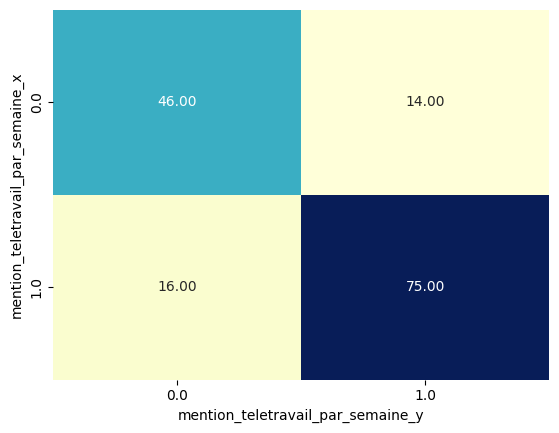

In [76]:
import matplotlib.pyplot as plt
import seaborn as sn


res = sn.heatmap(contingency_matrix.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
plt.show()

In [86]:
df_merge.loc[df_merge["mention_teletravail_par_semaine_y"]==0,"nombre_jours_teletravail_semaine_y"]=0

In [88]:
df_merge["diff"]=(df_merge.nombre_jours_teletravail_semaine_x!=df_merge.nombre_jours_teletravail_semaine_y)
print("global accuracy",1-(df_merge["diff"].sum()/df_merge.shape[0]))

df_rempli=df_merge[df_merge.nombre_jours_teletravail_semaine_x!=0.0]
nb_correct,total =df_rempli.shape[0]-df_rempli["diff"].sum(),df_rempli.shape[0]
print("accuracy on non null value",1-(df_rempli["diff"].sum()/df_rempli.shape[0]),f"; nombre correct : {nb_correct} sur {total}")

df_rempli=df_merge[df_merge.nombre_jours_teletravail_semaine_x==0.0]
nb_correct,total =df_rempli.shape[0]-df_rempli["diff"].sum(),df_rempli.shape[0]
print("accuracy on null value",1-(df_rempli["diff"].sum()/df_rempli.shape[0]),f"; nombre correct : {nb_correct} sur {total}")

global accuracy 0.7417218543046358
accuracy on non null value 0.7083333333333333 ; nombre correct : 68 sur 96
accuracy on null value 0.8 ; nombre correct : 44 sur 55
